In [1]:
import keras
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
from keras.callbacks import ModelCheckpoint, EarlyStopping
# %reload_ext mermaid
# import IPython
# IPython.load_ipython_extensions(["nb-mermaid/nb-mermaid"]);

Using TensorFlow backend.


In [2]:
import tensorflow  as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dropout,UpSampling2D, Dense, MaxPooling2D, BatchNormalization, Input, Flatten, Lambda
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import Adadelta, SGD, Adam
from keras.utils import to_categorical
import keras.backend as K

In [3]:
tf_config = tf.ConfigProto(allow_soft_placement=False)
tf_config.gpu_options.allow_growth = True
s = tf.Session(config=tf_config)
K.set_session(s)

In [4]:
csv_data = pd.read_csv('15features.csv')
display(csv_data.head()), display(csv_data.shape)
train_path = 'unseen-dataset/TrainingSet/'
train_images = os.listdir(train_path)

val_path = 'unseen-dataset/ValidationSet/'
val_images = os.listdir(val_path)
len(train_images)+len(val_images)

imagename  pen_pressure  letter_spacing  size  dimension  \
0  0968c_num1.png             2               2     2          1   
1  0809c_num2.png             2               2     2          2   
2  0237b_num6.png             2               2     2          2   
3  0069b_num2.png             2               2     2          1   
4  0966c_num4.png             2               2     2          2   

   is_lowercase  is_continuous  slantness  tilt  entry_stroke_a  staff_of_a  \
0             2              2          3     2               1           2   
1             2              2          3     1               1           2   
2             2              2          2     2               1           2   
3             2              2          1     1               1           1   
4             2              2          2     1               1           2   

   formation_n  staff_of_d  exit_stroke_d  word_formation  constancy  
0            2           3              2               2          1  
1            2           3              1               2          2  
2            2           2              2               2          2  
3            1           1              1               1          1  
4            2           2              2               2          2

(13570, 16)

13794

In [5]:
# len(list(set(list(x[:4] for x in images['image'])))), len(list(set(list(x[:4] for x in csv_data['ImageId']))))

In [6]:
dataset_columns = csv_data.columns
csv_data['imagename'] = csv_data['imagename'].astype('str')
display(csv_data.head(20))
csv_data.shape

imagename  pen_pressure  letter_spacing  size  dimension  \
0   0968c_num1.png             2               2     2          1   
1   0809c_num2.png             2               2     2          2   
2   0237b_num6.png             2               2     2          2   
3   0069b_num2.png             2               2     2          1   
4   0966c_num4.png             2               2     2          2   
5   1316a_num2.png             2               2     1          1   
6   1503c_num2.png             2               1     2          2   
7   0113c_num1.png             2               3     2          2   
8   0221a_num6.png             2               2     2          2   
9   0068a_num4.png             1               1     2          2   
10  1094b_num1.png             2               3     1          1   
11  0337c_num6.png             2               2     2          2   
12  0837a_num4.png             2               2     2          2   
13  0941b_num3.png             2               2     2          2   
14  0260a_num3.png             2               2     2          2   
15  0598c_num4.png             1               3     2          2   
16  0380a_num2.png             2               2     2          2   
17  0384b_num2.png             2               2     2          2   
18  1224a_num3.png             2               2     2          2   
19  1131b_num3.png             2               2     2          2   

    is_lowercase  is_continuous  slantness  tilt  entry_stroke_a  staff_of_a  \
0              2              2          3     2               1           2   
1              2              2          3     1               1           2   
2              2              2          2     2               1           2   
3              2              2          1     1               1           1   
4              2              2          2     1               1           2   
5              2              2          3     1               1           2   
6              2              2          2     1               1           3   
7              2              1          2     1               1           1   
8              2              1          1     1               1           4   
9              2              2          1     1               1           2   
10             2              2          2     1               1           1   
11             2              2          3     1               1           2   
12             2              2          1     1               1           3   
13             2              2          2     1               1           1   
14             2              2          2     1               1           2   
15             1              1          2     1               1           1   
16             2              2          4     1               1           2   
17             2              2          2     1               1           2   
18             2              2          1     1               1           4   
19             2              2          1     1               1           2   

    formation_n  staff_of_d  exit_stroke_d  word_formation  constancy  
0             2           3              2               2          1  
1             2           3              1               2          2  
2             2           2              2               2          2  
3             1           1              1               1          1  
4             2           2              2               2          2  
5             2           2              3               2          2  
6             2           2              3               2          2  
7             2           2              2               2          2  
8             1           2              3               1          2  
9             2           2              2               2          2  
10            1           3              2               1          1  
11            

(13570, 16)

In [7]:
# train_csv_data =  csv_data[:700]
# val_csv_data =  csv_data[700:]
# train_csv_data.shape, val_csv_data.shape

In [8]:
f = []
for col in dataset_columns[1:]:
    f.append(csv_data[col].unique().shape[0])
f,len(f)

([2, 3, 3, 3, 2, 2, 4, 2, 2, 4, 2, 3, 4, 2, 2], 15)

In [9]:
input_img = Input(shape=(64, 64, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='encoded')(x)
# encoded = GlobalAveragePooling2D()(x)

# encoder = Model(input_img, encoded)
# encoder.summary()
# print(encoded.shape)
# encoded = Flatten()(x)
# encoded = Dense(8*8*8)(encoded)
# # model = Model(input_img,encoded)
# # print(model.summary())
# # at this point the representation is (4, 4, 8) i.e. 128-dimensional
# r = Reshape(target_shape=(8,8,8))(encoded)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same',name='output')(x)

autoencoder = Model(input_img, decoded)
autoencoder.load_weights('weights/simple_ae_maxpool_Unseen_weights_v1.h5')

In [10]:
encoder = Model(autoencoder.input,autoencoder.get_layer('encoded').output)
encoder.summary()
for layer in encoder.layers:
    layer.trainable = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
__________

In [11]:

# # model = Sequential()
# input_layer = Input((64,64,1))
# model = BatchNormalization()(input_layer)

# model = Conv2D(activation='relu',filters=32, kernel_size=(32,32), padding='same')(model)
# model = Conv2D(activation='relu',filters=64, kernel_size=(32,32), strides=(1,1), padding='same')(model)
# model = MaxPool2D((2,2))(model)
# model = Dropout(0.25)(model)

# model = Conv2D(activation='relu',filters=128, kernel_size=(16,16), padding='same')(model)
# model = Conv2D(activation='relu',filters=256, kernel_size=(16,16), strides=(1,1), padding='same')(model)
# model = MaxPool2D((2,2))(model)
# model = Dropout(0.25)(model)

# model = Conv2D(activation='relu',filters=128, kernel_size=(8,8), padding='same')(model)
# model = Conv2D(activation='relu',filters=256, kernel_size=(8,8), strides=(1,1), padding='same')(model)
# model = MaxPool2D((2,2))(model)
# model = Dropout(0.25)(model)
# # model = Flatten()(model)

# dense_layer = Dense(512, activation='relu')(model)
# dense_layer = Dropout(0.5)(dense_layer)
dense_layer = encoder.get_layer('encoded').output
out_dense_layer=[]
for i in range(1,len(f)+1):
    out_dense_layer.append(Dense(f[i-1] , activation='softmax', name = 'out_feature_'+str(i))(Dense(128 , activation='relu', name = 'dense_layer_'+str(i))(Flatten()((dense_layer)))))

human_features = Model(inputs=encoder.input, outputs=out_dense_layer)
human_features.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 16)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 32)   4640        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

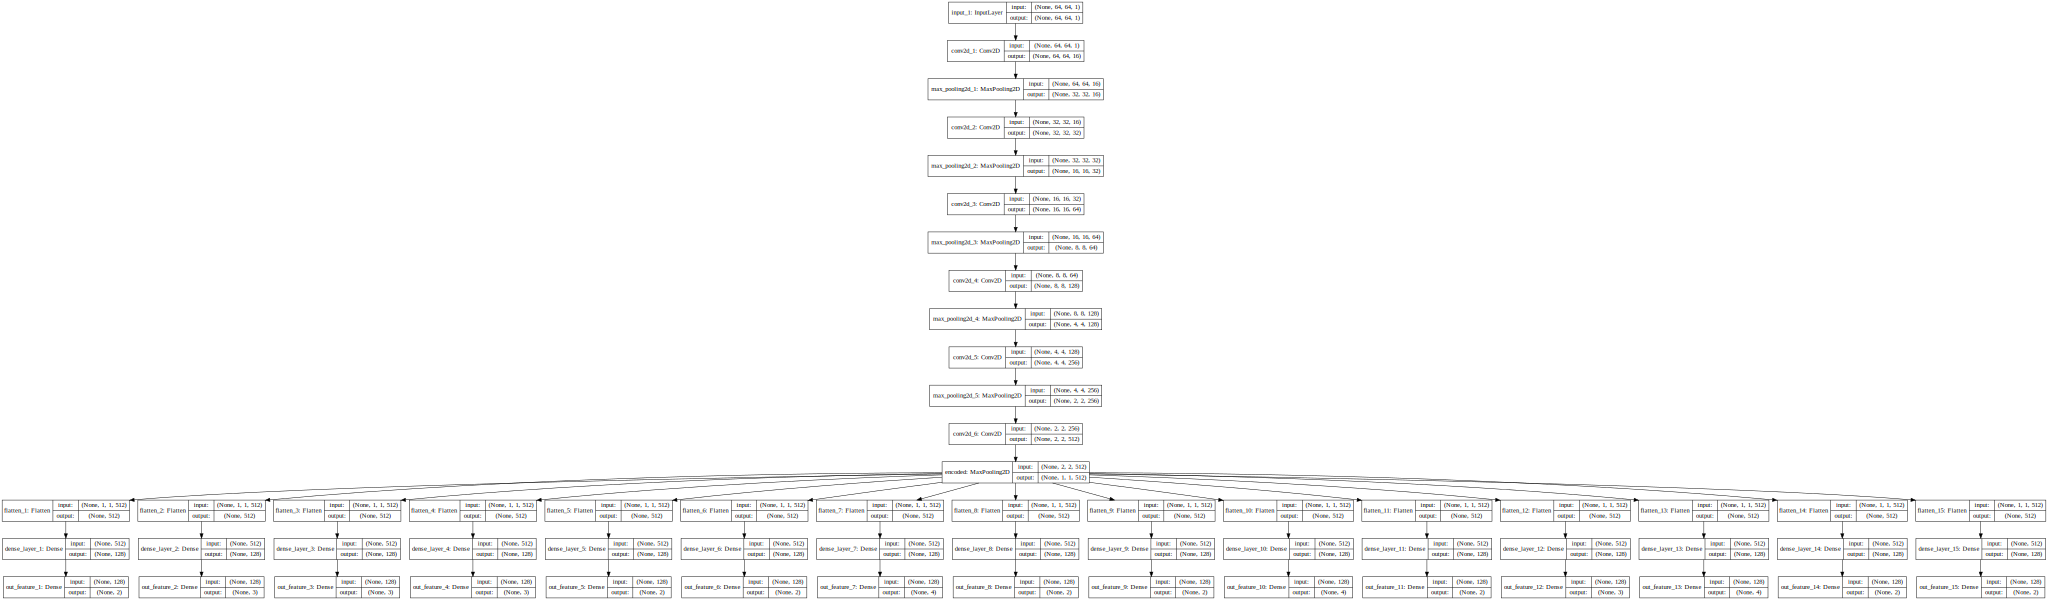

In [12]:
SVG(model_to_dot(human_features, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

In [13]:
feature_lengths = {}
for col in dataset_columns[1:]:
    feature_lengths[col] = len(csv_data[col].unique())
feature_lengths = list(feature_lengths.values())
feature_lengths

[2, 3, 3, 3, 2, 2, 4, 2, 2, 4, 2, 3, 4, 2, 2]

In [14]:
# df_data[df_data['f8']==2]

In [15]:
# im = images[images['image'].str.match('1229b')]
# im.iloc[0]['image']

In [16]:

# stop_at = 20
# identitycounter = 1
# unique_writers = list(set(list(x[:4] for x in df_data['ImageId'])))
# for writer in unique_writers:
#     print(identitycounter*100/stop_at, end='\r')
#     writer_samples = list(images[images['image'].str.match(writer)]['image'])
# #     print('lne',len(writer_samples))
#     f,ax = plt.subplots(1,len(writer_samples))
#     f.subplots_adjust(hspace = .5, wspace=.15)
#     f.set_size_inches(15,15)
#     imgcounter = 0
#     for sample in writer_samples:
#         imagepath = os.path.join(image_path,sample)
#         raw_img = cv2.imread(imagepath)
#         if len(writer_samples)>1:
#             ax[imgcounter].imshow(raw_img)
#             ax[imgcounter].set_title(writer+'\n'+sample)
#         else:
#             ax.imshow(raw_img)
#             ax.set_title(writer+'\n'+sample)
# #         ax[imgcounter].axis('off')
#         imgcounter+=1
#         if imgcounter == stop_at:
#             break
#     imgcounter=0
#     identitycounter += 1
#     if identitycounter == stop_at+1:
#         break

In [17]:
# csv_data[csv_data['ImageId'].str.match('1302c')]

In [18]:

def datagen(batch_size,image_path,list_of_writers, vshift = (-64,64) ,vis=False):
    counter = 0
    w_ids,ids,x,y,imagenames, feature_list = [],[],[],[],[],[]
    while True:
#         counter = 0
        # for writer in unique_writers:
        #     print(identitycounter*100/stop_at, end='\r')
        
        writer_index = np.random.randint(0,len(list_of_writers))
        
#         for writer_index in writer_indexes:
#             class_vectors = []
#             features = None
        imagename = list_of_writers[writer_index]
#             print('-->',csv_data['imagename'][0],imagename)
#             display(csv_data[csv_data['imagename']==imagename].values[0][1:])
        features = csv_data[csv_data['imagename']==imagename].values
        if len(features)==0:
#             print('no features', imagename)
            continue
        features = features[0][1:]-1
#             print(features)
#             print(writer)
#             writer_samples = list(images[images['image'].str.match(writer)]['image'])
#             print('writer:',writer,', writer_samples:',writer_samples)
#             if len(writer_samples) == 0:
#                 continue
#             writer_sample_index = np.random.randint(0,len(writer_samples))

#             #     unique_writers_count[writer] = len(writer_samples)
# #             print('writer_sample_index:',writer_sample_index)
#             csv_writer = writer_samples[writer_sample_index][:5]


        loaded_image = cv2.imread(os.path.join(image_path,imagename),0)
        rand = np.random.randint(vshift[0],vshift[1])
        loaded_image_shifted=np.roll(axis=0,a=loaded_image,shift=rand)

        x.append(255.0-loaded_image_shifted.reshape((64,64,1)))
        y.append(255.0-loaded_image.reshape((64,64,1)))
        w_ids.append(imagename[:4])
        imagenames.append(imagename)
        ids.append(writer_index)
        feature_list.append(features)
#         print(imagename)
        counter+=1
#         print('counter:', counter, end='\r')
        if counter == batch_size:
            counter=0
            feature_list = np.array(feature_list)
            feature_list = feature_list.transpose()
            out_cat_features = []
            for i in range(len(feature_list)):
#                 print(feature_list[1])
                out_cat_features.append(to_categorical(feature_list[i],num_classes=feature_lengths[i]))
            if vis== True:
                yield np.array(x)/255.0,[np.array(w_ids),np.array(imagenames)]
            else:
                yield np.array(x)/255.0,out_cat_features
            w_ids,ids,x,y,imagenames,feature_list =[], [],[], [],[],[]    

In [19]:

batch_size = 64

tg = datagen(batch_size,image_path=train_path,vshift=(-10,10),list_of_writers=train_images)
vg = datagen(batch_size,image_path=val_path,vshift=(-10,10), list_of_writers=val_images)


In [20]:
# images
inputs,o = next(tg)
print(inputs.shape)
for op in o:
    print((np.argmax(op, axis=1)+1)[0])
#     print('------')
# feature_list

(64, 64, 64, 1)
2
3
2
2
2
1
1
1
1
2
2
2
1
2
2


In [21]:
csv_data[csv_data['imagename']=='0066c_num3.png'].values[0][1:]

array([2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1], dtype=object)

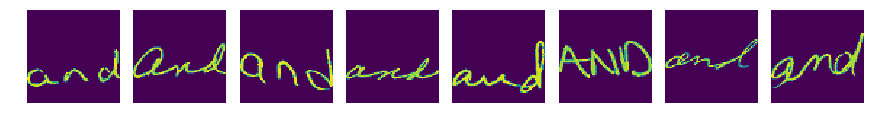

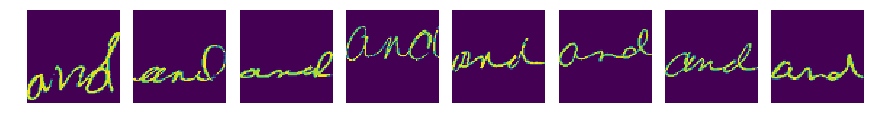

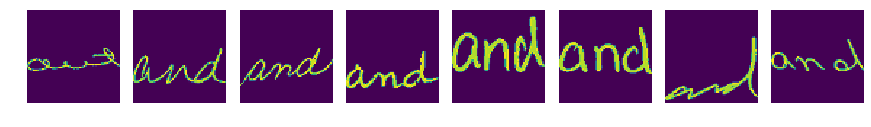

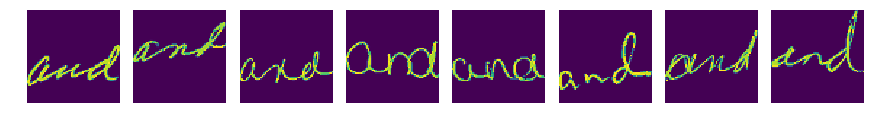

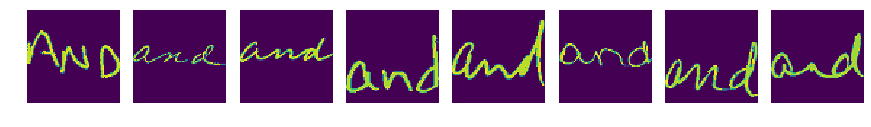

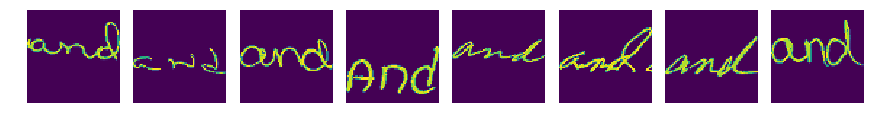

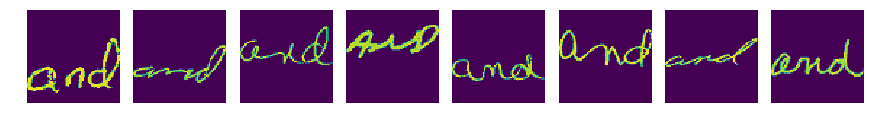

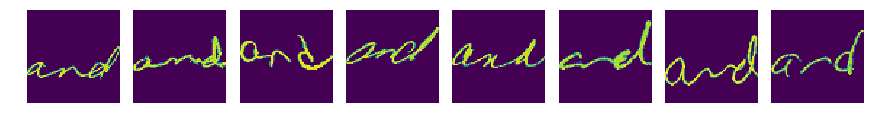

In [22]:
for r in range(8):
    f,ax = plt.subplots(1,8)
    f.subplots_adjust(hspace = .00, wspace=.15)
    f.set_size_inches(15,5)
    for c in range (8):
        ax[c].imshow(inputs[c+r*8].reshape((64,64)))
        ax[c].axis('off')

In [23]:
losses = {}
lossWeights = {}
for i in range(1,16):
    losses["out_feature_"+str(i)] = "categorical_crossentropy"
    lossWeights["out_feature_"+str(i)] = 1.0
# lossWeights["out_feature_1"] = 10.0
# lossWeights["out_feature_2"] = 8.0
# lossWeights["out_feature_3"] = 0.1
# lossWeights["out_feature_4"] = 8.0
# lossWeights["out_feature_5"] = 1.0
# lossWeights["out_feature_6"] = 5.0
# lossWeights["out_feature_7"] = 5.0
# lossWeights["out_feature_8"] = 10.0


In [24]:
mc = ModelCheckpoint(filepath='weights/15-Multitask-FrozenEncoder-unseen_v2.h5', monitor='val_loss',period=1,save_best_only=True,save_weights_only=True,mode='auto',verbose=3)
es = EarlyStopping(patience=10000, monitor='val_loss', min_delta=0.0005, mode='auto')

In [25]:
EPOCHS = 500000
INIT_LR = 0.0001
opt = SGD(lr=INIT_LR, decay=1e-6, momentum=0.95, nesterov=True)
# opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# opt = Adadelta(lr=INIT_LR, decay=1e-04)

# feat_extractor.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,metrics=["accuracy"])


human_features.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,metrics=["accuracy"])
human_features.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 16)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 32)   4640        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

In [26]:
# human_features.load_weights('human_features_weights_v3.h5')
# inputs,o = next(vg)
# for i in range(64):
#     print(i)
#     f_probs = human_features.predict(np.expand_dims(inputs[i],0))
# #     print(f_probs)
#     for prob in f_probs:
#         print(np.argmax(prob),end=',')
#     print('++++++++++++')
# human_features.load_weights('15_human_features_weights_unseen_v1.h5')

In [27]:
human_features.load_weights('weights/15-Multitask-FrozenEncoder-unseen_v1.h5')
hist = human_features.fit_generator(tg, callbacks=[mc,es]
                                    , epochs=EPOCHS
                                    , steps_per_epoch = 1
                                    , validation_data = vg
                                    , validation_steps = 1
                                    , verbose = 3
                                    
                                   )

Epoch 1/500000

Epoch 00001: val_loss improved from inf to 10.49993, saving model to weights/15-Multitask-FrozenEncoder-unseen_v2.h5
Epoch 2/500000

Epoch 00002: val_loss did not improve from 10.49993
Epoch 3/500000

Epoch 00003: val_loss improved from 10.49993 to 10.41235, saving model to weights/15-Multitask-FrozenEncoder-unseen_v2.h5
Epoch 4/500000

Epoch 00004: val_loss did not improve from 10.41235
Epoch 5/500000

Epoch 00005: val_loss did not improve from 10.41235
Epoch 6/500000

Epoch 00006: val_loss did not improve from 10.41235
Epoch 7/500000

Epoch 00007: val_loss did not improve from 10.41235
Epoch 8/500000

Epoch 00008: val_loss did not improve from 10.41235
Epoch 9/500000

Epoch 00009: val_loss did not improve from 10.41235
Epoch 10/500000

Epoch 00010: val_loss improved from 10.41235 to 10.14099, saving model to weights/15-Multitask-FrozenEncoder-unseen_v2.h5
Epoch 11/500000

Epoch 00011: val_loss improved from 10.14099 to 10.12687, saving model to weights/15-Multitask-Fr


Epoch 00111: val_loss did not improve from 9.36926
Epoch 112/500000

Epoch 00112: val_loss did not improve from 9.36926
Epoch 113/500000

Epoch 00113: val_loss did not improve from 9.36926
Epoch 114/500000

Epoch 00114: val_loss did not improve from 9.36926
Epoch 115/500000

Epoch 00115: val_loss did not improve from 9.36926
Epoch 116/500000

Epoch 00116: val_loss did not improve from 9.36926
Epoch 117/500000

Epoch 00117: val_loss did not improve from 9.36926
Epoch 118/500000

Epoch 00118: val_loss did not improve from 9.36926
Epoch 119/500000

Epoch 00119: val_loss did not improve from 9.36926
Epoch 120/500000

Epoch 00120: val_loss did not improve from 9.36926
Epoch 121/500000

Epoch 00121: val_loss did not improve from 9.36926
Epoch 122/500000

Epoch 00122: val_loss did not improve from 9.36926
Epoch 123/500000

Epoch 00123: val_loss did not improve from 9.36926
Epoch 124/500000

Epoch 00124: val_loss did not improve from 9.36926
Epoch 125/500000

Epoch 00125: val_loss did not imp


Epoch 00226: val_loss did not improve from 8.70207
Epoch 227/500000

Epoch 00227: val_loss did not improve from 8.70207
Epoch 228/500000

Epoch 00228: val_loss did not improve from 8.70207
Epoch 229/500000

Epoch 00229: val_loss did not improve from 8.70207
Epoch 230/500000

Epoch 00230: val_loss did not improve from 8.70207
Epoch 231/500000

Epoch 00231: val_loss did not improve from 8.70207
Epoch 232/500000

Epoch 00232: val_loss did not improve from 8.70207
Epoch 233/500000

Epoch 00233: val_loss did not improve from 8.70207
Epoch 234/500000

Epoch 00234: val_loss did not improve from 8.70207
Epoch 235/500000

Epoch 00235: val_loss did not improve from 8.70207
Epoch 236/500000

Epoch 00236: val_loss did not improve from 8.70207
Epoch 237/500000

Epoch 00237: val_loss did not improve from 8.70207
Epoch 238/500000

Epoch 00238: val_loss did not improve from 8.70207
Epoch 239/500000

Epoch 00239: val_loss did not improve from 8.70207
Epoch 240/500000

Epoch 00240: val_loss did not imp


Epoch 00345: val_loss did not improve from 8.70207
Epoch 346/500000

Epoch 00346: val_loss did not improve from 8.70207
Epoch 347/500000

Epoch 00347: val_loss did not improve from 8.70207
Epoch 348/500000

Epoch 00348: val_loss did not improve from 8.70207
Epoch 349/500000

Epoch 00349: val_loss did not improve from 8.70207
Epoch 350/500000

Epoch 00350: val_loss did not improve from 8.70207
Epoch 351/500000

Epoch 00351: val_loss did not improve from 8.70207
Epoch 352/500000

Epoch 00352: val_loss did not improve from 8.70207
Epoch 353/500000

Epoch 00353: val_loss did not improve from 8.70207
Epoch 354/500000

Epoch 00354: val_loss did not improve from 8.70207
Epoch 355/500000

Epoch 00355: val_loss did not improve from 8.70207
Epoch 356/500000

Epoch 00356: val_loss did not improve from 8.70207
Epoch 357/500000

Epoch 00357: val_loss did not improve from 8.70207
Epoch 358/500000

Epoch 00358: val_loss did not improve from 8.70207
Epoch 359/500000

Epoch 00359: val_loss did not imp


Epoch 00460: val_loss did not improve from 8.51410
Epoch 461/500000

Epoch 00461: val_loss did not improve from 8.51410
Epoch 462/500000

Epoch 00462: val_loss did not improve from 8.51410
Epoch 463/500000

Epoch 00463: val_loss did not improve from 8.51410
Epoch 464/500000

Epoch 00464: val_loss did not improve from 8.51410
Epoch 465/500000

Epoch 00465: val_loss did not improve from 8.51410
Epoch 466/500000

Epoch 00466: val_loss did not improve from 8.51410
Epoch 467/500000

Epoch 00467: val_loss did not improve from 8.51410
Epoch 468/500000

Epoch 00468: val_loss did not improve from 8.51410
Epoch 469/500000

Epoch 00469: val_loss improved from 8.51410 to 8.49572, saving model to weights/15-Multitask-FrozenEncoder-unseen_v2.h5
Epoch 470/500000

Epoch 00470: val_loss did not improve from 8.49572
Epoch 471/500000

Epoch 00471: val_loss did not improve from 8.49572
Epoch 472/500000

Epoch 00472: val_loss did not improve from 8.49572
Epoch 473/500000

Epoch 00473: val_loss did not imp


Epoch 00573: val_loss did not improve from 8.02012
Epoch 574/500000

Epoch 00574: val_loss did not improve from 8.02012
Epoch 575/500000

Epoch 00575: val_loss did not improve from 8.02012
Epoch 576/500000

Epoch 00576: val_loss did not improve from 8.02012
Epoch 577/500000

Epoch 00577: val_loss did not improve from 8.02012
Epoch 578/500000

Epoch 00578: val_loss did not improve from 8.02012
Epoch 579/500000

Epoch 00579: val_loss did not improve from 8.02012
Epoch 580/500000

Epoch 00580: val_loss did not improve from 8.02012
Epoch 581/500000

Epoch 00581: val_loss did not improve from 8.02012
Epoch 582/500000

Epoch 00582: val_loss did not improve from 8.02012
Epoch 583/500000

Epoch 00583: val_loss did not improve from 8.02012
Epoch 584/500000

Epoch 00584: val_loss did not improve from 8.02012
Epoch 585/500000

Epoch 00585: val_loss did not improve from 8.02012
Epoch 586/500000

Epoch 00586: val_loss did not improve from 8.02012
Epoch 587/500000

Epoch 00587: val_loss did not imp


Epoch 00691: val_loss did not improve from 7.91409
Epoch 692/500000

Epoch 00692: val_loss did not improve from 7.91409
Epoch 693/500000

Epoch 00693: val_loss did not improve from 7.91409
Epoch 694/500000

Epoch 00694: val_loss did not improve from 7.91409
Epoch 695/500000

Epoch 00695: val_loss did not improve from 7.91409
Epoch 696/500000

Epoch 00696: val_loss did not improve from 7.91409
Epoch 697/500000

Epoch 00697: val_loss did not improve from 7.91409
Epoch 698/500000

Epoch 00698: val_loss did not improve from 7.91409
Epoch 699/500000

Epoch 00699: val_loss did not improve from 7.91409
Epoch 700/500000

Epoch 00700: val_loss did not improve from 7.91409
Epoch 701/500000

Epoch 00701: val_loss did not improve from 7.91409
Epoch 702/500000

Epoch 00702: val_loss did not improve from 7.91409
Epoch 703/500000

Epoch 00703: val_loss did not improve from 7.91409
Epoch 704/500000

Epoch 00704: val_loss did not improve from 7.91409
Epoch 705/500000

Epoch 00705: val_loss did not imp


Epoch 00810: val_loss did not improve from 7.91409
Epoch 811/500000

Epoch 00811: val_loss did not improve from 7.91409
Epoch 812/500000

Epoch 00812: val_loss did not improve from 7.91409
Epoch 813/500000

Epoch 00813: val_loss did not improve from 7.91409
Epoch 814/500000

Epoch 00814: val_loss did not improve from 7.91409
Epoch 815/500000

Epoch 00815: val_loss did not improve from 7.91409
Epoch 816/500000

Epoch 00816: val_loss did not improve from 7.91409
Epoch 817/500000

Epoch 00817: val_loss did not improve from 7.91409
Epoch 818/500000

Epoch 00818: val_loss did not improve from 7.91409
Epoch 819/500000

Epoch 00819: val_loss did not improve from 7.91409
Epoch 820/500000

Epoch 00820: val_loss did not improve from 7.91409
Epoch 821/500000

Epoch 00821: val_loss did not improve from 7.91409
Epoch 822/500000

Epoch 00822: val_loss did not improve from 7.91409
Epoch 823/500000

Epoch 00823: val_loss did not improve from 7.91409
Epoch 824/500000

Epoch 00824: val_loss did not imp


Epoch 00928: val_loss did not improve from 7.78272
Epoch 929/500000

Epoch 00929: val_loss did not improve from 7.78272
Epoch 930/500000

Epoch 00930: val_loss did not improve from 7.78272
Epoch 931/500000

Epoch 00931: val_loss did not improve from 7.78272
Epoch 932/500000

Epoch 00932: val_loss did not improve from 7.78272
Epoch 933/500000

Epoch 00933: val_loss did not improve from 7.78272
Epoch 934/500000

Epoch 00934: val_loss did not improve from 7.78272
Epoch 935/500000

Epoch 00935: val_loss did not improve from 7.78272
Epoch 936/500000

Epoch 00936: val_loss did not improve from 7.78272
Epoch 937/500000

Epoch 00937: val_loss did not improve from 7.78272
Epoch 938/500000

Epoch 00938: val_loss did not improve from 7.78272
Epoch 939/500000

Epoch 00939: val_loss did not improve from 7.78272
Epoch 940/500000

Epoch 00940: val_loss did not improve from 7.78272
Epoch 941/500000

Epoch 00941: val_loss did not improve from 7.78272
Epoch 942/500000

Epoch 00942: val_loss did not imp


Epoch 01047: val_loss did not improve from 7.78272
Epoch 1048/500000

Epoch 01048: val_loss did not improve from 7.78272
Epoch 1049/500000

Epoch 01049: val_loss did not improve from 7.78272
Epoch 1050/500000

Epoch 01050: val_loss did not improve from 7.78272
Epoch 1051/500000

Epoch 01051: val_loss did not improve from 7.78272
Epoch 1052/500000

Epoch 01052: val_loss did not improve from 7.78272
Epoch 1053/500000

Epoch 01053: val_loss did not improve from 7.78272
Epoch 1054/500000

Epoch 01054: val_loss did not improve from 7.78272
Epoch 1055/500000

Epoch 01055: val_loss did not improve from 7.78272
Epoch 1056/500000

Epoch 01056: val_loss did not improve from 7.78272
Epoch 1057/500000

Epoch 01057: val_loss did not improve from 7.78272
Epoch 1058/500000

Epoch 01058: val_loss did not improve from 7.78272
Epoch 1059/500000

Epoch 01059: val_loss did not improve from 7.78272
Epoch 1060/500000

Epoch 01060: val_loss did not improve from 7.78272
Epoch 1061/500000

Epoch 01061: val_lo


Epoch 01163: val_loss did not improve from 7.64563
Epoch 1164/500000

Epoch 01164: val_loss did not improve from 7.64563
Epoch 1165/500000

Epoch 01165: val_loss did not improve from 7.64563
Epoch 1166/500000

Epoch 01166: val_loss did not improve from 7.64563
Epoch 1167/500000

Epoch 01167: val_loss did not improve from 7.64563
Epoch 1168/500000

Epoch 01168: val_loss did not improve from 7.64563
Epoch 1169/500000

Epoch 01169: val_loss did not improve from 7.64563
Epoch 1170/500000

Epoch 01170: val_loss did not improve from 7.64563
Epoch 1171/500000

Epoch 01171: val_loss did not improve from 7.64563
Epoch 1172/500000

Epoch 01172: val_loss did not improve from 7.64563
Epoch 1173/500000

Epoch 01173: val_loss did not improve from 7.64563
Epoch 1174/500000

Epoch 01174: val_loss did not improve from 7.64563
Epoch 1175/500000

Epoch 01175: val_loss did not improve from 7.64563
Epoch 1176/500000

Epoch 01176: val_loss did not improve from 7.64563
Epoch 1177/500000

Epoch 01177: val_lo


Epoch 01281: val_loss did not improve from 7.64563
Epoch 1282/500000

Epoch 01282: val_loss did not improve from 7.64563
Epoch 1283/500000

Epoch 01283: val_loss did not improve from 7.64563
Epoch 1284/500000

Epoch 01284: val_loss did not improve from 7.64563
Epoch 1285/500000

Epoch 01285: val_loss did not improve from 7.64563
Epoch 1286/500000

Epoch 01286: val_loss did not improve from 7.64563
Epoch 1287/500000

Epoch 01287: val_loss did not improve from 7.64563
Epoch 1288/500000

Epoch 01288: val_loss did not improve from 7.64563
Epoch 1289/500000

Epoch 01289: val_loss did not improve from 7.64563
Epoch 1290/500000

Epoch 01290: val_loss did not improve from 7.64563
Epoch 1291/500000

Epoch 01291: val_loss did not improve from 7.64563
Epoch 1292/500000

Epoch 01292: val_loss did not improve from 7.64563
Epoch 1293/500000

Epoch 01293: val_loss did not improve from 7.64563
Epoch 1294/500000

Epoch 01294: val_loss did not improve from 7.64563
Epoch 1295/500000

Epoch 01295: val_lo


Epoch 01398: val_loss did not improve from 7.58164
Epoch 1399/500000

Epoch 01399: val_loss did not improve from 7.58164
Epoch 1400/500000

Epoch 01400: val_loss did not improve from 7.58164
Epoch 1401/500000

Epoch 01401: val_loss did not improve from 7.58164
Epoch 1402/500000

Epoch 01402: val_loss did not improve from 7.58164
Epoch 1403/500000

Epoch 01403: val_loss did not improve from 7.58164
Epoch 1404/500000

Epoch 01404: val_loss did not improve from 7.58164
Epoch 1405/500000

Epoch 01405: val_loss did not improve from 7.58164
Epoch 1406/500000

Epoch 01406: val_loss did not improve from 7.58164
Epoch 1407/500000

Epoch 01407: val_loss did not improve from 7.58164
Epoch 1408/500000

Epoch 01408: val_loss did not improve from 7.58164
Epoch 1409/500000

Epoch 01409: val_loss did not improve from 7.58164
Epoch 1410/500000

Epoch 01410: val_loss did not improve from 7.58164
Epoch 1411/500000

Epoch 01411: val_loss did not improve from 7.58164
Epoch 1412/500000

Epoch 01412: val_lo


Epoch 01515: val_loss did not improve from 7.39322
Epoch 1516/500000

Epoch 01516: val_loss did not improve from 7.39322
Epoch 1517/500000

Epoch 01517: val_loss did not improve from 7.39322
Epoch 1518/500000

Epoch 01518: val_loss did not improve from 7.39322
Epoch 1519/500000

Epoch 01519: val_loss did not improve from 7.39322
Epoch 1520/500000

Epoch 01520: val_loss did not improve from 7.39322
Epoch 1521/500000

Epoch 01521: val_loss did not improve from 7.39322
Epoch 1522/500000

Epoch 01522: val_loss did not improve from 7.39322
Epoch 1523/500000

Epoch 01523: val_loss did not improve from 7.39322
Epoch 1524/500000

Epoch 01524: val_loss did not improve from 7.39322
Epoch 1525/500000

Epoch 01525: val_loss did not improve from 7.39322
Epoch 1526/500000

Epoch 01526: val_loss did not improve from 7.39322
Epoch 1527/500000

Epoch 01527: val_loss did not improve from 7.39322
Epoch 1528/500000

Epoch 01528: val_loss did not improve from 7.39322
Epoch 1529/500000

Epoch 01529: val_lo


Epoch 01633: val_loss did not improve from 7.39322
Epoch 1634/500000

Epoch 01634: val_loss did not improve from 7.39322
Epoch 1635/500000

Epoch 01635: val_loss did not improve from 7.39322
Epoch 1636/500000

Epoch 01636: val_loss did not improve from 7.39322
Epoch 1637/500000

Epoch 01637: val_loss did not improve from 7.39322
Epoch 1638/500000

Epoch 01638: val_loss did not improve from 7.39322
Epoch 1639/500000

Epoch 01639: val_loss did not improve from 7.39322
Epoch 1640/500000

Epoch 01640: val_loss did not improve from 7.39322
Epoch 1641/500000

Epoch 01641: val_loss did not improve from 7.39322
Epoch 1642/500000

Epoch 01642: val_loss did not improve from 7.39322
Epoch 1643/500000

Epoch 01643: val_loss did not improve from 7.39322
Epoch 1644/500000

Epoch 01644: val_loss did not improve from 7.39322
Epoch 1645/500000

Epoch 01645: val_loss did not improve from 7.39322
Epoch 1646/500000

Epoch 01646: val_loss did not improve from 7.39322
Epoch 1647/500000

Epoch 01647: val_lo


Epoch 01751: val_loss did not improve from 7.39322
Epoch 1752/500000

Epoch 01752: val_loss did not improve from 7.39322
Epoch 1753/500000

Epoch 01753: val_loss did not improve from 7.39322
Epoch 1754/500000

Epoch 01754: val_loss did not improve from 7.39322
Epoch 1755/500000

Epoch 01755: val_loss did not improve from 7.39322
Epoch 1756/500000

Epoch 01756: val_loss did not improve from 7.39322
Epoch 1757/500000

Epoch 01757: val_loss did not improve from 7.39322
Epoch 1758/500000

Epoch 01758: val_loss did not improve from 7.39322
Epoch 1759/500000

Epoch 01759: val_loss did not improve from 7.39322
Epoch 1760/500000

Epoch 01760: val_loss did not improve from 7.39322
Epoch 1761/500000

Epoch 01761: val_loss did not improve from 7.39322
Epoch 1762/500000

Epoch 01762: val_loss did not improve from 7.39322
Epoch 1763/500000

Epoch 01763: val_loss did not improve from 7.39322
Epoch 1764/500000

Epoch 01764: val_loss did not improve from 7.39322
Epoch 1765/500000

Epoch 01765: val_lo


Epoch 01868: val_loss did not improve from 7.36172
Epoch 1869/500000

Epoch 01869: val_loss did not improve from 7.36172
Epoch 1870/500000

Epoch 01870: val_loss did not improve from 7.36172
Epoch 1871/500000

Epoch 01871: val_loss did not improve from 7.36172
Epoch 1872/500000

Epoch 01872: val_loss did not improve from 7.36172
Epoch 1873/500000

Epoch 01873: val_loss did not improve from 7.36172
Epoch 1874/500000

Epoch 01874: val_loss did not improve from 7.36172
Epoch 1875/500000

Epoch 01875: val_loss did not improve from 7.36172
Epoch 1876/500000

Epoch 01876: val_loss did not improve from 7.36172
Epoch 1877/500000

Epoch 01877: val_loss did not improve from 7.36172
Epoch 1878/500000

Epoch 01878: val_loss did not improve from 7.36172
Epoch 1879/500000

Epoch 01879: val_loss did not improve from 7.36172
Epoch 1880/500000

Epoch 01880: val_loss did not improve from 7.36172
Epoch 1881/500000

Epoch 01881: val_loss did not improve from 7.36172
Epoch 1882/500000

Epoch 01882: val_lo


Epoch 01984: val_loss did not improve from 7.19676
Epoch 1985/500000

Epoch 01985: val_loss did not improve from 7.19676
Epoch 1986/500000

Epoch 01986: val_loss did not improve from 7.19676
Epoch 1987/500000

Epoch 01987: val_loss did not improve from 7.19676
Epoch 1988/500000

Epoch 01988: val_loss did not improve from 7.19676
Epoch 1989/500000

Epoch 01989: val_loss did not improve from 7.19676
Epoch 1990/500000

Epoch 01990: val_loss did not improve from 7.19676
Epoch 1991/500000

Epoch 01991: val_loss did not improve from 7.19676
Epoch 1992/500000

Epoch 01992: val_loss did not improve from 7.19676
Epoch 1993/500000

Epoch 01993: val_loss did not improve from 7.19676
Epoch 1994/500000

Epoch 01994: val_loss did not improve from 7.19676
Epoch 1995/500000

Epoch 01995: val_loss did not improve from 7.19676
Epoch 1996/500000

Epoch 01996: val_loss did not improve from 7.19676
Epoch 1997/500000

Epoch 01997: val_loss did not improve from 7.19676
Epoch 1998/500000

Epoch 01998: val_lo


Epoch 02102: val_loss did not improve from 7.19676
Epoch 2103/500000

Epoch 02103: val_loss did not improve from 7.19676
Epoch 2104/500000

Epoch 02104: val_loss did not improve from 7.19676
Epoch 2105/500000

Epoch 02105: val_loss did not improve from 7.19676
Epoch 2106/500000

Epoch 02106: val_loss did not improve from 7.19676
Epoch 2107/500000

Epoch 02107: val_loss did not improve from 7.19676
Epoch 2108/500000

Epoch 02108: val_loss did not improve from 7.19676
Epoch 2109/500000

Epoch 02109: val_loss did not improve from 7.19676
Epoch 2110/500000

Epoch 02110: val_loss did not improve from 7.19676
Epoch 2111/500000

Epoch 02111: val_loss did not improve from 7.19676
Epoch 2112/500000

Epoch 02112: val_loss did not improve from 7.19676
Epoch 2113/500000

Epoch 02113: val_loss did not improve from 7.19676
Epoch 2114/500000

Epoch 02114: val_loss did not improve from 7.19676
Epoch 2115/500000

Epoch 02115: val_loss did not improve from 7.19676
Epoch 2116/500000

Epoch 02116: val_lo


Epoch 02220: val_loss did not improve from 7.19676
Epoch 2221/500000

Epoch 02221: val_loss did not improve from 7.19676
Epoch 2222/500000

Epoch 02222: val_loss did not improve from 7.19676
Epoch 2223/500000

Epoch 02223: val_loss did not improve from 7.19676
Epoch 2224/500000

Epoch 02224: val_loss did not improve from 7.19676
Epoch 2225/500000

Epoch 02225: val_loss did not improve from 7.19676
Epoch 2226/500000

Epoch 02226: val_loss did not improve from 7.19676
Epoch 2227/500000

Epoch 02227: val_loss did not improve from 7.19676
Epoch 2228/500000

Epoch 02228: val_loss did not improve from 7.19676
Epoch 2229/500000

Epoch 02229: val_loss did not improve from 7.19676
Epoch 2230/500000

Epoch 02230: val_loss did not improve from 7.19676
Epoch 2231/500000

Epoch 02231: val_loss did not improve from 7.19676
Epoch 2232/500000

Epoch 02232: val_loss did not improve from 7.19676
Epoch 2233/500000

Epoch 02233: val_loss did not improve from 7.19676
Epoch 2234/500000

Epoch 02234: val_lo


Epoch 02338: val_loss did not improve from 7.19676
Epoch 2339/500000

Epoch 02339: val_loss did not improve from 7.19676
Epoch 2340/500000

Epoch 02340: val_loss did not improve from 7.19676
Epoch 2341/500000

Epoch 02341: val_loss did not improve from 7.19676
Epoch 2342/500000

Epoch 02342: val_loss did not improve from 7.19676
Epoch 2343/500000

Epoch 02343: val_loss did not improve from 7.19676
Epoch 2344/500000

Epoch 02344: val_loss did not improve from 7.19676
Epoch 2345/500000

Epoch 02345: val_loss did not improve from 7.19676
Epoch 2346/500000

Epoch 02346: val_loss did not improve from 7.19676
Epoch 2347/500000

Epoch 02347: val_loss did not improve from 7.19676
Epoch 2348/500000

Epoch 02348: val_loss did not improve from 7.19676
Epoch 2349/500000

Epoch 02349: val_loss did not improve from 7.19676
Epoch 2350/500000

Epoch 02350: val_loss did not improve from 7.19676
Epoch 2351/500000

Epoch 02351: val_loss did not improve from 7.19676
Epoch 2352/500000

Epoch 02352: val_lo


Epoch 02455: val_loss did not improve from 6.99691
Epoch 2456/500000

Epoch 02456: val_loss did not improve from 6.99691
Epoch 2457/500000

Epoch 02457: val_loss did not improve from 6.99691
Epoch 2458/500000

Epoch 02458: val_loss did not improve from 6.99691
Epoch 2459/500000

Epoch 02459: val_loss did not improve from 6.99691
Epoch 2460/500000

Epoch 02460: val_loss did not improve from 6.99691
Epoch 2461/500000

Epoch 02461: val_loss did not improve from 6.99691
Epoch 2462/500000

Epoch 02462: val_loss did not improve from 6.99691
Epoch 2463/500000

Epoch 02463: val_loss did not improve from 6.99691
Epoch 2464/500000

Epoch 02464: val_loss did not improve from 6.99691
Epoch 2465/500000

Epoch 02465: val_loss did not improve from 6.99691
Epoch 2466/500000

Epoch 02466: val_loss did not improve from 6.99691
Epoch 2467/500000

Epoch 02467: val_loss did not improve from 6.99691
Epoch 2468/500000

Epoch 02468: val_loss did not improve from 6.99691
Epoch 2469/500000

Epoch 02469: val_lo


Epoch 02573: val_loss did not improve from 6.99691
Epoch 2574/500000

Epoch 02574: val_loss did not improve from 6.99691
Epoch 2575/500000

Epoch 02575: val_loss did not improve from 6.99691
Epoch 2576/500000

Epoch 02576: val_loss did not improve from 6.99691
Epoch 2577/500000

Epoch 02577: val_loss did not improve from 6.99691
Epoch 2578/500000

Epoch 02578: val_loss did not improve from 6.99691
Epoch 2579/500000

Epoch 02579: val_loss did not improve from 6.99691
Epoch 2580/500000

Epoch 02580: val_loss did not improve from 6.99691
Epoch 2581/500000

Epoch 02581: val_loss did not improve from 6.99691
Epoch 2582/500000

Epoch 02582: val_loss did not improve from 6.99691
Epoch 2583/500000

Epoch 02583: val_loss did not improve from 6.99691
Epoch 2584/500000

Epoch 02584: val_loss did not improve from 6.99691
Epoch 2585/500000

Epoch 02585: val_loss did not improve from 6.99691
Epoch 2586/500000

Epoch 02586: val_loss did not improve from 6.99691
Epoch 2587/500000

Epoch 02587: val_lo


Epoch 02691: val_loss did not improve from 6.99691
Epoch 2692/500000

Epoch 02692: val_loss did not improve from 6.99691
Epoch 2693/500000

Epoch 02693: val_loss did not improve from 6.99691
Epoch 2694/500000

Epoch 02694: val_loss did not improve from 6.99691
Epoch 2695/500000

Epoch 02695: val_loss did not improve from 6.99691
Epoch 2696/500000

Epoch 02696: val_loss did not improve from 6.99691
Epoch 2697/500000

Epoch 02697: val_loss did not improve from 6.99691
Epoch 2698/500000

Epoch 02698: val_loss did not improve from 6.99691
Epoch 2699/500000

Epoch 02699: val_loss did not improve from 6.99691
Epoch 2700/500000

Epoch 02700: val_loss did not improve from 6.99691
Epoch 2701/500000

Epoch 02701: val_loss did not improve from 6.99691
Epoch 2702/500000

Epoch 02702: val_loss did not improve from 6.99691
Epoch 2703/500000

Epoch 02703: val_loss did not improve from 6.99691
Epoch 2704/500000

Epoch 02704: val_loss did not improve from 6.99691
Epoch 2705/500000

Epoch 02705: val_lo


Epoch 02808: val_loss did not improve from 6.98962
Epoch 2809/500000

Epoch 02809: val_loss did not improve from 6.98962
Epoch 2810/500000

Epoch 02810: val_loss did not improve from 6.98962
Epoch 2811/500000

Epoch 02811: val_loss did not improve from 6.98962
Epoch 2812/500000

Epoch 02812: val_loss did not improve from 6.98962
Epoch 2813/500000

Epoch 02813: val_loss did not improve from 6.98962
Epoch 2814/500000

Epoch 02814: val_loss did not improve from 6.98962
Epoch 2815/500000

Epoch 02815: val_loss did not improve from 6.98962
Epoch 2816/500000

Epoch 02816: val_loss did not improve from 6.98962
Epoch 2817/500000

Epoch 02817: val_loss did not improve from 6.98962
Epoch 2818/500000

Epoch 02818: val_loss did not improve from 6.98962
Epoch 2819/500000

Epoch 02819: val_loss did not improve from 6.98962
Epoch 2820/500000

Epoch 02820: val_loss did not improve from 6.98962
Epoch 2821/500000

Epoch 02821: val_loss did not improve from 6.98962
Epoch 2822/500000

Epoch 02822: val_lo


Epoch 02926: val_loss did not improve from 6.98962
Epoch 2927/500000

Epoch 02927: val_loss did not improve from 6.98962
Epoch 2928/500000

Epoch 02928: val_loss did not improve from 6.98962
Epoch 2929/500000

Epoch 02929: val_loss did not improve from 6.98962
Epoch 2930/500000

Epoch 02930: val_loss did not improve from 6.98962
Epoch 2931/500000

Epoch 02931: val_loss did not improve from 6.98962
Epoch 2932/500000

Epoch 02932: val_loss did not improve from 6.98962
Epoch 2933/500000

Epoch 02933: val_loss did not improve from 6.98962
Epoch 2934/500000

Epoch 02934: val_loss did not improve from 6.98962
Epoch 2935/500000

Epoch 02935: val_loss did not improve from 6.98962
Epoch 2936/500000

Epoch 02936: val_loss did not improve from 6.98962
Epoch 2937/500000

Epoch 02937: val_loss did not improve from 6.98962
Epoch 2938/500000

Epoch 02938: val_loss did not improve from 6.98962
Epoch 2939/500000

Epoch 02939: val_loss did not improve from 6.98962
Epoch 2940/500000

Epoch 02940: val_lo


Epoch 03044: val_loss did not improve from 6.98962
Epoch 3045/500000

Epoch 03045: val_loss did not improve from 6.98962
Epoch 3046/500000

Epoch 03046: val_loss did not improve from 6.98962
Epoch 3047/500000

Epoch 03047: val_loss did not improve from 6.98962
Epoch 3048/500000

Epoch 03048: val_loss did not improve from 6.98962
Epoch 3049/500000

Epoch 03049: val_loss did not improve from 6.98962
Epoch 3050/500000

Epoch 03050: val_loss did not improve from 6.98962
Epoch 3051/500000

Epoch 03051: val_loss did not improve from 6.98962
Epoch 3052/500000

Epoch 03052: val_loss did not improve from 6.98962
Epoch 3053/500000

Epoch 03053: val_loss did not improve from 6.98962
Epoch 3054/500000

Epoch 03054: val_loss did not improve from 6.98962
Epoch 3055/500000

Epoch 03055: val_loss did not improve from 6.98962
Epoch 3056/500000

Epoch 03056: val_loss did not improve from 6.98962
Epoch 3057/500000

Epoch 03057: val_loss did not improve from 6.98962
Epoch 3058/500000

Epoch 03058: val_lo


Epoch 03161: val_loss did not improve from 6.95342
Epoch 3162/500000

Epoch 03162: val_loss did not improve from 6.95342
Epoch 3163/500000

Epoch 03163: val_loss did not improve from 6.95342
Epoch 3164/500000

Epoch 03164: val_loss did not improve from 6.95342
Epoch 3165/500000

Epoch 03165: val_loss did not improve from 6.95342
Epoch 3166/500000

Epoch 03166: val_loss did not improve from 6.95342
Epoch 3167/500000

Epoch 03167: val_loss did not improve from 6.95342
Epoch 3168/500000

Epoch 03168: val_loss did not improve from 6.95342
Epoch 3169/500000

Epoch 03169: val_loss did not improve from 6.95342
Epoch 3170/500000

Epoch 03170: val_loss did not improve from 6.95342
Epoch 3171/500000

Epoch 03171: val_loss did not improve from 6.95342
Epoch 3172/500000

Epoch 03172: val_loss did not improve from 6.95342
Epoch 3173/500000

Epoch 03173: val_loss did not improve from 6.95342
Epoch 3174/500000

Epoch 03174: val_loss did not improve from 6.95342
Epoch 3175/500000

Epoch 03175: val_lo


Epoch 03279: val_loss did not improve from 6.95342
Epoch 3280/500000

Epoch 03280: val_loss did not improve from 6.95342
Epoch 3281/500000

Epoch 03281: val_loss did not improve from 6.95342
Epoch 3282/500000

Epoch 03282: val_loss did not improve from 6.95342
Epoch 3283/500000

Epoch 03283: val_loss did not improve from 6.95342
Epoch 3284/500000

Epoch 03284: val_loss did not improve from 6.95342
Epoch 3285/500000

Epoch 03285: val_loss did not improve from 6.95342
Epoch 3286/500000

Epoch 03286: val_loss did not improve from 6.95342
Epoch 3287/500000

Epoch 03287: val_loss did not improve from 6.95342
Epoch 3288/500000

Epoch 03288: val_loss did not improve from 6.95342
Epoch 3289/500000

Epoch 03289: val_loss did not improve from 6.95342
Epoch 3290/500000

Epoch 03290: val_loss did not improve from 6.95342
Epoch 3291/500000

Epoch 03291: val_loss did not improve from 6.95342
Epoch 3292/500000

Epoch 03292: val_loss did not improve from 6.95342
Epoch 3293/500000

Epoch 03293: val_lo


Epoch 03397: val_loss did not improve from 6.95342
Epoch 3398/500000

Epoch 03398: val_loss did not improve from 6.95342
Epoch 3399/500000

Epoch 03399: val_loss did not improve from 6.95342
Epoch 3400/500000

Epoch 03400: val_loss did not improve from 6.95342
Epoch 3401/500000

Epoch 03401: val_loss did not improve from 6.95342
Epoch 3402/500000

Epoch 03402: val_loss did not improve from 6.95342
Epoch 3403/500000

Epoch 03403: val_loss did not improve from 6.95342
Epoch 3404/500000

Epoch 03404: val_loss did not improve from 6.95342
Epoch 3405/500000

Epoch 03405: val_loss did not improve from 6.95342
Epoch 3406/500000

Epoch 03406: val_loss did not improve from 6.95342
Epoch 3407/500000

Epoch 03407: val_loss did not improve from 6.95342
Epoch 3408/500000

Epoch 03408: val_loss did not improve from 6.95342
Epoch 3409/500000

Epoch 03409: val_loss did not improve from 6.95342
Epoch 3410/500000

Epoch 03410: val_loss did not improve from 6.95342
Epoch 3411/500000

Epoch 03411: val_lo


Epoch 03515: val_loss did not improve from 6.95342
Epoch 3516/500000

Epoch 03516: val_loss did not improve from 6.95342
Epoch 3517/500000

Epoch 03517: val_loss did not improve from 6.95342
Epoch 3518/500000

Epoch 03518: val_loss did not improve from 6.95342
Epoch 3519/500000

Epoch 03519: val_loss did not improve from 6.95342
Epoch 3520/500000

Epoch 03520: val_loss did not improve from 6.95342
Epoch 3521/500000

Epoch 03521: val_loss did not improve from 6.95342
Epoch 3522/500000

Epoch 03522: val_loss did not improve from 6.95342
Epoch 3523/500000

Epoch 03523: val_loss did not improve from 6.95342
Epoch 3524/500000

Epoch 03524: val_loss did not improve from 6.95342
Epoch 3525/500000

Epoch 03525: val_loss did not improve from 6.95342
Epoch 3526/500000

Epoch 03526: val_loss did not improve from 6.95342
Epoch 3527/500000

Epoch 03527: val_loss did not improve from 6.95342
Epoch 3528/500000

Epoch 03528: val_loss did not improve from 6.95342
Epoch 3529/500000

Epoch 03529: val_lo


Epoch 03633: val_loss did not improve from 6.95342
Epoch 3634/500000

Epoch 03634: val_loss did not improve from 6.95342
Epoch 3635/500000

Epoch 03635: val_loss did not improve from 6.95342
Epoch 3636/500000

Epoch 03636: val_loss did not improve from 6.95342
Epoch 3637/500000

Epoch 03637: val_loss did not improve from 6.95342
Epoch 3638/500000

Epoch 03638: val_loss did not improve from 6.95342
Epoch 3639/500000

Epoch 03639: val_loss did not improve from 6.95342
Epoch 3640/500000

Epoch 03640: val_loss did not improve from 6.95342
Epoch 3641/500000

Epoch 03641: val_loss did not improve from 6.95342
Epoch 3642/500000

Epoch 03642: val_loss did not improve from 6.95342
Epoch 3643/500000

Epoch 03643: val_loss did not improve from 6.95342
Epoch 3644/500000

Epoch 03644: val_loss did not improve from 6.95342
Epoch 3645/500000

Epoch 03645: val_loss did not improve from 6.95342
Epoch 3646/500000

Epoch 03646: val_loss did not improve from 6.95342
Epoch 3647/500000

Epoch 03647: val_lo


Epoch 03751: val_loss did not improve from 6.95342
Epoch 3752/500000

Epoch 03752: val_loss did not improve from 6.95342
Epoch 3753/500000

Epoch 03753: val_loss did not improve from 6.95342
Epoch 3754/500000

Epoch 03754: val_loss did not improve from 6.95342
Epoch 3755/500000

Epoch 03755: val_loss did not improve from 6.95342
Epoch 3756/500000

Epoch 03756: val_loss did not improve from 6.95342
Epoch 3757/500000

Epoch 03757: val_loss did not improve from 6.95342
Epoch 3758/500000

Epoch 03758: val_loss did not improve from 6.95342
Epoch 3759/500000

Epoch 03759: val_loss did not improve from 6.95342
Epoch 3760/500000

Epoch 03760: val_loss did not improve from 6.95342
Epoch 3761/500000

Epoch 03761: val_loss did not improve from 6.95342
Epoch 3762/500000

Epoch 03762: val_loss did not improve from 6.95342
Epoch 3763/500000

Epoch 03763: val_loss did not improve from 6.95342
Epoch 3764/500000

Epoch 03764: val_loss did not improve from 6.95342
Epoch 3765/500000

Epoch 03765: val_lo


Epoch 03868: val_loss did not improve from 6.88147
Epoch 3869/500000

Epoch 03869: val_loss did not improve from 6.88147
Epoch 3870/500000

Epoch 03870: val_loss did not improve from 6.88147
Epoch 3871/500000

Epoch 03871: val_loss did not improve from 6.88147
Epoch 3872/500000

Epoch 03872: val_loss did not improve from 6.88147
Epoch 3873/500000

Epoch 03873: val_loss did not improve from 6.88147
Epoch 3874/500000

Epoch 03874: val_loss did not improve from 6.88147
Epoch 3875/500000

Epoch 03875: val_loss did not improve from 6.88147
Epoch 3876/500000

Epoch 03876: val_loss did not improve from 6.88147
Epoch 3877/500000

Epoch 03877: val_loss did not improve from 6.88147
Epoch 3878/500000

Epoch 03878: val_loss did not improve from 6.88147
Epoch 3879/500000

Epoch 03879: val_loss did not improve from 6.88147
Epoch 3880/500000

Epoch 03880: val_loss did not improve from 6.88147
Epoch 3881/500000

Epoch 03881: val_loss did not improve from 6.88147
Epoch 3882/500000

Epoch 03882: val_lo


Epoch 03986: val_loss did not improve from 6.88147
Epoch 3987/500000

Epoch 03987: val_loss did not improve from 6.88147
Epoch 3988/500000

Epoch 03988: val_loss did not improve from 6.88147
Epoch 3989/500000

Epoch 03989: val_loss did not improve from 6.88147
Epoch 3990/500000

Epoch 03990: val_loss did not improve from 6.88147
Epoch 3991/500000

Epoch 03991: val_loss did not improve from 6.88147
Epoch 3992/500000

Epoch 03992: val_loss did not improve from 6.88147
Epoch 3993/500000

Epoch 03993: val_loss did not improve from 6.88147
Epoch 3994/500000

Epoch 03994: val_loss did not improve from 6.88147
Epoch 3995/500000

Epoch 03995: val_loss did not improve from 6.88147
Epoch 3996/500000

Epoch 03996: val_loss did not improve from 6.88147
Epoch 3997/500000

Epoch 03997: val_loss did not improve from 6.88147
Epoch 3998/500000

Epoch 03998: val_loss did not improve from 6.88147
Epoch 3999/500000

Epoch 03999: val_loss did not improve from 6.88147
Epoch 4000/500000

Epoch 04000: val_lo


Epoch 04104: val_loss did not improve from 6.88147
Epoch 4105/500000

Epoch 04105: val_loss did not improve from 6.88147
Epoch 4106/500000

Epoch 04106: val_loss did not improve from 6.88147
Epoch 4107/500000

Epoch 04107: val_loss did not improve from 6.88147
Epoch 4108/500000

Epoch 04108: val_loss did not improve from 6.88147
Epoch 4109/500000

Epoch 04109: val_loss did not improve from 6.88147
Epoch 4110/500000

Epoch 04110: val_loss did not improve from 6.88147
Epoch 4111/500000

Epoch 04111: val_loss did not improve from 6.88147
Epoch 4112/500000

Epoch 04112: val_loss did not improve from 6.88147
Epoch 4113/500000

Epoch 04113: val_loss did not improve from 6.88147
Epoch 4114/500000

Epoch 04114: val_loss did not improve from 6.88147
Epoch 4115/500000

Epoch 04115: val_loss did not improve from 6.88147
Epoch 4116/500000

Epoch 04116: val_loss did not improve from 6.88147
Epoch 4117/500000

Epoch 04117: val_loss did not improve from 6.88147
Epoch 4118/500000

Epoch 04118: val_lo


Epoch 04222: val_loss did not improve from 6.88147
Epoch 4223/500000

Epoch 04223: val_loss did not improve from 6.88147
Epoch 4224/500000

Epoch 04224: val_loss did not improve from 6.88147
Epoch 4225/500000

Epoch 04225: val_loss did not improve from 6.88147
Epoch 4226/500000

Epoch 04226: val_loss did not improve from 6.88147
Epoch 4227/500000

Epoch 04227: val_loss did not improve from 6.88147
Epoch 4228/500000

Epoch 04228: val_loss did not improve from 6.88147
Epoch 4229/500000

Epoch 04229: val_loss did not improve from 6.88147
Epoch 4230/500000

Epoch 04230: val_loss did not improve from 6.88147
Epoch 4231/500000

Epoch 04231: val_loss did not improve from 6.88147
Epoch 4232/500000

Epoch 04232: val_loss did not improve from 6.88147
Epoch 4233/500000

Epoch 04233: val_loss did not improve from 6.88147
Epoch 4234/500000

Epoch 04234: val_loss did not improve from 6.88147
Epoch 4235/500000

Epoch 04235: val_loss did not improve from 6.88147
Epoch 4236/500000

Epoch 04236: val_lo


Epoch 04339: val_loss did not improve from 6.76475
Epoch 4340/500000

Epoch 04340: val_loss did not improve from 6.76475
Epoch 4341/500000

Epoch 04341: val_loss did not improve from 6.76475
Epoch 4342/500000

Epoch 04342: val_loss did not improve from 6.76475
Epoch 4343/500000

Epoch 04343: val_loss did not improve from 6.76475
Epoch 4344/500000

Epoch 04344: val_loss did not improve from 6.76475
Epoch 4345/500000

Epoch 04345: val_loss did not improve from 6.76475
Epoch 4346/500000

Epoch 04346: val_loss did not improve from 6.76475
Epoch 4347/500000

Epoch 04347: val_loss did not improve from 6.76475
Epoch 4348/500000

Epoch 04348: val_loss did not improve from 6.76475
Epoch 4349/500000

Epoch 04349: val_loss did not improve from 6.76475
Epoch 4350/500000

Epoch 04350: val_loss did not improve from 6.76475
Epoch 4351/500000

Epoch 04351: val_loss did not improve from 6.76475
Epoch 4352/500000

Epoch 04352: val_loss did not improve from 6.76475
Epoch 4353/500000

Epoch 04353: val_lo


Epoch 04457: val_loss did not improve from 6.76475
Epoch 4458/500000

Epoch 04458: val_loss did not improve from 6.76475
Epoch 4459/500000

Epoch 04459: val_loss did not improve from 6.76475
Epoch 4460/500000

Epoch 04460: val_loss did not improve from 6.76475
Epoch 4461/500000

Epoch 04461: val_loss did not improve from 6.76475
Epoch 4462/500000

Epoch 04462: val_loss did not improve from 6.76475
Epoch 4463/500000

Epoch 04463: val_loss did not improve from 6.76475
Epoch 4464/500000

Epoch 04464: val_loss did not improve from 6.76475
Epoch 4465/500000

Epoch 04465: val_loss did not improve from 6.76475
Epoch 4466/500000

Epoch 04466: val_loss did not improve from 6.76475
Epoch 4467/500000

Epoch 04467: val_loss did not improve from 6.76475
Epoch 4468/500000

Epoch 04468: val_loss did not improve from 6.76475
Epoch 4469/500000

Epoch 04469: val_loss did not improve from 6.76475
Epoch 4470/500000

Epoch 04470: val_loss did not improve from 6.76475
Epoch 4471/500000

Epoch 04471: val_lo


Epoch 04575: val_loss did not improve from 6.76475
Epoch 4576/500000

Epoch 04576: val_loss did not improve from 6.76475
Epoch 4577/500000

Epoch 04577: val_loss did not improve from 6.76475
Epoch 4578/500000

Epoch 04578: val_loss did not improve from 6.76475
Epoch 4579/500000

Epoch 04579: val_loss did not improve from 6.76475
Epoch 4580/500000

Epoch 04580: val_loss did not improve from 6.76475
Epoch 4581/500000

Epoch 04581: val_loss did not improve from 6.76475
Epoch 4582/500000

Epoch 04582: val_loss did not improve from 6.76475
Epoch 4583/500000

Epoch 04583: val_loss did not improve from 6.76475
Epoch 4584/500000

Epoch 04584: val_loss did not improve from 6.76475
Epoch 4585/500000

Epoch 04585: val_loss did not improve from 6.76475
Epoch 4586/500000

Epoch 04586: val_loss did not improve from 6.76475
Epoch 4587/500000

Epoch 04587: val_loss did not improve from 6.76475
Epoch 4588/500000

Epoch 04588: val_loss did not improve from 6.76475
Epoch 4589/500000

Epoch 04589: val_lo


Epoch 04693: val_loss did not improve from 6.76475
Epoch 4694/500000

Epoch 04694: val_loss did not improve from 6.76475
Epoch 4695/500000

Epoch 04695: val_loss did not improve from 6.76475
Epoch 4696/500000

Epoch 04696: val_loss did not improve from 6.76475
Epoch 4697/500000

Epoch 04697: val_loss did not improve from 6.76475
Epoch 4698/500000

Epoch 04698: val_loss did not improve from 6.76475
Epoch 4699/500000

Epoch 04699: val_loss did not improve from 6.76475
Epoch 4700/500000

Epoch 04700: val_loss did not improve from 6.76475
Epoch 4701/500000

Epoch 04701: val_loss did not improve from 6.76475
Epoch 4702/500000

Epoch 04702: val_loss did not improve from 6.76475
Epoch 4703/500000

Epoch 04703: val_loss did not improve from 6.76475
Epoch 4704/500000

Epoch 04704: val_loss did not improve from 6.76475
Epoch 4705/500000

Epoch 04705: val_loss did not improve from 6.76475
Epoch 4706/500000

Epoch 04706: val_loss did not improve from 6.76475
Epoch 4707/500000

Epoch 04707: val_lo


Epoch 04811: val_loss did not improve from 6.76475
Epoch 4812/500000

Epoch 04812: val_loss did not improve from 6.76475
Epoch 4813/500000

Epoch 04813: val_loss did not improve from 6.76475
Epoch 4814/500000

Epoch 04814: val_loss did not improve from 6.76475
Epoch 4815/500000

Epoch 04815: val_loss did not improve from 6.76475
Epoch 4816/500000

Epoch 04816: val_loss did not improve from 6.76475
Epoch 4817/500000

Epoch 04817: val_loss did not improve from 6.76475
Epoch 4818/500000

Epoch 04818: val_loss did not improve from 6.76475
Epoch 4819/500000

Epoch 04819: val_loss did not improve from 6.76475
Epoch 4820/500000

Epoch 04820: val_loss did not improve from 6.76475
Epoch 4821/500000

Epoch 04821: val_loss did not improve from 6.76475
Epoch 4822/500000

Epoch 04822: val_loss did not improve from 6.76475
Epoch 4823/500000

Epoch 04823: val_loss did not improve from 6.76475
Epoch 4824/500000

Epoch 04824: val_loss did not improve from 6.76475
Epoch 4825/500000

Epoch 04825: val_lo


Epoch 04928: val_loss did not improve from 6.72098
Epoch 4929/500000

Epoch 04929: val_loss did not improve from 6.72098
Epoch 4930/500000

Epoch 04930: val_loss did not improve from 6.72098
Epoch 4931/500000

Epoch 04931: val_loss did not improve from 6.72098
Epoch 4932/500000

Epoch 04932: val_loss did not improve from 6.72098
Epoch 4933/500000

Epoch 04933: val_loss did not improve from 6.72098
Epoch 4934/500000

Epoch 04934: val_loss did not improve from 6.72098
Epoch 4935/500000

Epoch 04935: val_loss did not improve from 6.72098
Epoch 4936/500000

Epoch 04936: val_loss did not improve from 6.72098
Epoch 4937/500000

Epoch 04937: val_loss did not improve from 6.72098
Epoch 4938/500000

Epoch 04938: val_loss did not improve from 6.72098
Epoch 4939/500000

Epoch 04939: val_loss did not improve from 6.72098
Epoch 4940/500000

Epoch 04940: val_loss did not improve from 6.72098
Epoch 4941/500000

Epoch 04941: val_loss did not improve from 6.72098
Epoch 4942/500000

Epoch 04942: val_lo


Epoch 05046: val_loss did not improve from 6.72098
Epoch 5047/500000

Epoch 05047: val_loss did not improve from 6.72098
Epoch 5048/500000

Epoch 05048: val_loss did not improve from 6.72098
Epoch 5049/500000

Epoch 05049: val_loss did not improve from 6.72098
Epoch 5050/500000

Epoch 05050: val_loss did not improve from 6.72098
Epoch 5051/500000

Epoch 05051: val_loss did not improve from 6.72098
Epoch 5052/500000

Epoch 05052: val_loss did not improve from 6.72098
Epoch 5053/500000

Epoch 05053: val_loss did not improve from 6.72098
Epoch 5054/500000

Epoch 05054: val_loss did not improve from 6.72098
Epoch 5055/500000

Epoch 05055: val_loss did not improve from 6.72098
Epoch 5056/500000

Epoch 05056: val_loss did not improve from 6.72098
Epoch 5057/500000

Epoch 05057: val_loss did not improve from 6.72098
Epoch 5058/500000

Epoch 05058: val_loss did not improve from 6.72098
Epoch 5059/500000

Epoch 05059: val_loss did not improve from 6.72098
Epoch 5060/500000

Epoch 05060: val_lo


Epoch 05164: val_loss did not improve from 6.72098
Epoch 5165/500000

Epoch 05165: val_loss did not improve from 6.72098
Epoch 5166/500000

Epoch 05166: val_loss did not improve from 6.72098
Epoch 5167/500000

Epoch 05167: val_loss did not improve from 6.72098
Epoch 5168/500000

Epoch 05168: val_loss did not improve from 6.72098
Epoch 5169/500000

Epoch 05169: val_loss did not improve from 6.72098
Epoch 5170/500000

Epoch 05170: val_loss did not improve from 6.72098
Epoch 5171/500000

Epoch 05171: val_loss did not improve from 6.72098
Epoch 5172/500000

Epoch 05172: val_loss did not improve from 6.72098
Epoch 5173/500000

Epoch 05173: val_loss did not improve from 6.72098
Epoch 5174/500000

Epoch 05174: val_loss did not improve from 6.72098
Epoch 5175/500000

Epoch 05175: val_loss did not improve from 6.72098
Epoch 5176/500000

Epoch 05176: val_loss did not improve from 6.72098
Epoch 5177/500000

Epoch 05177: val_loss did not improve from 6.72098
Epoch 5178/500000

Epoch 05178: val_lo


Epoch 05282: val_loss did not improve from 6.72098
Epoch 5283/500000

Epoch 05283: val_loss did not improve from 6.72098
Epoch 5284/500000

Epoch 05284: val_loss did not improve from 6.72098
Epoch 5285/500000

Epoch 05285: val_loss did not improve from 6.72098
Epoch 5286/500000

Epoch 05286: val_loss did not improve from 6.72098
Epoch 5287/500000

Epoch 05287: val_loss did not improve from 6.72098
Epoch 5288/500000

Epoch 05288: val_loss did not improve from 6.72098
Epoch 5289/500000

Epoch 05289: val_loss did not improve from 6.72098
Epoch 5290/500000

Epoch 05290: val_loss did not improve from 6.72098
Epoch 5291/500000

Epoch 05291: val_loss did not improve from 6.72098
Epoch 5292/500000

Epoch 05292: val_loss did not improve from 6.72098
Epoch 5293/500000

Epoch 05293: val_loss did not improve from 6.72098
Epoch 5294/500000

Epoch 05294: val_loss did not improve from 6.72098
Epoch 5295/500000

Epoch 05295: val_loss did not improve from 6.72098
Epoch 5296/500000

Epoch 05296: val_lo


Epoch 05400: val_loss did not improve from 6.72098
Epoch 5401/500000

Epoch 05401: val_loss did not improve from 6.72098
Epoch 5402/500000

Epoch 05402: val_loss did not improve from 6.72098
Epoch 5403/500000

Epoch 05403: val_loss did not improve from 6.72098
Epoch 5404/500000

Epoch 05404: val_loss did not improve from 6.72098
Epoch 5405/500000

Epoch 05405: val_loss did not improve from 6.72098
Epoch 5406/500000

Epoch 05406: val_loss did not improve from 6.72098
Epoch 5407/500000

Epoch 05407: val_loss did not improve from 6.72098
Epoch 5408/500000

Epoch 05408: val_loss did not improve from 6.72098
Epoch 5409/500000

Epoch 05409: val_loss did not improve from 6.72098
Epoch 5410/500000

Epoch 05410: val_loss did not improve from 6.72098
Epoch 5411/500000

Epoch 05411: val_loss did not improve from 6.72098
Epoch 5412/500000

Epoch 05412: val_loss did not improve from 6.72098
Epoch 5413/500000

Epoch 05413: val_loss did not improve from 6.72098
Epoch 5414/500000

Epoch 05414: val_lo


Epoch 05518: val_loss did not improve from 6.72098
Epoch 5519/500000

Epoch 05519: val_loss did not improve from 6.72098
Epoch 5520/500000

Epoch 05520: val_loss did not improve from 6.72098
Epoch 5521/500000

Epoch 05521: val_loss did not improve from 6.72098
Epoch 5522/500000

Epoch 05522: val_loss did not improve from 6.72098
Epoch 5523/500000

Epoch 05523: val_loss did not improve from 6.72098
Epoch 5524/500000

Epoch 05524: val_loss did not improve from 6.72098
Epoch 5525/500000

Epoch 05525: val_loss did not improve from 6.72098
Epoch 5526/500000

Epoch 05526: val_loss did not improve from 6.72098
Epoch 5527/500000

Epoch 05527: val_loss did not improve from 6.72098
Epoch 5528/500000

Epoch 05528: val_loss did not improve from 6.72098
Epoch 5529/500000

Epoch 05529: val_loss did not improve from 6.72098
Epoch 5530/500000

Epoch 05530: val_loss did not improve from 6.72098
Epoch 5531/500000

Epoch 05531: val_loss did not improve from 6.72098
Epoch 5532/500000

Epoch 05532: val_lo


Epoch 05636: val_loss did not improve from 6.72098
Epoch 5637/500000

Epoch 05637: val_loss did not improve from 6.72098
Epoch 5638/500000

Epoch 05638: val_loss did not improve from 6.72098
Epoch 5639/500000

Epoch 05639: val_loss did not improve from 6.72098
Epoch 5640/500000

Epoch 05640: val_loss did not improve from 6.72098
Epoch 5641/500000

Epoch 05641: val_loss did not improve from 6.72098
Epoch 5642/500000

Epoch 05642: val_loss did not improve from 6.72098
Epoch 5643/500000

Epoch 05643: val_loss did not improve from 6.72098
Epoch 5644/500000

Epoch 05644: val_loss did not improve from 6.72098
Epoch 5645/500000

Epoch 05645: val_loss did not improve from 6.72098
Epoch 5646/500000

Epoch 05646: val_loss did not improve from 6.72098
Epoch 5647/500000

Epoch 05647: val_loss did not improve from 6.72098
Epoch 5648/500000

Epoch 05648: val_loss did not improve from 6.72098
Epoch 5649/500000

Epoch 05649: val_loss did not improve from 6.72098
Epoch 5650/500000

Epoch 05650: val_lo


Epoch 05754: val_loss did not improve from 6.72098
Epoch 5755/500000

Epoch 05755: val_loss did not improve from 6.72098
Epoch 5756/500000

Epoch 05756: val_loss did not improve from 6.72098
Epoch 5757/500000

Epoch 05757: val_loss did not improve from 6.72098
Epoch 5758/500000

Epoch 05758: val_loss did not improve from 6.72098
Epoch 5759/500000

Epoch 05759: val_loss did not improve from 6.72098
Epoch 5760/500000

Epoch 05760: val_loss did not improve from 6.72098
Epoch 5761/500000

Epoch 05761: val_loss did not improve from 6.72098
Epoch 5762/500000

Epoch 05762: val_loss did not improve from 6.72098
Epoch 5763/500000

Epoch 05763: val_loss did not improve from 6.72098
Epoch 5764/500000

Epoch 05764: val_loss did not improve from 6.72098
Epoch 5765/500000

Epoch 05765: val_loss did not improve from 6.72098
Epoch 5766/500000

Epoch 05766: val_loss did not improve from 6.72098
Epoch 5767/500000

Epoch 05767: val_loss did not improve from 6.72098
Epoch 5768/500000

Epoch 05768: val_lo


Epoch 05872: val_loss did not improve from 6.72098
Epoch 5873/500000

Epoch 05873: val_loss did not improve from 6.72098
Epoch 5874/500000

Epoch 05874: val_loss did not improve from 6.72098
Epoch 5875/500000

Epoch 05875: val_loss did not improve from 6.72098
Epoch 5876/500000

Epoch 05876: val_loss did not improve from 6.72098
Epoch 5877/500000

Epoch 05877: val_loss did not improve from 6.72098
Epoch 5878/500000

Epoch 05878: val_loss did not improve from 6.72098
Epoch 5879/500000

Epoch 05879: val_loss did not improve from 6.72098
Epoch 5880/500000

Epoch 05880: val_loss did not improve from 6.72098
Epoch 5881/500000

Epoch 05881: val_loss did not improve from 6.72098
Epoch 5882/500000

Epoch 05882: val_loss did not improve from 6.72098
Epoch 5883/500000

Epoch 05883: val_loss did not improve from 6.72098
Epoch 5884/500000

Epoch 05884: val_loss did not improve from 6.72098
Epoch 5885/500000

Epoch 05885: val_loss did not improve from 6.72098
Epoch 5886/500000

Epoch 05886: val_lo


Epoch 05989: val_loss did not improve from 6.70737
Epoch 5990/500000

Epoch 05990: val_loss did not improve from 6.70737
Epoch 5991/500000

Epoch 05991: val_loss did not improve from 6.70737
Epoch 5992/500000

Epoch 05992: val_loss did not improve from 6.70737
Epoch 5993/500000

Epoch 05993: val_loss did not improve from 6.70737
Epoch 5994/500000

Epoch 05994: val_loss did not improve from 6.70737
Epoch 5995/500000

Epoch 05995: val_loss did not improve from 6.70737
Epoch 5996/500000

Epoch 05996: val_loss did not improve from 6.70737
Epoch 5997/500000

Epoch 05997: val_loss did not improve from 6.70737
Epoch 5998/500000

Epoch 05998: val_loss did not improve from 6.70737
Epoch 5999/500000

Epoch 05999: val_loss did not improve from 6.70737
Epoch 6000/500000

Epoch 06000: val_loss did not improve from 6.70737
Epoch 6001/500000

Epoch 06001: val_loss did not improve from 6.70737
Epoch 6002/500000

Epoch 06002: val_loss did not improve from 6.70737
Epoch 6003/500000

Epoch 06003: val_lo


Epoch 06107: val_loss did not improve from 6.70737
Epoch 6108/500000

Epoch 06108: val_loss did not improve from 6.70737
Epoch 6109/500000

Epoch 06109: val_loss did not improve from 6.70737
Epoch 6110/500000

Epoch 06110: val_loss did not improve from 6.70737
Epoch 6111/500000

Epoch 06111: val_loss did not improve from 6.70737
Epoch 6112/500000

Epoch 06112: val_loss did not improve from 6.70737
Epoch 6113/500000

Epoch 06113: val_loss did not improve from 6.70737
Epoch 6114/500000

Epoch 06114: val_loss did not improve from 6.70737
Epoch 6115/500000

Epoch 06115: val_loss did not improve from 6.70737
Epoch 6116/500000

Epoch 06116: val_loss did not improve from 6.70737
Epoch 6117/500000

Epoch 06117: val_loss did not improve from 6.70737
Epoch 6118/500000

Epoch 06118: val_loss did not improve from 6.70737
Epoch 6119/500000

Epoch 06119: val_loss did not improve from 6.70737
Epoch 6120/500000

Epoch 06120: val_loss did not improve from 6.70737
Epoch 6121/500000

Epoch 06121: val_lo


Epoch 06225: val_loss did not improve from 6.70737
Epoch 6226/500000

Epoch 06226: val_loss did not improve from 6.70737
Epoch 6227/500000

Epoch 06227: val_loss did not improve from 6.70737
Epoch 6228/500000

Epoch 06228: val_loss did not improve from 6.70737
Epoch 6229/500000

Epoch 06229: val_loss did not improve from 6.70737
Epoch 6230/500000

Epoch 06230: val_loss did not improve from 6.70737
Epoch 6231/500000

Epoch 06231: val_loss did not improve from 6.70737
Epoch 6232/500000

Epoch 06232: val_loss did not improve from 6.70737
Epoch 6233/500000

Epoch 06233: val_loss did not improve from 6.70737
Epoch 6234/500000

Epoch 06234: val_loss did not improve from 6.70737
Epoch 6235/500000

Epoch 06235: val_loss did not improve from 6.70737
Epoch 6236/500000

Epoch 06236: val_loss did not improve from 6.70737
Epoch 6237/500000

Epoch 06237: val_loss did not improve from 6.70737
Epoch 6238/500000

Epoch 06238: val_loss did not improve from 6.70737
Epoch 6239/500000

Epoch 06239: val_lo


Epoch 06343: val_loss did not improve from 6.70737
Epoch 6344/500000

Epoch 06344: val_loss did not improve from 6.70737
Epoch 6345/500000

Epoch 06345: val_loss did not improve from 6.70737
Epoch 6346/500000

Epoch 06346: val_loss did not improve from 6.70737
Epoch 6347/500000

Epoch 06347: val_loss did not improve from 6.70737
Epoch 6348/500000

Epoch 06348: val_loss did not improve from 6.70737
Epoch 6349/500000

Epoch 06349: val_loss did not improve from 6.70737
Epoch 6350/500000

Epoch 06350: val_loss did not improve from 6.70737
Epoch 6351/500000

Epoch 06351: val_loss did not improve from 6.70737
Epoch 6352/500000

Epoch 06352: val_loss did not improve from 6.70737
Epoch 6353/500000

Epoch 06353: val_loss did not improve from 6.70737
Epoch 6354/500000

Epoch 06354: val_loss did not improve from 6.70737
Epoch 6355/500000

Epoch 06355: val_loss did not improve from 6.70737
Epoch 6356/500000

Epoch 06356: val_loss did not improve from 6.70737
Epoch 6357/500000

Epoch 06357: val_lo


Epoch 06461: val_loss did not improve from 6.70737
Epoch 6462/500000

Epoch 06462: val_loss did not improve from 6.70737
Epoch 6463/500000

Epoch 06463: val_loss did not improve from 6.70737
Epoch 6464/500000

Epoch 06464: val_loss did not improve from 6.70737
Epoch 6465/500000

Epoch 06465: val_loss did not improve from 6.70737
Epoch 6466/500000

Epoch 06466: val_loss did not improve from 6.70737
Epoch 6467/500000

Epoch 06467: val_loss did not improve from 6.70737
Epoch 6468/500000

Epoch 06468: val_loss did not improve from 6.70737
Epoch 6469/500000

Epoch 06469: val_loss did not improve from 6.70737
Epoch 6470/500000

Epoch 06470: val_loss did not improve from 6.70737
Epoch 6471/500000

Epoch 06471: val_loss did not improve from 6.70737
Epoch 6472/500000

Epoch 06472: val_loss did not improve from 6.70737
Epoch 6473/500000

Epoch 06473: val_loss did not improve from 6.70737
Epoch 6474/500000

Epoch 06474: val_loss did not improve from 6.70737
Epoch 6475/500000

Epoch 06475: val_lo


Epoch 06579: val_loss did not improve from 6.70737
Epoch 6580/500000

Epoch 06580: val_loss did not improve from 6.70737
Epoch 6581/500000

Epoch 06581: val_loss did not improve from 6.70737
Epoch 6582/500000

Epoch 06582: val_loss did not improve from 6.70737
Epoch 6583/500000

Epoch 06583: val_loss did not improve from 6.70737
Epoch 6584/500000

Epoch 06584: val_loss did not improve from 6.70737
Epoch 6585/500000

Epoch 06585: val_loss did not improve from 6.70737
Epoch 6586/500000

Epoch 06586: val_loss did not improve from 6.70737
Epoch 6587/500000

Epoch 06587: val_loss did not improve from 6.70737
Epoch 6588/500000

Epoch 06588: val_loss did not improve from 6.70737
Epoch 6589/500000

Epoch 06589: val_loss did not improve from 6.70737
Epoch 6590/500000

Epoch 06590: val_loss did not improve from 6.70737
Epoch 6591/500000

Epoch 06591: val_loss did not improve from 6.70737
Epoch 6592/500000

Epoch 06592: val_loss did not improve from 6.70737
Epoch 6593/500000

Epoch 06593: val_lo


Epoch 06697: val_loss did not improve from 6.70737
Epoch 6698/500000

Epoch 06698: val_loss did not improve from 6.70737
Epoch 6699/500000

Epoch 06699: val_loss did not improve from 6.70737
Epoch 6700/500000

Epoch 06700: val_loss did not improve from 6.70737
Epoch 6701/500000

Epoch 06701: val_loss did not improve from 6.70737
Epoch 6702/500000

Epoch 06702: val_loss did not improve from 6.70737
Epoch 6703/500000

Epoch 06703: val_loss did not improve from 6.70737
Epoch 6704/500000

Epoch 06704: val_loss did not improve from 6.70737
Epoch 6705/500000

Epoch 06705: val_loss did not improve from 6.70737
Epoch 6706/500000

Epoch 06706: val_loss did not improve from 6.70737
Epoch 6707/500000

Epoch 06707: val_loss did not improve from 6.70737
Epoch 6708/500000

Epoch 06708: val_loss did not improve from 6.70737
Epoch 6709/500000

Epoch 06709: val_loss did not improve from 6.70737
Epoch 6710/500000

Epoch 06710: val_loss did not improve from 6.70737
Epoch 6711/500000

Epoch 06711: val_lo


Epoch 06815: val_loss did not improve from 6.70737
Epoch 6816/500000

Epoch 06816: val_loss did not improve from 6.70737
Epoch 6817/500000

Epoch 06817: val_loss did not improve from 6.70737
Epoch 6818/500000

Epoch 06818: val_loss did not improve from 6.70737
Epoch 6819/500000

Epoch 06819: val_loss did not improve from 6.70737
Epoch 6820/500000

Epoch 06820: val_loss did not improve from 6.70737
Epoch 6821/500000

Epoch 06821: val_loss did not improve from 6.70737
Epoch 6822/500000

Epoch 06822: val_loss did not improve from 6.70737
Epoch 6823/500000

Epoch 06823: val_loss did not improve from 6.70737
Epoch 6824/500000

Epoch 06824: val_loss did not improve from 6.70737
Epoch 6825/500000

Epoch 06825: val_loss did not improve from 6.70737
Epoch 6826/500000

Epoch 06826: val_loss did not improve from 6.70737
Epoch 6827/500000

Epoch 06827: val_loss did not improve from 6.70737
Epoch 6828/500000

Epoch 06828: val_loss did not improve from 6.70737
Epoch 6829/500000

Epoch 06829: val_lo


Epoch 06933: val_loss did not improve from 6.70737
Epoch 6934/500000

Epoch 06934: val_loss did not improve from 6.70737
Epoch 6935/500000

Epoch 06935: val_loss did not improve from 6.70737
Epoch 6936/500000

Epoch 06936: val_loss did not improve from 6.70737
Epoch 6937/500000

Epoch 06937: val_loss did not improve from 6.70737
Epoch 6938/500000

Epoch 06938: val_loss did not improve from 6.70737
Epoch 6939/500000

Epoch 06939: val_loss did not improve from 6.70737
Epoch 6940/500000

Epoch 06940: val_loss did not improve from 6.70737
Epoch 6941/500000

Epoch 06941: val_loss did not improve from 6.70737
Epoch 6942/500000

Epoch 06942: val_loss did not improve from 6.70737
Epoch 6943/500000

Epoch 06943: val_loss did not improve from 6.70737
Epoch 6944/500000

Epoch 06944: val_loss did not improve from 6.70737
Epoch 6945/500000

Epoch 06945: val_loss did not improve from 6.70737
Epoch 6946/500000

Epoch 06946: val_loss did not improve from 6.70737
Epoch 6947/500000

Epoch 06947: val_lo


Epoch 07051: val_loss did not improve from 6.70737
Epoch 7052/500000

Epoch 07052: val_loss did not improve from 6.70737
Epoch 7053/500000

Epoch 07053: val_loss did not improve from 6.70737
Epoch 7054/500000

Epoch 07054: val_loss did not improve from 6.70737
Epoch 7055/500000

Epoch 07055: val_loss did not improve from 6.70737
Epoch 7056/500000

Epoch 07056: val_loss did not improve from 6.70737
Epoch 7057/500000

Epoch 07057: val_loss did not improve from 6.70737
Epoch 7058/500000

Epoch 07058: val_loss did not improve from 6.70737
Epoch 7059/500000

Epoch 07059: val_loss did not improve from 6.70737
Epoch 7060/500000

Epoch 07060: val_loss did not improve from 6.70737
Epoch 7061/500000

Epoch 07061: val_loss did not improve from 6.70737
Epoch 7062/500000

Epoch 07062: val_loss did not improve from 6.70737
Epoch 7063/500000

Epoch 07063: val_loss did not improve from 6.70737
Epoch 7064/500000

Epoch 07064: val_loss did not improve from 6.70737
Epoch 7065/500000

Epoch 07065: val_lo


Epoch 07169: val_loss did not improve from 6.70737
Epoch 7170/500000

Epoch 07170: val_loss did not improve from 6.70737
Epoch 7171/500000

Epoch 07171: val_loss did not improve from 6.70737
Epoch 7172/500000

Epoch 07172: val_loss did not improve from 6.70737
Epoch 7173/500000

Epoch 07173: val_loss did not improve from 6.70737
Epoch 7174/500000

Epoch 07174: val_loss did not improve from 6.70737
Epoch 7175/500000

Epoch 07175: val_loss did not improve from 6.70737
Epoch 7176/500000

Epoch 07176: val_loss did not improve from 6.70737
Epoch 7177/500000

Epoch 07177: val_loss did not improve from 6.70737
Epoch 7178/500000

Epoch 07178: val_loss did not improve from 6.70737
Epoch 7179/500000

Epoch 07179: val_loss did not improve from 6.70737
Epoch 7180/500000

Epoch 07180: val_loss did not improve from 6.70737
Epoch 7181/500000

Epoch 07181: val_loss did not improve from 6.70737
Epoch 7182/500000

Epoch 07182: val_loss did not improve from 6.70737
Epoch 7183/500000

Epoch 07183: val_lo


Epoch 07287: val_loss did not improve from 6.70737
Epoch 7288/500000

Epoch 07288: val_loss did not improve from 6.70737
Epoch 7289/500000

Epoch 07289: val_loss did not improve from 6.70737
Epoch 7290/500000

Epoch 07290: val_loss did not improve from 6.70737
Epoch 7291/500000

Epoch 07291: val_loss did not improve from 6.70737
Epoch 7292/500000

Epoch 07292: val_loss did not improve from 6.70737
Epoch 7293/500000

Epoch 07293: val_loss did not improve from 6.70737
Epoch 7294/500000

Epoch 07294: val_loss did not improve from 6.70737
Epoch 7295/500000

Epoch 07295: val_loss did not improve from 6.70737
Epoch 7296/500000

Epoch 07296: val_loss did not improve from 6.70737
Epoch 7297/500000

Epoch 07297: val_loss did not improve from 6.70737
Epoch 7298/500000

Epoch 07298: val_loss did not improve from 6.70737
Epoch 7299/500000

Epoch 07299: val_loss did not improve from 6.70737
Epoch 7300/500000

Epoch 07300: val_loss did not improve from 6.70737
Epoch 7301/500000

Epoch 07301: val_lo


Epoch 07404: val_loss did not improve from 6.61744
Epoch 7405/500000

Epoch 07405: val_loss did not improve from 6.61744
Epoch 7406/500000

Epoch 07406: val_loss did not improve from 6.61744
Epoch 7407/500000

Epoch 07407: val_loss did not improve from 6.61744
Epoch 7408/500000

Epoch 07408: val_loss did not improve from 6.61744
Epoch 7409/500000

Epoch 07409: val_loss did not improve from 6.61744
Epoch 7410/500000

Epoch 07410: val_loss did not improve from 6.61744
Epoch 7411/500000

Epoch 07411: val_loss did not improve from 6.61744
Epoch 7412/500000

Epoch 07412: val_loss did not improve from 6.61744
Epoch 7413/500000

Epoch 07413: val_loss did not improve from 6.61744
Epoch 7414/500000

Epoch 07414: val_loss did not improve from 6.61744
Epoch 7415/500000

Epoch 07415: val_loss did not improve from 6.61744
Epoch 7416/500000

Epoch 07416: val_loss did not improve from 6.61744
Epoch 7417/500000

Epoch 07417: val_loss did not improve from 6.61744
Epoch 7418/500000

Epoch 07418: val_lo


Epoch 07522: val_loss did not improve from 6.61744
Epoch 7523/500000

Epoch 07523: val_loss did not improve from 6.61744
Epoch 7524/500000

Epoch 07524: val_loss did not improve from 6.61744
Epoch 7525/500000

Epoch 07525: val_loss did not improve from 6.61744
Epoch 7526/500000

Epoch 07526: val_loss did not improve from 6.61744
Epoch 7527/500000

Epoch 07527: val_loss did not improve from 6.61744
Epoch 7528/500000

Epoch 07528: val_loss did not improve from 6.61744
Epoch 7529/500000

Epoch 07529: val_loss did not improve from 6.61744
Epoch 7530/500000

Epoch 07530: val_loss did not improve from 6.61744
Epoch 7531/500000

Epoch 07531: val_loss did not improve from 6.61744
Epoch 7532/500000

Epoch 07532: val_loss did not improve from 6.61744
Epoch 7533/500000

Epoch 07533: val_loss did not improve from 6.61744
Epoch 7534/500000

Epoch 07534: val_loss did not improve from 6.61744
Epoch 7535/500000

Epoch 07535: val_loss did not improve from 6.61744
Epoch 7536/500000

Epoch 07536: val_lo


Epoch 07640: val_loss did not improve from 6.61744
Epoch 7641/500000

Epoch 07641: val_loss did not improve from 6.61744
Epoch 7642/500000

Epoch 07642: val_loss did not improve from 6.61744
Epoch 7643/500000

Epoch 07643: val_loss did not improve from 6.61744
Epoch 7644/500000

Epoch 07644: val_loss did not improve from 6.61744
Epoch 7645/500000

Epoch 07645: val_loss did not improve from 6.61744
Epoch 7646/500000

Epoch 07646: val_loss did not improve from 6.61744
Epoch 7647/500000

Epoch 07647: val_loss did not improve from 6.61744
Epoch 7648/500000

Epoch 07648: val_loss did not improve from 6.61744
Epoch 7649/500000

Epoch 07649: val_loss did not improve from 6.61744
Epoch 7650/500000

Epoch 07650: val_loss did not improve from 6.61744
Epoch 7651/500000

Epoch 07651: val_loss did not improve from 6.61744
Epoch 7652/500000

Epoch 07652: val_loss did not improve from 6.61744
Epoch 7653/500000

Epoch 07653: val_loss did not improve from 6.61744
Epoch 7654/500000

Epoch 07654: val_lo


Epoch 07758: val_loss did not improve from 6.61744
Epoch 7759/500000

Epoch 07759: val_loss did not improve from 6.61744
Epoch 7760/500000

Epoch 07760: val_loss did not improve from 6.61744
Epoch 7761/500000

Epoch 07761: val_loss did not improve from 6.61744
Epoch 7762/500000

Epoch 07762: val_loss did not improve from 6.61744
Epoch 7763/500000

Epoch 07763: val_loss did not improve from 6.61744
Epoch 7764/500000

Epoch 07764: val_loss did not improve from 6.61744
Epoch 7765/500000

Epoch 07765: val_loss did not improve from 6.61744
Epoch 7766/500000

Epoch 07766: val_loss did not improve from 6.61744
Epoch 7767/500000

Epoch 07767: val_loss did not improve from 6.61744
Epoch 7768/500000

Epoch 07768: val_loss did not improve from 6.61744
Epoch 7769/500000

Epoch 07769: val_loss did not improve from 6.61744
Epoch 7770/500000

Epoch 07770: val_loss did not improve from 6.61744
Epoch 7771/500000

Epoch 07771: val_loss did not improve from 6.61744
Epoch 7772/500000

Epoch 07772: val_lo


Epoch 07876: val_loss did not improve from 6.61744
Epoch 7877/500000

Epoch 07877: val_loss did not improve from 6.61744
Epoch 7878/500000

Epoch 07878: val_loss did not improve from 6.61744
Epoch 7879/500000

Epoch 07879: val_loss did not improve from 6.61744
Epoch 7880/500000

Epoch 07880: val_loss did not improve from 6.61744
Epoch 7881/500000

Epoch 07881: val_loss did not improve from 6.61744
Epoch 7882/500000

Epoch 07882: val_loss did not improve from 6.61744
Epoch 7883/500000

Epoch 07883: val_loss did not improve from 6.61744
Epoch 7884/500000

Epoch 07884: val_loss did not improve from 6.61744
Epoch 7885/500000

Epoch 07885: val_loss did not improve from 6.61744
Epoch 7886/500000

Epoch 07886: val_loss did not improve from 6.61744
Epoch 7887/500000

Epoch 07887: val_loss did not improve from 6.61744
Epoch 7888/500000

Epoch 07888: val_loss did not improve from 6.61744
Epoch 7889/500000

Epoch 07889: val_loss did not improve from 6.61744
Epoch 7890/500000

Epoch 07890: val_lo


Epoch 07994: val_loss did not improve from 6.61744
Epoch 7995/500000

Epoch 07995: val_loss did not improve from 6.61744
Epoch 7996/500000

Epoch 07996: val_loss did not improve from 6.61744
Epoch 7997/500000

Epoch 07997: val_loss did not improve from 6.61744
Epoch 7998/500000

Epoch 07998: val_loss did not improve from 6.61744
Epoch 7999/500000

Epoch 07999: val_loss did not improve from 6.61744
Epoch 8000/500000

Epoch 08000: val_loss did not improve from 6.61744
Epoch 8001/500000

Epoch 08001: val_loss did not improve from 6.61744
Epoch 8002/500000

Epoch 08002: val_loss did not improve from 6.61744
Epoch 8003/500000

Epoch 08003: val_loss did not improve from 6.61744
Epoch 8004/500000

Epoch 08004: val_loss did not improve from 6.61744
Epoch 8005/500000

Epoch 08005: val_loss did not improve from 6.61744
Epoch 8006/500000

Epoch 08006: val_loss did not improve from 6.61744
Epoch 8007/500000

Epoch 08007: val_loss did not improve from 6.61744
Epoch 8008/500000

Epoch 08008: val_lo


Epoch 08112: val_loss did not improve from 6.61744
Epoch 8113/500000

Epoch 08113: val_loss did not improve from 6.61744
Epoch 8114/500000

Epoch 08114: val_loss did not improve from 6.61744
Epoch 8115/500000

Epoch 08115: val_loss did not improve from 6.61744
Epoch 8116/500000

Epoch 08116: val_loss did not improve from 6.61744
Epoch 8117/500000

Epoch 08117: val_loss did not improve from 6.61744
Epoch 8118/500000

Epoch 08118: val_loss did not improve from 6.61744
Epoch 8119/500000

Epoch 08119: val_loss did not improve from 6.61744
Epoch 8120/500000

Epoch 08120: val_loss did not improve from 6.61744
Epoch 8121/500000

Epoch 08121: val_loss did not improve from 6.61744
Epoch 8122/500000

Epoch 08122: val_loss did not improve from 6.61744
Epoch 8123/500000

Epoch 08123: val_loss did not improve from 6.61744
Epoch 8124/500000

Epoch 08124: val_loss did not improve from 6.61744
Epoch 8125/500000

Epoch 08125: val_loss did not improve from 6.61744
Epoch 8126/500000

Epoch 08126: val_lo


Epoch 08230: val_loss did not improve from 6.61744
Epoch 8231/500000

Epoch 08231: val_loss did not improve from 6.61744
Epoch 8232/500000

Epoch 08232: val_loss did not improve from 6.61744
Epoch 8233/500000

Epoch 08233: val_loss did not improve from 6.61744
Epoch 8234/500000

Epoch 08234: val_loss did not improve from 6.61744
Epoch 8235/500000

Epoch 08235: val_loss did not improve from 6.61744
Epoch 8236/500000

Epoch 08236: val_loss did not improve from 6.61744
Epoch 8237/500000

Epoch 08237: val_loss did not improve from 6.61744
Epoch 8238/500000

Epoch 08238: val_loss did not improve from 6.61744
Epoch 8239/500000

Epoch 08239: val_loss did not improve from 6.61744
Epoch 8240/500000

Epoch 08240: val_loss did not improve from 6.61744
Epoch 8241/500000

Epoch 08241: val_loss did not improve from 6.61744
Epoch 8242/500000

Epoch 08242: val_loss did not improve from 6.61744
Epoch 8243/500000

Epoch 08243: val_loss did not improve from 6.61744
Epoch 8244/500000

Epoch 08244: val_lo


Epoch 08348: val_loss did not improve from 6.61744
Epoch 8349/500000

Epoch 08349: val_loss did not improve from 6.61744
Epoch 8350/500000

Epoch 08350: val_loss did not improve from 6.61744
Epoch 8351/500000

Epoch 08351: val_loss did not improve from 6.61744
Epoch 8352/500000

Epoch 08352: val_loss did not improve from 6.61744
Epoch 8353/500000

Epoch 08353: val_loss did not improve from 6.61744
Epoch 8354/500000

Epoch 08354: val_loss did not improve from 6.61744
Epoch 8355/500000

Epoch 08355: val_loss did not improve from 6.61744
Epoch 8356/500000

Epoch 08356: val_loss did not improve from 6.61744
Epoch 8357/500000

Epoch 08357: val_loss did not improve from 6.61744
Epoch 8358/500000

Epoch 08358: val_loss did not improve from 6.61744
Epoch 8359/500000

Epoch 08359: val_loss did not improve from 6.61744
Epoch 8360/500000

Epoch 08360: val_loss did not improve from 6.61744
Epoch 8361/500000

Epoch 08361: val_loss did not improve from 6.61744
Epoch 8362/500000

Epoch 08362: val_lo


Epoch 08466: val_loss did not improve from 6.61744
Epoch 8467/500000

Epoch 08467: val_loss did not improve from 6.61744
Epoch 8468/500000

Epoch 08468: val_loss did not improve from 6.61744
Epoch 8469/500000

Epoch 08469: val_loss did not improve from 6.61744
Epoch 8470/500000

Epoch 08470: val_loss did not improve from 6.61744
Epoch 8471/500000

Epoch 08471: val_loss did not improve from 6.61744
Epoch 8472/500000

Epoch 08472: val_loss did not improve from 6.61744
Epoch 8473/500000

Epoch 08473: val_loss did not improve from 6.61744
Epoch 8474/500000

Epoch 08474: val_loss did not improve from 6.61744
Epoch 8475/500000

Epoch 08475: val_loss did not improve from 6.61744
Epoch 8476/500000

Epoch 08476: val_loss did not improve from 6.61744
Epoch 8477/500000

Epoch 08477: val_loss did not improve from 6.61744
Epoch 8478/500000

Epoch 08478: val_loss did not improve from 6.61744
Epoch 8479/500000

Epoch 08479: val_loss did not improve from 6.61744
Epoch 8480/500000

Epoch 08480: val_lo


Epoch 08584: val_loss did not improve from 6.61744
Epoch 8585/500000

Epoch 08585: val_loss did not improve from 6.61744
Epoch 8586/500000

Epoch 08586: val_loss did not improve from 6.61744
Epoch 8587/500000

Epoch 08587: val_loss did not improve from 6.61744
Epoch 8588/500000

Epoch 08588: val_loss did not improve from 6.61744
Epoch 8589/500000

Epoch 08589: val_loss did not improve from 6.61744
Epoch 8590/500000

Epoch 08590: val_loss did not improve from 6.61744
Epoch 8591/500000

Epoch 08591: val_loss did not improve from 6.61744
Epoch 8592/500000

Epoch 08592: val_loss did not improve from 6.61744
Epoch 8593/500000

Epoch 08593: val_loss did not improve from 6.61744
Epoch 8594/500000

Epoch 08594: val_loss did not improve from 6.61744
Epoch 8595/500000

Epoch 08595: val_loss did not improve from 6.61744
Epoch 8596/500000

Epoch 08596: val_loss did not improve from 6.61744
Epoch 8597/500000

Epoch 08597: val_loss did not improve from 6.61744
Epoch 8598/500000

Epoch 08598: val_lo


Epoch 08702: val_loss did not improve from 6.61744
Epoch 8703/500000

Epoch 08703: val_loss did not improve from 6.61744
Epoch 8704/500000

Epoch 08704: val_loss did not improve from 6.61744
Epoch 8705/500000

Epoch 08705: val_loss did not improve from 6.61744
Epoch 8706/500000

Epoch 08706: val_loss did not improve from 6.61744
Epoch 8707/500000

Epoch 08707: val_loss did not improve from 6.61744
Epoch 8708/500000

Epoch 08708: val_loss did not improve from 6.61744
Epoch 8709/500000

Epoch 08709: val_loss did not improve from 6.61744
Epoch 8710/500000

Epoch 08710: val_loss did not improve from 6.61744
Epoch 8711/500000

Epoch 08711: val_loss did not improve from 6.61744
Epoch 8712/500000

Epoch 08712: val_loss did not improve from 6.61744
Epoch 8713/500000

Epoch 08713: val_loss did not improve from 6.61744
Epoch 8714/500000

Epoch 08714: val_loss did not improve from 6.61744
Epoch 8715/500000

Epoch 08715: val_loss did not improve from 6.61744
Epoch 8716/500000

Epoch 08716: val_lo


Epoch 08820: val_loss did not improve from 6.61744
Epoch 8821/500000

Epoch 08821: val_loss did not improve from 6.61744
Epoch 8822/500000

Epoch 08822: val_loss did not improve from 6.61744
Epoch 8823/500000

Epoch 08823: val_loss did not improve from 6.61744
Epoch 8824/500000

Epoch 08824: val_loss did not improve from 6.61744
Epoch 8825/500000

Epoch 08825: val_loss did not improve from 6.61744
Epoch 8826/500000

Epoch 08826: val_loss did not improve from 6.61744
Epoch 8827/500000

Epoch 08827: val_loss did not improve from 6.61744
Epoch 8828/500000

Epoch 08828: val_loss did not improve from 6.61744
Epoch 8829/500000

Epoch 08829: val_loss did not improve from 6.61744
Epoch 8830/500000

Epoch 08830: val_loss did not improve from 6.61744
Epoch 8831/500000

Epoch 08831: val_loss did not improve from 6.61744
Epoch 8832/500000

Epoch 08832: val_loss did not improve from 6.61744
Epoch 8833/500000

Epoch 08833: val_loss did not improve from 6.61744
Epoch 8834/500000

Epoch 08834: val_lo


Epoch 08938: val_loss did not improve from 6.61744
Epoch 8939/500000

Epoch 08939: val_loss did not improve from 6.61744
Epoch 8940/500000

Epoch 08940: val_loss did not improve from 6.61744
Epoch 8941/500000

Epoch 08941: val_loss did not improve from 6.61744
Epoch 8942/500000

Epoch 08942: val_loss did not improve from 6.61744
Epoch 8943/500000

Epoch 08943: val_loss did not improve from 6.61744
Epoch 8944/500000

Epoch 08944: val_loss did not improve from 6.61744
Epoch 8945/500000

Epoch 08945: val_loss did not improve from 6.61744
Epoch 8946/500000

Epoch 08946: val_loss did not improve from 6.61744
Epoch 8947/500000

Epoch 08947: val_loss did not improve from 6.61744
Epoch 8948/500000

Epoch 08948: val_loss did not improve from 6.61744
Epoch 8949/500000

Epoch 08949: val_loss did not improve from 6.61744
Epoch 8950/500000

Epoch 08950: val_loss did not improve from 6.61744
Epoch 8951/500000

Epoch 08951: val_loss did not improve from 6.61744
Epoch 8952/500000

Epoch 08952: val_lo


Epoch 09056: val_loss did not improve from 6.61744
Epoch 9057/500000

Epoch 09057: val_loss did not improve from 6.61744
Epoch 9058/500000

Epoch 09058: val_loss did not improve from 6.61744
Epoch 9059/500000

Epoch 09059: val_loss did not improve from 6.61744
Epoch 9060/500000

Epoch 09060: val_loss did not improve from 6.61744
Epoch 9061/500000

Epoch 09061: val_loss did not improve from 6.61744
Epoch 9062/500000

Epoch 09062: val_loss did not improve from 6.61744
Epoch 9063/500000

Epoch 09063: val_loss did not improve from 6.61744
Epoch 9064/500000

Epoch 09064: val_loss did not improve from 6.61744
Epoch 9065/500000

Epoch 09065: val_loss did not improve from 6.61744
Epoch 9066/500000

Epoch 09066: val_loss did not improve from 6.61744
Epoch 9067/500000

Epoch 09067: val_loss did not improve from 6.61744
Epoch 9068/500000

Epoch 09068: val_loss did not improve from 6.61744
Epoch 9069/500000

Epoch 09069: val_loss did not improve from 6.61744
Epoch 9070/500000

Epoch 09070: val_lo


Epoch 09174: val_loss did not improve from 6.61744
Epoch 9175/500000

Epoch 09175: val_loss did not improve from 6.61744
Epoch 9176/500000

Epoch 09176: val_loss did not improve from 6.61744
Epoch 9177/500000

Epoch 09177: val_loss did not improve from 6.61744
Epoch 9178/500000

Epoch 09178: val_loss did not improve from 6.61744
Epoch 9179/500000

Epoch 09179: val_loss did not improve from 6.61744
Epoch 9180/500000

Epoch 09180: val_loss did not improve from 6.61744
Epoch 9181/500000

Epoch 09181: val_loss did not improve from 6.61744
Epoch 9182/500000

Epoch 09182: val_loss did not improve from 6.61744
Epoch 9183/500000

Epoch 09183: val_loss did not improve from 6.61744
Epoch 9184/500000

Epoch 09184: val_loss did not improve from 6.61744
Epoch 9185/500000

Epoch 09185: val_loss did not improve from 6.61744
Epoch 9186/500000

Epoch 09186: val_loss did not improve from 6.61744
Epoch 9187/500000

Epoch 09187: val_loss did not improve from 6.61744
Epoch 9188/500000

Epoch 09188: val_lo


Epoch 09292: val_loss did not improve from 6.61744
Epoch 9293/500000

Epoch 09293: val_loss did not improve from 6.61744
Epoch 9294/500000

Epoch 09294: val_loss did not improve from 6.61744
Epoch 9295/500000

Epoch 09295: val_loss did not improve from 6.61744
Epoch 9296/500000

Epoch 09296: val_loss did not improve from 6.61744
Epoch 9297/500000

Epoch 09297: val_loss did not improve from 6.61744
Epoch 9298/500000

Epoch 09298: val_loss did not improve from 6.61744
Epoch 9299/500000

Epoch 09299: val_loss did not improve from 6.61744
Epoch 9300/500000

Epoch 09300: val_loss did not improve from 6.61744
Epoch 9301/500000

Epoch 09301: val_loss did not improve from 6.61744
Epoch 9302/500000

Epoch 09302: val_loss did not improve from 6.61744
Epoch 9303/500000

Epoch 09303: val_loss did not improve from 6.61744
Epoch 9304/500000

Epoch 09304: val_loss did not improve from 6.61744
Epoch 9305/500000

Epoch 09305: val_loss did not improve from 6.61744
Epoch 9306/500000

Epoch 09306: val_lo


Epoch 09410: val_loss did not improve from 6.61744
Epoch 9411/500000

Epoch 09411: val_loss did not improve from 6.61744
Epoch 9412/500000

Epoch 09412: val_loss did not improve from 6.61744
Epoch 9413/500000

Epoch 09413: val_loss did not improve from 6.61744
Epoch 9414/500000

Epoch 09414: val_loss did not improve from 6.61744
Epoch 9415/500000

Epoch 09415: val_loss did not improve from 6.61744
Epoch 9416/500000

Epoch 09416: val_loss did not improve from 6.61744
Epoch 9417/500000

Epoch 09417: val_loss did not improve from 6.61744
Epoch 9418/500000

Epoch 09418: val_loss did not improve from 6.61744
Epoch 9419/500000

Epoch 09419: val_loss did not improve from 6.61744
Epoch 9420/500000

Epoch 09420: val_loss did not improve from 6.61744
Epoch 9421/500000

Epoch 09421: val_loss did not improve from 6.61744
Epoch 9422/500000

Epoch 09422: val_loss did not improve from 6.61744
Epoch 9423/500000

Epoch 09423: val_loss did not improve from 6.61744
Epoch 9424/500000

Epoch 09424: val_lo


Epoch 09528: val_loss did not improve from 6.61744
Epoch 9529/500000

Epoch 09529: val_loss did not improve from 6.61744
Epoch 9530/500000

Epoch 09530: val_loss did not improve from 6.61744
Epoch 9531/500000

Epoch 09531: val_loss did not improve from 6.61744
Epoch 9532/500000

Epoch 09532: val_loss did not improve from 6.61744
Epoch 9533/500000

Epoch 09533: val_loss did not improve from 6.61744
Epoch 9534/500000

Epoch 09534: val_loss did not improve from 6.61744
Epoch 9535/500000

Epoch 09535: val_loss did not improve from 6.61744
Epoch 9536/500000

Epoch 09536: val_loss did not improve from 6.61744
Epoch 9537/500000

Epoch 09537: val_loss did not improve from 6.61744
Epoch 9538/500000

Epoch 09538: val_loss did not improve from 6.61744
Epoch 9539/500000

Epoch 09539: val_loss did not improve from 6.61744
Epoch 9540/500000

Epoch 09540: val_loss did not improve from 6.61744
Epoch 9541/500000

Epoch 09541: val_loss did not improve from 6.61744
Epoch 9542/500000

Epoch 09542: val_lo


Epoch 09646: val_loss did not improve from 6.61744
Epoch 9647/500000

Epoch 09647: val_loss did not improve from 6.61744
Epoch 9648/500000

Epoch 09648: val_loss did not improve from 6.61744
Epoch 9649/500000

Epoch 09649: val_loss did not improve from 6.61744
Epoch 9650/500000

Epoch 09650: val_loss did not improve from 6.61744
Epoch 9651/500000

Epoch 09651: val_loss did not improve from 6.61744
Epoch 9652/500000

Epoch 09652: val_loss did not improve from 6.61744
Epoch 9653/500000

Epoch 09653: val_loss did not improve from 6.61744
Epoch 9654/500000

Epoch 09654: val_loss did not improve from 6.61744
Epoch 9655/500000

Epoch 09655: val_loss did not improve from 6.61744
Epoch 9656/500000

Epoch 09656: val_loss did not improve from 6.61744
Epoch 9657/500000

Epoch 09657: val_loss did not improve from 6.61744
Epoch 9658/500000

Epoch 09658: val_loss did not improve from 6.61744
Epoch 9659/500000

Epoch 09659: val_loss did not improve from 6.61744
Epoch 9660/500000

Epoch 09660: val_lo


Epoch 09764: val_loss did not improve from 6.61744
Epoch 9765/500000

Epoch 09765: val_loss did not improve from 6.61744
Epoch 9766/500000

Epoch 09766: val_loss did not improve from 6.61744
Epoch 9767/500000

Epoch 09767: val_loss did not improve from 6.61744
Epoch 9768/500000

Epoch 09768: val_loss did not improve from 6.61744
Epoch 9769/500000

Epoch 09769: val_loss did not improve from 6.61744
Epoch 9770/500000

Epoch 09770: val_loss did not improve from 6.61744
Epoch 9771/500000

Epoch 09771: val_loss did not improve from 6.61744
Epoch 9772/500000

Epoch 09772: val_loss did not improve from 6.61744
Epoch 9773/500000

Epoch 09773: val_loss did not improve from 6.61744
Epoch 9774/500000

Epoch 09774: val_loss did not improve from 6.61744
Epoch 9775/500000

Epoch 09775: val_loss did not improve from 6.61744
Epoch 9776/500000

Epoch 09776: val_loss did not improve from 6.61744
Epoch 9777/500000

Epoch 09777: val_loss did not improve from 6.61744
Epoch 9778/500000

Epoch 09778: val_lo


Epoch 09882: val_loss did not improve from 6.61744
Epoch 9883/500000

Epoch 09883: val_loss did not improve from 6.61744
Epoch 9884/500000

Epoch 09884: val_loss did not improve from 6.61744
Epoch 9885/500000

Epoch 09885: val_loss did not improve from 6.61744
Epoch 9886/500000

Epoch 09886: val_loss did not improve from 6.61744
Epoch 9887/500000

Epoch 09887: val_loss did not improve from 6.61744
Epoch 9888/500000

Epoch 09888: val_loss did not improve from 6.61744
Epoch 9889/500000

Epoch 09889: val_loss did not improve from 6.61744
Epoch 9890/500000

Epoch 09890: val_loss did not improve from 6.61744
Epoch 9891/500000

Epoch 09891: val_loss did not improve from 6.61744
Epoch 9892/500000

Epoch 09892: val_loss did not improve from 6.61744
Epoch 9893/500000

Epoch 09893: val_loss did not improve from 6.61744
Epoch 9894/500000

Epoch 09894: val_loss did not improve from 6.61744
Epoch 9895/500000

Epoch 09895: val_loss did not improve from 6.61744
Epoch 9896/500000

Epoch 09896: val_lo


Epoch 10000: val_loss did not improve from 6.61744
Epoch 10001/500000

Epoch 10001: val_loss did not improve from 6.61744
Epoch 10002/500000

Epoch 10002: val_loss did not improve from 6.61744
Epoch 10003/500000

Epoch 10003: val_loss did not improve from 6.61744
Epoch 10004/500000

Epoch 10004: val_loss did not improve from 6.61744
Epoch 10005/500000

Epoch 10005: val_loss did not improve from 6.61744
Epoch 10006/500000

Epoch 10006: val_loss did not improve from 6.61744
Epoch 10007/500000

Epoch 10007: val_loss did not improve from 6.61744
Epoch 10008/500000

Epoch 10008: val_loss did not improve from 6.61744
Epoch 10009/500000

Epoch 10009: val_loss did not improve from 6.61744
Epoch 10010/500000

Epoch 10010: val_loss did not improve from 6.61744
Epoch 10011/500000

Epoch 10011: val_loss did not improve from 6.61744
Epoch 10012/500000

Epoch 10012: val_loss did not improve from 6.61744
Epoch 10013/500000

Epoch 10013: val_loss did not improve from 6.61744
Epoch 10014/500000

Epoch


Epoch 10116: val_loss did not improve from 6.61744
Epoch 10117/500000

Epoch 10117: val_loss did not improve from 6.61744
Epoch 10118/500000

Epoch 10118: val_loss did not improve from 6.61744
Epoch 10119/500000

Epoch 10119: val_loss did not improve from 6.61744
Epoch 10120/500000

Epoch 10120: val_loss did not improve from 6.61744
Epoch 10121/500000

Epoch 10121: val_loss did not improve from 6.61744
Epoch 10122/500000

Epoch 10122: val_loss did not improve from 6.61744
Epoch 10123/500000

Epoch 10123: val_loss did not improve from 6.61744
Epoch 10124/500000

Epoch 10124: val_loss did not improve from 6.61744
Epoch 10125/500000

Epoch 10125: val_loss did not improve from 6.61744
Epoch 10126/500000

Epoch 10126: val_loss did not improve from 6.61744
Epoch 10127/500000

Epoch 10127: val_loss did not improve from 6.61744
Epoch 10128/500000

Epoch 10128: val_loss did not improve from 6.61744
Epoch 10129/500000

Epoch 10129: val_loss did not improve from 6.61744
Epoch 10130/500000

Epoch


Epoch 10232: val_loss did not improve from 6.61744
Epoch 10233/500000

Epoch 10233: val_loss did not improve from 6.61744
Epoch 10234/500000

Epoch 10234: val_loss did not improve from 6.61744
Epoch 10235/500000

Epoch 10235: val_loss did not improve from 6.61744
Epoch 10236/500000

Epoch 10236: val_loss did not improve from 6.61744
Epoch 10237/500000

Epoch 10237: val_loss did not improve from 6.61744
Epoch 10238/500000

Epoch 10238: val_loss did not improve from 6.61744
Epoch 10239/500000

Epoch 10239: val_loss did not improve from 6.61744
Epoch 10240/500000

Epoch 10240: val_loss did not improve from 6.61744
Epoch 10241/500000

Epoch 10241: val_loss did not improve from 6.61744
Epoch 10242/500000

Epoch 10242: val_loss did not improve from 6.61744
Epoch 10243/500000

Epoch 10243: val_loss did not improve from 6.61744
Epoch 10244/500000

Epoch 10244: val_loss did not improve from 6.61744
Epoch 10245/500000

Epoch 10245: val_loss did not improve from 6.61744
Epoch 10246/500000

Epoch


Epoch 10348: val_loss did not improve from 6.61744
Epoch 10349/500000

Epoch 10349: val_loss did not improve from 6.61744
Epoch 10350/500000

Epoch 10350: val_loss did not improve from 6.61744
Epoch 10351/500000

Epoch 10351: val_loss did not improve from 6.61744
Epoch 10352/500000

Epoch 10352: val_loss did not improve from 6.61744
Epoch 10353/500000

Epoch 10353: val_loss did not improve from 6.61744
Epoch 10354/500000

Epoch 10354: val_loss did not improve from 6.61744
Epoch 10355/500000

Epoch 10355: val_loss did not improve from 6.61744
Epoch 10356/500000

Epoch 10356: val_loss did not improve from 6.61744
Epoch 10357/500000

Epoch 10357: val_loss did not improve from 6.61744
Epoch 10358/500000

Epoch 10358: val_loss did not improve from 6.61744
Epoch 10359/500000

Epoch 10359: val_loss did not improve from 6.61744
Epoch 10360/500000

Epoch 10360: val_loss did not improve from 6.61744
Epoch 10361/500000

Epoch 10361: val_loss did not improve from 6.61744
Epoch 10362/500000

Epoch


Epoch 10464: val_loss did not improve from 6.61744
Epoch 10465/500000

Epoch 10465: val_loss did not improve from 6.61744
Epoch 10466/500000

Epoch 10466: val_loss did not improve from 6.61744
Epoch 10467/500000

Epoch 10467: val_loss did not improve from 6.61744
Epoch 10468/500000

Epoch 10468: val_loss did not improve from 6.61744
Epoch 10469/500000

Epoch 10469: val_loss did not improve from 6.61744
Epoch 10470/500000

Epoch 10470: val_loss did not improve from 6.61744
Epoch 10471/500000

Epoch 10471: val_loss did not improve from 6.61744
Epoch 10472/500000

Epoch 10472: val_loss did not improve from 6.61744
Epoch 10473/500000

Epoch 10473: val_loss did not improve from 6.61744
Epoch 10474/500000

Epoch 10474: val_loss did not improve from 6.61744
Epoch 10475/500000

Epoch 10475: val_loss did not improve from 6.61744
Epoch 10476/500000

Epoch 10476: val_loss did not improve from 6.61744
Epoch 10477/500000

Epoch 10477: val_loss did not improve from 6.61744
Epoch 10478/500000

Epoch


Epoch 10580: val_loss did not improve from 6.61744
Epoch 10581/500000

Epoch 10581: val_loss did not improve from 6.61744
Epoch 10582/500000

Epoch 10582: val_loss did not improve from 6.61744
Epoch 10583/500000

Epoch 10583: val_loss did not improve from 6.61744
Epoch 10584/500000

Epoch 10584: val_loss did not improve from 6.61744
Epoch 10585/500000

Epoch 10585: val_loss did not improve from 6.61744
Epoch 10586/500000

Epoch 10586: val_loss did not improve from 6.61744
Epoch 10587/500000

Epoch 10587: val_loss did not improve from 6.61744
Epoch 10588/500000

Epoch 10588: val_loss did not improve from 6.61744
Epoch 10589/500000

Epoch 10589: val_loss did not improve from 6.61744
Epoch 10590/500000

Epoch 10590: val_loss did not improve from 6.61744
Epoch 10591/500000

Epoch 10591: val_loss did not improve from 6.61744
Epoch 10592/500000

Epoch 10592: val_loss did not improve from 6.61744
Epoch 10593/500000

Epoch 10593: val_loss did not improve from 6.61744
Epoch 10594/500000

Epoch


Epoch 10696: val_loss did not improve from 6.61744
Epoch 10697/500000

Epoch 10697: val_loss did not improve from 6.61744
Epoch 10698/500000

Epoch 10698: val_loss did not improve from 6.61744
Epoch 10699/500000

Epoch 10699: val_loss did not improve from 6.61744
Epoch 10700/500000

Epoch 10700: val_loss did not improve from 6.61744
Epoch 10701/500000

Epoch 10701: val_loss did not improve from 6.61744
Epoch 10702/500000

Epoch 10702: val_loss did not improve from 6.61744
Epoch 10703/500000

Epoch 10703: val_loss did not improve from 6.61744
Epoch 10704/500000

Epoch 10704: val_loss did not improve from 6.61744
Epoch 10705/500000

Epoch 10705: val_loss did not improve from 6.61744
Epoch 10706/500000

Epoch 10706: val_loss did not improve from 6.61744
Epoch 10707/500000

Epoch 10707: val_loss did not improve from 6.61744
Epoch 10708/500000

Epoch 10708: val_loss did not improve from 6.61744
Epoch 10709/500000

Epoch 10709: val_loss did not improve from 6.61744
Epoch 10710/500000

Epoch


Epoch 10812: val_loss did not improve from 6.61744
Epoch 10813/500000

Epoch 10813: val_loss did not improve from 6.61744
Epoch 10814/500000

Epoch 10814: val_loss did not improve from 6.61744
Epoch 10815/500000

Epoch 10815: val_loss did not improve from 6.61744
Epoch 10816/500000

Epoch 10816: val_loss did not improve from 6.61744
Epoch 10817/500000

Epoch 10817: val_loss did not improve from 6.61744
Epoch 10818/500000

Epoch 10818: val_loss did not improve from 6.61744
Epoch 10819/500000

Epoch 10819: val_loss did not improve from 6.61744
Epoch 10820/500000

Epoch 10820: val_loss did not improve from 6.61744
Epoch 10821/500000

Epoch 10821: val_loss did not improve from 6.61744
Epoch 10822/500000

Epoch 10822: val_loss did not improve from 6.61744
Epoch 10823/500000

Epoch 10823: val_loss did not improve from 6.61744
Epoch 10824/500000

Epoch 10824: val_loss did not improve from 6.61744
Epoch 10825/500000

Epoch 10825: val_loss did not improve from 6.61744
Epoch 10826/500000

Epoch


Epoch 10928: val_loss did not improve from 6.61744
Epoch 10929/500000

Epoch 10929: val_loss did not improve from 6.61744
Epoch 10930/500000

Epoch 10930: val_loss did not improve from 6.61744
Epoch 10931/500000

Epoch 10931: val_loss did not improve from 6.61744
Epoch 10932/500000

Epoch 10932: val_loss did not improve from 6.61744
Epoch 10933/500000

Epoch 10933: val_loss did not improve from 6.61744
Epoch 10934/500000

Epoch 10934: val_loss did not improve from 6.61744
Epoch 10935/500000

Epoch 10935: val_loss did not improve from 6.61744
Epoch 10936/500000

Epoch 10936: val_loss did not improve from 6.61744
Epoch 10937/500000

Epoch 10937: val_loss did not improve from 6.61744
Epoch 10938/500000

Epoch 10938: val_loss did not improve from 6.61744
Epoch 10939/500000

Epoch 10939: val_loss did not improve from 6.61744
Epoch 10940/500000

Epoch 10940: val_loss did not improve from 6.61744
Epoch 10941/500000

Epoch 10941: val_loss did not improve from 6.61744
Epoch 10942/500000

Epoch


Epoch 11044: val_loss did not improve from 6.61744
Epoch 11045/500000

Epoch 11045: val_loss did not improve from 6.61744
Epoch 11046/500000

Epoch 11046: val_loss did not improve from 6.61744
Epoch 11047/500000

Epoch 11047: val_loss did not improve from 6.61744
Epoch 11048/500000

Epoch 11048: val_loss did not improve from 6.61744
Epoch 11049/500000

Epoch 11049: val_loss did not improve from 6.61744
Epoch 11050/500000

Epoch 11050: val_loss did not improve from 6.61744
Epoch 11051/500000

Epoch 11051: val_loss did not improve from 6.61744
Epoch 11052/500000

Epoch 11052: val_loss did not improve from 6.61744
Epoch 11053/500000

Epoch 11053: val_loss did not improve from 6.61744
Epoch 11054/500000

Epoch 11054: val_loss did not improve from 6.61744
Epoch 11055/500000

Epoch 11055: val_loss did not improve from 6.61744
Epoch 11056/500000

Epoch 11056: val_loss did not improve from 6.61744
Epoch 11057/500000

Epoch 11057: val_loss did not improve from 6.61744
Epoch 11058/500000

Epoch


Epoch 11160: val_loss did not improve from 6.61744
Epoch 11161/500000

Epoch 11161: val_loss did not improve from 6.61744
Epoch 11162/500000

Epoch 11162: val_loss did not improve from 6.61744
Epoch 11163/500000

Epoch 11163: val_loss did not improve from 6.61744
Epoch 11164/500000

Epoch 11164: val_loss did not improve from 6.61744
Epoch 11165/500000

Epoch 11165: val_loss did not improve from 6.61744
Epoch 11166/500000

Epoch 11166: val_loss did not improve from 6.61744
Epoch 11167/500000

Epoch 11167: val_loss did not improve from 6.61744
Epoch 11168/500000

Epoch 11168: val_loss did not improve from 6.61744
Epoch 11169/500000

Epoch 11169: val_loss did not improve from 6.61744
Epoch 11170/500000

Epoch 11170: val_loss did not improve from 6.61744
Epoch 11171/500000

Epoch 11171: val_loss did not improve from 6.61744
Epoch 11172/500000

Epoch 11172: val_loss did not improve from 6.61744
Epoch 11173/500000

Epoch 11173: val_loss did not improve from 6.61744
Epoch 11174/500000

Epoch


Epoch 11276: val_loss did not improve from 6.61744
Epoch 11277/500000

Epoch 11277: val_loss did not improve from 6.61744
Epoch 11278/500000

Epoch 11278: val_loss did not improve from 6.61744
Epoch 11279/500000

Epoch 11279: val_loss did not improve from 6.61744
Epoch 11280/500000

Epoch 11280: val_loss did not improve from 6.61744
Epoch 11281/500000

Epoch 11281: val_loss did not improve from 6.61744
Epoch 11282/500000

Epoch 11282: val_loss did not improve from 6.61744
Epoch 11283/500000

Epoch 11283: val_loss did not improve from 6.61744
Epoch 11284/500000

Epoch 11284: val_loss did not improve from 6.61744
Epoch 11285/500000

Epoch 11285: val_loss did not improve from 6.61744
Epoch 11286/500000

Epoch 11286: val_loss did not improve from 6.61744
Epoch 11287/500000

Epoch 11287: val_loss did not improve from 6.61744
Epoch 11288/500000

Epoch 11288: val_loss did not improve from 6.61744
Epoch 11289/500000

Epoch 11289: val_loss did not improve from 6.61744
Epoch 11290/500000

Epoch


Epoch 11392: val_loss did not improve from 6.61744
Epoch 11393/500000

Epoch 11393: val_loss did not improve from 6.61744
Epoch 11394/500000

Epoch 11394: val_loss did not improve from 6.61744
Epoch 11395/500000

Epoch 11395: val_loss did not improve from 6.61744
Epoch 11396/500000

Epoch 11396: val_loss did not improve from 6.61744
Epoch 11397/500000

Epoch 11397: val_loss did not improve from 6.61744
Epoch 11398/500000

Epoch 11398: val_loss did not improve from 6.61744
Epoch 11399/500000

Epoch 11399: val_loss did not improve from 6.61744
Epoch 11400/500000

Epoch 11400: val_loss did not improve from 6.61744
Epoch 11401/500000

Epoch 11401: val_loss did not improve from 6.61744
Epoch 11402/500000

Epoch 11402: val_loss did not improve from 6.61744
Epoch 11403/500000

Epoch 11403: val_loss did not improve from 6.61744
Epoch 11404/500000

Epoch 11404: val_loss did not improve from 6.61744
Epoch 11405/500000

Epoch 11405: val_loss did not improve from 6.61744
Epoch 11406/500000

Epoch


Epoch 11508: val_loss did not improve from 6.61744
Epoch 11509/500000

Epoch 11509: val_loss did not improve from 6.61744
Epoch 11510/500000

Epoch 11510: val_loss did not improve from 6.61744
Epoch 11511/500000

Epoch 11511: val_loss did not improve from 6.61744
Epoch 11512/500000

Epoch 11512: val_loss did not improve from 6.61744
Epoch 11513/500000

Epoch 11513: val_loss did not improve from 6.61744
Epoch 11514/500000

Epoch 11514: val_loss did not improve from 6.61744
Epoch 11515/500000

Epoch 11515: val_loss did not improve from 6.61744
Epoch 11516/500000

Epoch 11516: val_loss did not improve from 6.61744
Epoch 11517/500000

Epoch 11517: val_loss did not improve from 6.61744
Epoch 11518/500000

Epoch 11518: val_loss did not improve from 6.61744
Epoch 11519/500000

Epoch 11519: val_loss did not improve from 6.61744
Epoch 11520/500000

Epoch 11520: val_loss did not improve from 6.61744
Epoch 11521/500000

Epoch 11521: val_loss did not improve from 6.61744
Epoch 11522/500000

Epoch


Epoch 11623: val_loss did not improve from 6.48947
Epoch 11624/500000

Epoch 11624: val_loss did not improve from 6.48947
Epoch 11625/500000

Epoch 11625: val_loss did not improve from 6.48947
Epoch 11626/500000

Epoch 11626: val_loss did not improve from 6.48947
Epoch 11627/500000

Epoch 11627: val_loss did not improve from 6.48947
Epoch 11628/500000

Epoch 11628: val_loss did not improve from 6.48947
Epoch 11629/500000

Epoch 11629: val_loss did not improve from 6.48947
Epoch 11630/500000

Epoch 11630: val_loss did not improve from 6.48947
Epoch 11631/500000

Epoch 11631: val_loss did not improve from 6.48947
Epoch 11632/500000

Epoch 11632: val_loss did not improve from 6.48947
Epoch 11633/500000

Epoch 11633: val_loss did not improve from 6.48947
Epoch 11634/500000

Epoch 11634: val_loss did not improve from 6.48947
Epoch 11635/500000

Epoch 11635: val_loss did not improve from 6.48947
Epoch 11636/500000

Epoch 11636: val_loss did not improve from 6.48947
Epoch 11637/500000

Epoch


Epoch 11739: val_loss did not improve from 6.48947
Epoch 11740/500000

Epoch 11740: val_loss did not improve from 6.48947
Epoch 11741/500000

Epoch 11741: val_loss did not improve from 6.48947
Epoch 11742/500000

Epoch 11742: val_loss did not improve from 6.48947
Epoch 11743/500000

Epoch 11743: val_loss did not improve from 6.48947
Epoch 11744/500000

Epoch 11744: val_loss did not improve from 6.48947
Epoch 11745/500000

Epoch 11745: val_loss did not improve from 6.48947
Epoch 11746/500000

Epoch 11746: val_loss did not improve from 6.48947
Epoch 11747/500000

Epoch 11747: val_loss did not improve from 6.48947
Epoch 11748/500000

Epoch 11748: val_loss did not improve from 6.48947
Epoch 11749/500000

Epoch 11749: val_loss did not improve from 6.48947
Epoch 11750/500000

Epoch 11750: val_loss did not improve from 6.48947
Epoch 11751/500000

Epoch 11751: val_loss did not improve from 6.48947
Epoch 11752/500000

Epoch 11752: val_loss did not improve from 6.48947
Epoch 11753/500000

Epoch


Epoch 11855: val_loss did not improve from 6.48947
Epoch 11856/500000

Epoch 11856: val_loss did not improve from 6.48947
Epoch 11857/500000

Epoch 11857: val_loss did not improve from 6.48947
Epoch 11858/500000

Epoch 11858: val_loss did not improve from 6.48947
Epoch 11859/500000

Epoch 11859: val_loss did not improve from 6.48947
Epoch 11860/500000

Epoch 11860: val_loss did not improve from 6.48947
Epoch 11861/500000

Epoch 11861: val_loss did not improve from 6.48947
Epoch 11862/500000

Epoch 11862: val_loss did not improve from 6.48947
Epoch 11863/500000

Epoch 11863: val_loss did not improve from 6.48947
Epoch 11864/500000

Epoch 11864: val_loss did not improve from 6.48947
Epoch 11865/500000

Epoch 11865: val_loss did not improve from 6.48947
Epoch 11866/500000

Epoch 11866: val_loss did not improve from 6.48947
Epoch 11867/500000

Epoch 11867: val_loss did not improve from 6.48947
Epoch 11868/500000

Epoch 11868: val_loss did not improve from 6.48947
Epoch 11869/500000

Epoch


Epoch 11971: val_loss did not improve from 6.48947
Epoch 11972/500000

Epoch 11972: val_loss did not improve from 6.48947
Epoch 11973/500000

Epoch 11973: val_loss did not improve from 6.48947
Epoch 11974/500000

Epoch 11974: val_loss did not improve from 6.48947
Epoch 11975/500000

Epoch 11975: val_loss did not improve from 6.48947
Epoch 11976/500000

Epoch 11976: val_loss did not improve from 6.48947
Epoch 11977/500000

Epoch 11977: val_loss did not improve from 6.48947
Epoch 11978/500000

Epoch 11978: val_loss did not improve from 6.48947
Epoch 11979/500000

Epoch 11979: val_loss did not improve from 6.48947
Epoch 11980/500000

Epoch 11980: val_loss did not improve from 6.48947
Epoch 11981/500000

Epoch 11981: val_loss did not improve from 6.48947
Epoch 11982/500000

Epoch 11982: val_loss did not improve from 6.48947
Epoch 11983/500000

Epoch 11983: val_loss did not improve from 6.48947
Epoch 11984/500000

Epoch 11984: val_loss did not improve from 6.48947
Epoch 11985/500000

Epoch


Epoch 12087: val_loss did not improve from 6.48947
Epoch 12088/500000

Epoch 12088: val_loss did not improve from 6.48947
Epoch 12089/500000

Epoch 12089: val_loss did not improve from 6.48947
Epoch 12090/500000

Epoch 12090: val_loss did not improve from 6.48947
Epoch 12091/500000

Epoch 12091: val_loss did not improve from 6.48947
Epoch 12092/500000

Epoch 12092: val_loss did not improve from 6.48947
Epoch 12093/500000

Epoch 12093: val_loss did not improve from 6.48947
Epoch 12094/500000

Epoch 12094: val_loss did not improve from 6.48947
Epoch 12095/500000

Epoch 12095: val_loss did not improve from 6.48947
Epoch 12096/500000

Epoch 12096: val_loss did not improve from 6.48947
Epoch 12097/500000

Epoch 12097: val_loss did not improve from 6.48947
Epoch 12098/500000

Epoch 12098: val_loss did not improve from 6.48947
Epoch 12099/500000

Epoch 12099: val_loss did not improve from 6.48947
Epoch 12100/500000

Epoch 12100: val_loss did not improve from 6.48947
Epoch 12101/500000

Epoch


Epoch 12203: val_loss did not improve from 6.48947
Epoch 12204/500000

Epoch 12204: val_loss did not improve from 6.48947
Epoch 12205/500000

Epoch 12205: val_loss did not improve from 6.48947
Epoch 12206/500000

Epoch 12206: val_loss did not improve from 6.48947
Epoch 12207/500000

Epoch 12207: val_loss did not improve from 6.48947
Epoch 12208/500000

Epoch 12208: val_loss did not improve from 6.48947
Epoch 12209/500000

Epoch 12209: val_loss did not improve from 6.48947
Epoch 12210/500000

Epoch 12210: val_loss did not improve from 6.48947
Epoch 12211/500000

Epoch 12211: val_loss did not improve from 6.48947
Epoch 12212/500000

Epoch 12212: val_loss did not improve from 6.48947
Epoch 12213/500000

Epoch 12213: val_loss did not improve from 6.48947
Epoch 12214/500000

Epoch 12214: val_loss did not improve from 6.48947
Epoch 12215/500000

Epoch 12215: val_loss did not improve from 6.48947
Epoch 12216/500000

Epoch 12216: val_loss did not improve from 6.48947
Epoch 12217/500000

Epoch


Epoch 12319: val_loss did not improve from 6.48947
Epoch 12320/500000

Epoch 12320: val_loss did not improve from 6.48947
Epoch 12321/500000

Epoch 12321: val_loss did not improve from 6.48947
Epoch 12322/500000

Epoch 12322: val_loss did not improve from 6.48947
Epoch 12323/500000

Epoch 12323: val_loss did not improve from 6.48947
Epoch 12324/500000

Epoch 12324: val_loss did not improve from 6.48947
Epoch 12325/500000

Epoch 12325: val_loss did not improve from 6.48947
Epoch 12326/500000

Epoch 12326: val_loss did not improve from 6.48947
Epoch 12327/500000

Epoch 12327: val_loss did not improve from 6.48947
Epoch 12328/500000

Epoch 12328: val_loss did not improve from 6.48947
Epoch 12329/500000

Epoch 12329: val_loss did not improve from 6.48947
Epoch 12330/500000

Epoch 12330: val_loss did not improve from 6.48947
Epoch 12331/500000

Epoch 12331: val_loss did not improve from 6.48947
Epoch 12332/500000

Epoch 12332: val_loss did not improve from 6.48947
Epoch 12333/500000

Epoch


Epoch 12435: val_loss did not improve from 6.48947
Epoch 12436/500000

Epoch 12436: val_loss did not improve from 6.48947
Epoch 12437/500000

Epoch 12437: val_loss did not improve from 6.48947
Epoch 12438/500000

Epoch 12438: val_loss did not improve from 6.48947
Epoch 12439/500000

Epoch 12439: val_loss did not improve from 6.48947
Epoch 12440/500000

Epoch 12440: val_loss did not improve from 6.48947
Epoch 12441/500000

Epoch 12441: val_loss did not improve from 6.48947
Epoch 12442/500000

Epoch 12442: val_loss did not improve from 6.48947
Epoch 12443/500000

Epoch 12443: val_loss did not improve from 6.48947
Epoch 12444/500000

Epoch 12444: val_loss did not improve from 6.48947
Epoch 12445/500000

Epoch 12445: val_loss did not improve from 6.48947
Epoch 12446/500000

Epoch 12446: val_loss did not improve from 6.48947
Epoch 12447/500000

Epoch 12447: val_loss did not improve from 6.48947
Epoch 12448/500000

Epoch 12448: val_loss did not improve from 6.48947
Epoch 12449/500000

Epoch


Epoch 12551: val_loss did not improve from 6.48947
Epoch 12552/500000

Epoch 12552: val_loss did not improve from 6.48947
Epoch 12553/500000

Epoch 12553: val_loss did not improve from 6.48947
Epoch 12554/500000

Epoch 12554: val_loss did not improve from 6.48947
Epoch 12555/500000

Epoch 12555: val_loss did not improve from 6.48947
Epoch 12556/500000

Epoch 12556: val_loss did not improve from 6.48947
Epoch 12557/500000

Epoch 12557: val_loss did not improve from 6.48947
Epoch 12558/500000

Epoch 12558: val_loss did not improve from 6.48947
Epoch 12559/500000

Epoch 12559: val_loss did not improve from 6.48947
Epoch 12560/500000

Epoch 12560: val_loss did not improve from 6.48947
Epoch 12561/500000

Epoch 12561: val_loss did not improve from 6.48947
Epoch 12562/500000

Epoch 12562: val_loss did not improve from 6.48947
Epoch 12563/500000

Epoch 12563: val_loss did not improve from 6.48947
Epoch 12564/500000

Epoch 12564: val_loss did not improve from 6.48947
Epoch 12565/500000

Epoch


Epoch 12667: val_loss did not improve from 6.48947
Epoch 12668/500000

Epoch 12668: val_loss did not improve from 6.48947
Epoch 12669/500000

Epoch 12669: val_loss did not improve from 6.48947
Epoch 12670/500000

Epoch 12670: val_loss did not improve from 6.48947
Epoch 12671/500000

Epoch 12671: val_loss did not improve from 6.48947
Epoch 12672/500000

Epoch 12672: val_loss did not improve from 6.48947
Epoch 12673/500000

Epoch 12673: val_loss did not improve from 6.48947
Epoch 12674/500000

Epoch 12674: val_loss did not improve from 6.48947
Epoch 12675/500000

Epoch 12675: val_loss did not improve from 6.48947
Epoch 12676/500000

Epoch 12676: val_loss did not improve from 6.48947
Epoch 12677/500000

Epoch 12677: val_loss did not improve from 6.48947
Epoch 12678/500000

Epoch 12678: val_loss did not improve from 6.48947
Epoch 12679/500000

Epoch 12679: val_loss did not improve from 6.48947
Epoch 12680/500000

Epoch 12680: val_loss did not improve from 6.48947
Epoch 12681/500000

Epoch


Epoch 12783: val_loss did not improve from 6.48947
Epoch 12784/500000

Epoch 12784: val_loss did not improve from 6.48947
Epoch 12785/500000

Epoch 12785: val_loss did not improve from 6.48947
Epoch 12786/500000

Epoch 12786: val_loss did not improve from 6.48947
Epoch 12787/500000

Epoch 12787: val_loss did not improve from 6.48947
Epoch 12788/500000

Epoch 12788: val_loss did not improve from 6.48947
Epoch 12789/500000

Epoch 12789: val_loss did not improve from 6.48947
Epoch 12790/500000

Epoch 12790: val_loss did not improve from 6.48947
Epoch 12791/500000

Epoch 12791: val_loss did not improve from 6.48947
Epoch 12792/500000

Epoch 12792: val_loss did not improve from 6.48947
Epoch 12793/500000

Epoch 12793: val_loss did not improve from 6.48947
Epoch 12794/500000

Epoch 12794: val_loss did not improve from 6.48947
Epoch 12795/500000

Epoch 12795: val_loss did not improve from 6.48947
Epoch 12796/500000

Epoch 12796: val_loss did not improve from 6.48947
Epoch 12797/500000

Epoch


Epoch 12899: val_loss did not improve from 6.48947
Epoch 12900/500000

Epoch 12900: val_loss did not improve from 6.48947
Epoch 12901/500000

Epoch 12901: val_loss did not improve from 6.48947
Epoch 12902/500000

Epoch 12902: val_loss did not improve from 6.48947
Epoch 12903/500000

Epoch 12903: val_loss did not improve from 6.48947
Epoch 12904/500000

Epoch 12904: val_loss did not improve from 6.48947
Epoch 12905/500000

Epoch 12905: val_loss did not improve from 6.48947
Epoch 12906/500000

Epoch 12906: val_loss did not improve from 6.48947
Epoch 12907/500000

Epoch 12907: val_loss did not improve from 6.48947
Epoch 12908/500000

Epoch 12908: val_loss did not improve from 6.48947
Epoch 12909/500000

Epoch 12909: val_loss did not improve from 6.48947
Epoch 12910/500000

Epoch 12910: val_loss did not improve from 6.48947
Epoch 12911/500000

Epoch 12911: val_loss did not improve from 6.48947
Epoch 12912/500000

Epoch 12912: val_loss did not improve from 6.48947
Epoch 12913/500000

Epoch


Epoch 13015: val_loss did not improve from 6.48947
Epoch 13016/500000

Epoch 13016: val_loss did not improve from 6.48947
Epoch 13017/500000

Epoch 13017: val_loss did not improve from 6.48947
Epoch 13018/500000

Epoch 13018: val_loss did not improve from 6.48947
Epoch 13019/500000

Epoch 13019: val_loss did not improve from 6.48947
Epoch 13020/500000

Epoch 13020: val_loss did not improve from 6.48947
Epoch 13021/500000

Epoch 13021: val_loss did not improve from 6.48947
Epoch 13022/500000

Epoch 13022: val_loss did not improve from 6.48947
Epoch 13023/500000

Epoch 13023: val_loss did not improve from 6.48947
Epoch 13024/500000

Epoch 13024: val_loss did not improve from 6.48947
Epoch 13025/500000

Epoch 13025: val_loss did not improve from 6.48947
Epoch 13026/500000

Epoch 13026: val_loss did not improve from 6.48947
Epoch 13027/500000

Epoch 13027: val_loss did not improve from 6.48947
Epoch 13028/500000

Epoch 13028: val_loss did not improve from 6.48947
Epoch 13029/500000

Epoch


Epoch 13131: val_loss did not improve from 6.48947
Epoch 13132/500000

Epoch 13132: val_loss did not improve from 6.48947
Epoch 13133/500000

Epoch 13133: val_loss did not improve from 6.48947
Epoch 13134/500000

Epoch 13134: val_loss did not improve from 6.48947
Epoch 13135/500000

Epoch 13135: val_loss did not improve from 6.48947
Epoch 13136/500000

Epoch 13136: val_loss did not improve from 6.48947
Epoch 13137/500000

Epoch 13137: val_loss did not improve from 6.48947
Epoch 13138/500000

Epoch 13138: val_loss did not improve from 6.48947
Epoch 13139/500000

Epoch 13139: val_loss did not improve from 6.48947
Epoch 13140/500000

Epoch 13140: val_loss did not improve from 6.48947
Epoch 13141/500000

Epoch 13141: val_loss did not improve from 6.48947
Epoch 13142/500000

Epoch 13142: val_loss did not improve from 6.48947
Epoch 13143/500000

Epoch 13143: val_loss did not improve from 6.48947
Epoch 13144/500000

Epoch 13144: val_loss did not improve from 6.48947
Epoch 13145/500000

Epoch


Epoch 13247: val_loss did not improve from 6.48947
Epoch 13248/500000

Epoch 13248: val_loss did not improve from 6.48947
Epoch 13249/500000

Epoch 13249: val_loss did not improve from 6.48947
Epoch 13250/500000

Epoch 13250: val_loss did not improve from 6.48947
Epoch 13251/500000

Epoch 13251: val_loss did not improve from 6.48947
Epoch 13252/500000

Epoch 13252: val_loss did not improve from 6.48947
Epoch 13253/500000

Epoch 13253: val_loss did not improve from 6.48947
Epoch 13254/500000

Epoch 13254: val_loss did not improve from 6.48947
Epoch 13255/500000

Epoch 13255: val_loss did not improve from 6.48947
Epoch 13256/500000

Epoch 13256: val_loss did not improve from 6.48947
Epoch 13257/500000

Epoch 13257: val_loss did not improve from 6.48947
Epoch 13258/500000

Epoch 13258: val_loss did not improve from 6.48947
Epoch 13259/500000

Epoch 13259: val_loss did not improve from 6.48947
Epoch 13260/500000

Epoch 13260: val_loss did not improve from 6.48947
Epoch 13261/500000

Epoch


Epoch 13363: val_loss did not improve from 6.48947
Epoch 13364/500000

Epoch 13364: val_loss did not improve from 6.48947
Epoch 13365/500000

Epoch 13365: val_loss did not improve from 6.48947
Epoch 13366/500000

Epoch 13366: val_loss did not improve from 6.48947
Epoch 13367/500000

Epoch 13367: val_loss did not improve from 6.48947
Epoch 13368/500000

Epoch 13368: val_loss did not improve from 6.48947
Epoch 13369/500000

Epoch 13369: val_loss did not improve from 6.48947
Epoch 13370/500000

Epoch 13370: val_loss did not improve from 6.48947
Epoch 13371/500000

Epoch 13371: val_loss did not improve from 6.48947
Epoch 13372/500000

Epoch 13372: val_loss did not improve from 6.48947
Epoch 13373/500000

Epoch 13373: val_loss did not improve from 6.48947
Epoch 13374/500000

Epoch 13374: val_loss did not improve from 6.48947
Epoch 13375/500000

Epoch 13375: val_loss did not improve from 6.48947
Epoch 13376/500000

Epoch 13376: val_loss did not improve from 6.48947
Epoch 13377/500000

Epoch


Epoch 13479: val_loss did not improve from 6.48947
Epoch 13480/500000

Epoch 13480: val_loss did not improve from 6.48947
Epoch 13481/500000

Epoch 13481: val_loss did not improve from 6.48947
Epoch 13482/500000

Epoch 13482: val_loss did not improve from 6.48947
Epoch 13483/500000

Epoch 13483: val_loss did not improve from 6.48947
Epoch 13484/500000

Epoch 13484: val_loss did not improve from 6.48947
Epoch 13485/500000

Epoch 13485: val_loss did not improve from 6.48947
Epoch 13486/500000

Epoch 13486: val_loss did not improve from 6.48947
Epoch 13487/500000

Epoch 13487: val_loss did not improve from 6.48947
Epoch 13488/500000

Epoch 13488: val_loss did not improve from 6.48947
Epoch 13489/500000

Epoch 13489: val_loss did not improve from 6.48947
Epoch 13490/500000

Epoch 13490: val_loss did not improve from 6.48947
Epoch 13491/500000

Epoch 13491: val_loss did not improve from 6.48947
Epoch 13492/500000

Epoch 13492: val_loss did not improve from 6.48947
Epoch 13493/500000

Epoch


Epoch 13595: val_loss did not improve from 6.48947
Epoch 13596/500000

Epoch 13596: val_loss did not improve from 6.48947
Epoch 13597/500000

Epoch 13597: val_loss did not improve from 6.48947
Epoch 13598/500000

Epoch 13598: val_loss did not improve from 6.48947
Epoch 13599/500000

Epoch 13599: val_loss did not improve from 6.48947
Epoch 13600/500000

Epoch 13600: val_loss did not improve from 6.48947
Epoch 13601/500000

Epoch 13601: val_loss did not improve from 6.48947
Epoch 13602/500000

Epoch 13602: val_loss did not improve from 6.48947
Epoch 13603/500000

Epoch 13603: val_loss did not improve from 6.48947
Epoch 13604/500000

Epoch 13604: val_loss did not improve from 6.48947
Epoch 13605/500000

Epoch 13605: val_loss did not improve from 6.48947
Epoch 13606/500000

Epoch 13606: val_loss did not improve from 6.48947
Epoch 13607/500000

Epoch 13607: val_loss did not improve from 6.48947
Epoch 13608/500000

Epoch 13608: val_loss did not improve from 6.48947
Epoch 13609/500000

Epoch


Epoch 13711: val_loss did not improve from 6.48947
Epoch 13712/500000

Epoch 13712: val_loss did not improve from 6.48947
Epoch 13713/500000

Epoch 13713: val_loss did not improve from 6.48947
Epoch 13714/500000

Epoch 13714: val_loss did not improve from 6.48947
Epoch 13715/500000

Epoch 13715: val_loss did not improve from 6.48947
Epoch 13716/500000

Epoch 13716: val_loss did not improve from 6.48947
Epoch 13717/500000

Epoch 13717: val_loss did not improve from 6.48947
Epoch 13718/500000

Epoch 13718: val_loss did not improve from 6.48947
Epoch 13719/500000

Epoch 13719: val_loss did not improve from 6.48947
Epoch 13720/500000

Epoch 13720: val_loss did not improve from 6.48947
Epoch 13721/500000

Epoch 13721: val_loss did not improve from 6.48947
Epoch 13722/500000

Epoch 13722: val_loss did not improve from 6.48947
Epoch 13723/500000

Epoch 13723: val_loss did not improve from 6.48947
Epoch 13724/500000

Epoch 13724: val_loss did not improve from 6.48947
Epoch 13725/500000

Epoch


Epoch 13827: val_loss did not improve from 6.48947
Epoch 13828/500000

Epoch 13828: val_loss did not improve from 6.48947
Epoch 13829/500000

Epoch 13829: val_loss did not improve from 6.48947
Epoch 13830/500000

Epoch 13830: val_loss did not improve from 6.48947
Epoch 13831/500000

Epoch 13831: val_loss did not improve from 6.48947
Epoch 13832/500000

Epoch 13832: val_loss did not improve from 6.48947
Epoch 13833/500000

Epoch 13833: val_loss did not improve from 6.48947
Epoch 13834/500000

Epoch 13834: val_loss did not improve from 6.48947
Epoch 13835/500000

Epoch 13835: val_loss did not improve from 6.48947
Epoch 13836/500000

Epoch 13836: val_loss did not improve from 6.48947
Epoch 13837/500000

Epoch 13837: val_loss did not improve from 6.48947
Epoch 13838/500000

Epoch 13838: val_loss did not improve from 6.48947
Epoch 13839/500000

Epoch 13839: val_loss did not improve from 6.48947
Epoch 13840/500000

Epoch 13840: val_loss did not improve from 6.48947
Epoch 13841/500000

Epoch


Epoch 13943: val_loss did not improve from 6.48947
Epoch 13944/500000

Epoch 13944: val_loss did not improve from 6.48947
Epoch 13945/500000

Epoch 13945: val_loss did not improve from 6.48947
Epoch 13946/500000

Epoch 13946: val_loss did not improve from 6.48947
Epoch 13947/500000

Epoch 13947: val_loss did not improve from 6.48947
Epoch 13948/500000

Epoch 13948: val_loss did not improve from 6.48947
Epoch 13949/500000

Epoch 13949: val_loss did not improve from 6.48947
Epoch 13950/500000

Epoch 13950: val_loss did not improve from 6.48947
Epoch 13951/500000

Epoch 13951: val_loss did not improve from 6.48947
Epoch 13952/500000

Epoch 13952: val_loss did not improve from 6.48947
Epoch 13953/500000

Epoch 13953: val_loss did not improve from 6.48947
Epoch 13954/500000

Epoch 13954: val_loss did not improve from 6.48947
Epoch 13955/500000

Epoch 13955: val_loss did not improve from 6.48947
Epoch 13956/500000

Epoch 13956: val_loss did not improve from 6.48947
Epoch 13957/500000

Epoch


Epoch 14059: val_loss did not improve from 6.48947
Epoch 14060/500000

Epoch 14060: val_loss did not improve from 6.48947
Epoch 14061/500000

Epoch 14061: val_loss did not improve from 6.48947
Epoch 14062/500000

Epoch 14062: val_loss did not improve from 6.48947
Epoch 14063/500000

Epoch 14063: val_loss did not improve from 6.48947
Epoch 14064/500000

Epoch 14064: val_loss did not improve from 6.48947
Epoch 14065/500000

Epoch 14065: val_loss did not improve from 6.48947
Epoch 14066/500000

Epoch 14066: val_loss did not improve from 6.48947
Epoch 14067/500000

Epoch 14067: val_loss did not improve from 6.48947
Epoch 14068/500000

Epoch 14068: val_loss did not improve from 6.48947
Epoch 14069/500000

Epoch 14069: val_loss did not improve from 6.48947
Epoch 14070/500000

Epoch 14070: val_loss did not improve from 6.48947
Epoch 14071/500000

Epoch 14071: val_loss did not improve from 6.48947
Epoch 14072/500000

Epoch 14072: val_loss did not improve from 6.48947
Epoch 14073/500000

Epoch


Epoch 14175: val_loss did not improve from 6.48947
Epoch 14176/500000

Epoch 14176: val_loss did not improve from 6.48947
Epoch 14177/500000

Epoch 14177: val_loss did not improve from 6.48947
Epoch 14178/500000

Epoch 14178: val_loss did not improve from 6.48947
Epoch 14179/500000

Epoch 14179: val_loss did not improve from 6.48947
Epoch 14180/500000

Epoch 14180: val_loss did not improve from 6.48947
Epoch 14181/500000

Epoch 14181: val_loss did not improve from 6.48947
Epoch 14182/500000

Epoch 14182: val_loss did not improve from 6.48947
Epoch 14183/500000

Epoch 14183: val_loss did not improve from 6.48947
Epoch 14184/500000

Epoch 14184: val_loss did not improve from 6.48947
Epoch 14185/500000

Epoch 14185: val_loss did not improve from 6.48947
Epoch 14186/500000

Epoch 14186: val_loss did not improve from 6.48947
Epoch 14187/500000

Epoch 14187: val_loss did not improve from 6.48947
Epoch 14188/500000

Epoch 14188: val_loss did not improve from 6.48947
Epoch 14189/500000

Epoch


Epoch 14291: val_loss did not improve from 6.48947
Epoch 14292/500000

Epoch 14292: val_loss did not improve from 6.48947
Epoch 14293/500000

Epoch 14293: val_loss did not improve from 6.48947
Epoch 14294/500000

Epoch 14294: val_loss did not improve from 6.48947
Epoch 14295/500000

Epoch 14295: val_loss did not improve from 6.48947
Epoch 14296/500000

Epoch 14296: val_loss did not improve from 6.48947
Epoch 14297/500000

Epoch 14297: val_loss did not improve from 6.48947
Epoch 14298/500000

Epoch 14298: val_loss did not improve from 6.48947
Epoch 14299/500000

Epoch 14299: val_loss did not improve from 6.48947
Epoch 14300/500000

Epoch 14300: val_loss did not improve from 6.48947
Epoch 14301/500000

Epoch 14301: val_loss did not improve from 6.48947
Epoch 14302/500000

Epoch 14302: val_loss did not improve from 6.48947
Epoch 14303/500000

Epoch 14303: val_loss did not improve from 6.48947
Epoch 14304/500000

Epoch 14304: val_loss did not improve from 6.48947
Epoch 14305/500000

Epoch


Epoch 14407: val_loss did not improve from 6.48947
Epoch 14408/500000

Epoch 14408: val_loss did not improve from 6.48947
Epoch 14409/500000

Epoch 14409: val_loss did not improve from 6.48947
Epoch 14410/500000

Epoch 14410: val_loss did not improve from 6.48947
Epoch 14411/500000

Epoch 14411: val_loss did not improve from 6.48947
Epoch 14412/500000

Epoch 14412: val_loss did not improve from 6.48947
Epoch 14413/500000

Epoch 14413: val_loss did not improve from 6.48947
Epoch 14414/500000

Epoch 14414: val_loss did not improve from 6.48947
Epoch 14415/500000

Epoch 14415: val_loss did not improve from 6.48947
Epoch 14416/500000

Epoch 14416: val_loss did not improve from 6.48947
Epoch 14417/500000

Epoch 14417: val_loss did not improve from 6.48947
Epoch 14418/500000

Epoch 14418: val_loss did not improve from 6.48947
Epoch 14419/500000

Epoch 14419: val_loss did not improve from 6.48947
Epoch 14420/500000

Epoch 14420: val_loss did not improve from 6.48947
Epoch 14421/500000

Epoch


Epoch 14523: val_loss did not improve from 6.48947
Epoch 14524/500000

Epoch 14524: val_loss did not improve from 6.48947
Epoch 14525/500000

Epoch 14525: val_loss did not improve from 6.48947
Epoch 14526/500000

Epoch 14526: val_loss did not improve from 6.48947
Epoch 14527/500000

Epoch 14527: val_loss did not improve from 6.48947
Epoch 14528/500000

Epoch 14528: val_loss did not improve from 6.48947
Epoch 14529/500000

Epoch 14529: val_loss did not improve from 6.48947
Epoch 14530/500000

Epoch 14530: val_loss did not improve from 6.48947
Epoch 14531/500000

Epoch 14531: val_loss did not improve from 6.48947
Epoch 14532/500000

Epoch 14532: val_loss did not improve from 6.48947
Epoch 14533/500000

Epoch 14533: val_loss did not improve from 6.48947
Epoch 14534/500000

Epoch 14534: val_loss did not improve from 6.48947
Epoch 14535/500000

Epoch 14535: val_loss did not improve from 6.48947
Epoch 14536/500000

Epoch 14536: val_loss did not improve from 6.48947
Epoch 14537/500000

Epoch


Epoch 14639: val_loss did not improve from 6.48947
Epoch 14640/500000

Epoch 14640: val_loss did not improve from 6.48947
Epoch 14641/500000

Epoch 14641: val_loss did not improve from 6.48947
Epoch 14642/500000

Epoch 14642: val_loss did not improve from 6.48947
Epoch 14643/500000

Epoch 14643: val_loss did not improve from 6.48947
Epoch 14644/500000

Epoch 14644: val_loss did not improve from 6.48947
Epoch 14645/500000

Epoch 14645: val_loss did not improve from 6.48947
Epoch 14646/500000

Epoch 14646: val_loss did not improve from 6.48947
Epoch 14647/500000

Epoch 14647: val_loss did not improve from 6.48947
Epoch 14648/500000

Epoch 14648: val_loss did not improve from 6.48947
Epoch 14649/500000

Epoch 14649: val_loss did not improve from 6.48947
Epoch 14650/500000

Epoch 14650: val_loss did not improve from 6.48947
Epoch 14651/500000

Epoch 14651: val_loss did not improve from 6.48947
Epoch 14652/500000

Epoch 14652: val_loss did not improve from 6.48947
Epoch 14653/500000

Epoch


Epoch 14755: val_loss did not improve from 6.48947
Epoch 14756/500000

Epoch 14756: val_loss did not improve from 6.48947
Epoch 14757/500000

Epoch 14757: val_loss did not improve from 6.48947
Epoch 14758/500000

Epoch 14758: val_loss did not improve from 6.48947
Epoch 14759/500000

Epoch 14759: val_loss did not improve from 6.48947
Epoch 14760/500000

Epoch 14760: val_loss did not improve from 6.48947
Epoch 14761/500000

Epoch 14761: val_loss did not improve from 6.48947
Epoch 14762/500000

Epoch 14762: val_loss did not improve from 6.48947
Epoch 14763/500000

Epoch 14763: val_loss did not improve from 6.48947
Epoch 14764/500000

Epoch 14764: val_loss did not improve from 6.48947
Epoch 14765/500000

Epoch 14765: val_loss did not improve from 6.48947
Epoch 14766/500000

Epoch 14766: val_loss did not improve from 6.48947
Epoch 14767/500000

Epoch 14767: val_loss did not improve from 6.48947
Epoch 14768/500000

Epoch 14768: val_loss did not improve from 6.48947
Epoch 14769/500000

Epoch


Epoch 14871: val_loss did not improve from 6.48947
Epoch 14872/500000

Epoch 14872: val_loss did not improve from 6.48947
Epoch 14873/500000

Epoch 14873: val_loss did not improve from 6.48947
Epoch 14874/500000

Epoch 14874: val_loss did not improve from 6.48947
Epoch 14875/500000

Epoch 14875: val_loss did not improve from 6.48947
Epoch 14876/500000

Epoch 14876: val_loss did not improve from 6.48947
Epoch 14877/500000

Epoch 14877: val_loss did not improve from 6.48947
Epoch 14878/500000

Epoch 14878: val_loss did not improve from 6.48947
Epoch 14879/500000

Epoch 14879: val_loss did not improve from 6.48947
Epoch 14880/500000

Epoch 14880: val_loss did not improve from 6.48947
Epoch 14881/500000

Epoch 14881: val_loss did not improve from 6.48947
Epoch 14882/500000

Epoch 14882: val_loss did not improve from 6.48947
Epoch 14883/500000

Epoch 14883: val_loss did not improve from 6.48947
Epoch 14884/500000

Epoch 14884: val_loss did not improve from 6.48947
Epoch 14885/500000

Epoch


Epoch 14987: val_loss did not improve from 6.48947
Epoch 14988/500000

Epoch 14988: val_loss did not improve from 6.48947
Epoch 14989/500000

Epoch 14989: val_loss did not improve from 6.48947
Epoch 14990/500000

Epoch 14990: val_loss did not improve from 6.48947
Epoch 14991/500000

Epoch 14991: val_loss did not improve from 6.48947
Epoch 14992/500000

Epoch 14992: val_loss did not improve from 6.48947
Epoch 14993/500000

Epoch 14993: val_loss did not improve from 6.48947
Epoch 14994/500000

Epoch 14994: val_loss did not improve from 6.48947
Epoch 14995/500000

Epoch 14995: val_loss did not improve from 6.48947
Epoch 14996/500000

Epoch 14996: val_loss did not improve from 6.48947
Epoch 14997/500000

Epoch 14997: val_loss did not improve from 6.48947
Epoch 14998/500000

Epoch 14998: val_loss did not improve from 6.48947
Epoch 14999/500000

Epoch 14999: val_loss did not improve from 6.48947
Epoch 15000/500000

Epoch 15000: val_loss did not improve from 6.48947
Epoch 15001/500000

Epoch


Epoch 15103: val_loss did not improve from 6.48947
Epoch 15104/500000

Epoch 15104: val_loss did not improve from 6.48947
Epoch 15105/500000

Epoch 15105: val_loss did not improve from 6.48947
Epoch 15106/500000

Epoch 15106: val_loss did not improve from 6.48947
Epoch 15107/500000

Epoch 15107: val_loss did not improve from 6.48947
Epoch 15108/500000

Epoch 15108: val_loss did not improve from 6.48947
Epoch 15109/500000

Epoch 15109: val_loss did not improve from 6.48947
Epoch 15110/500000

Epoch 15110: val_loss did not improve from 6.48947
Epoch 15111/500000

Epoch 15111: val_loss did not improve from 6.48947
Epoch 15112/500000

Epoch 15112: val_loss did not improve from 6.48947
Epoch 15113/500000

Epoch 15113: val_loss did not improve from 6.48947
Epoch 15114/500000

Epoch 15114: val_loss did not improve from 6.48947
Epoch 15115/500000

Epoch 15115: val_loss did not improve from 6.48947
Epoch 15116/500000

Epoch 15116: val_loss did not improve from 6.48947
Epoch 15117/500000

Epoch


Epoch 15219: val_loss did not improve from 6.48947
Epoch 15220/500000

Epoch 15220: val_loss did not improve from 6.48947
Epoch 15221/500000

Epoch 15221: val_loss did not improve from 6.48947
Epoch 15222/500000

Epoch 15222: val_loss did not improve from 6.48947
Epoch 15223/500000

Epoch 15223: val_loss did not improve from 6.48947
Epoch 15224/500000

Epoch 15224: val_loss did not improve from 6.48947
Epoch 15225/500000

Epoch 15225: val_loss did not improve from 6.48947
Epoch 15226/500000

Epoch 15226: val_loss did not improve from 6.48947
Epoch 15227/500000

Epoch 15227: val_loss did not improve from 6.48947
Epoch 15228/500000

Epoch 15228: val_loss did not improve from 6.48947
Epoch 15229/500000

Epoch 15229: val_loss did not improve from 6.48947
Epoch 15230/500000

Epoch 15230: val_loss did not improve from 6.48947
Epoch 15231/500000

Epoch 15231: val_loss did not improve from 6.48947
Epoch 15232/500000

Epoch 15232: val_loss did not improve from 6.48947
Epoch 15233/500000

Epoch


Epoch 15335: val_loss did not improve from 6.48947
Epoch 15336/500000

Epoch 15336: val_loss did not improve from 6.48947
Epoch 15337/500000

Epoch 15337: val_loss did not improve from 6.48947
Epoch 15338/500000

Epoch 15338: val_loss did not improve from 6.48947
Epoch 15339/500000

Epoch 15339: val_loss did not improve from 6.48947
Epoch 15340/500000

Epoch 15340: val_loss did not improve from 6.48947
Epoch 15341/500000

Epoch 15341: val_loss did not improve from 6.48947
Epoch 15342/500000

Epoch 15342: val_loss did not improve from 6.48947
Epoch 15343/500000

Epoch 15343: val_loss did not improve from 6.48947
Epoch 15344/500000

Epoch 15344: val_loss did not improve from 6.48947
Epoch 15345/500000

Epoch 15345: val_loss did not improve from 6.48947
Epoch 15346/500000

Epoch 15346: val_loss did not improve from 6.48947
Epoch 15347/500000

Epoch 15347: val_loss did not improve from 6.48947
Epoch 15348/500000

Epoch 15348: val_loss did not improve from 6.48947
Epoch 15349/500000

Epoch


Epoch 15451: val_loss did not improve from 6.48947
Epoch 15452/500000

Epoch 15452: val_loss did not improve from 6.48947
Epoch 15453/500000

Epoch 15453: val_loss did not improve from 6.48947
Epoch 15454/500000

Epoch 15454: val_loss did not improve from 6.48947
Epoch 15455/500000

Epoch 15455: val_loss did not improve from 6.48947
Epoch 15456/500000

Epoch 15456: val_loss did not improve from 6.48947
Epoch 15457/500000

Epoch 15457: val_loss did not improve from 6.48947
Epoch 15458/500000

Epoch 15458: val_loss did not improve from 6.48947
Epoch 15459/500000

Epoch 15459: val_loss did not improve from 6.48947
Epoch 15460/500000

Epoch 15460: val_loss did not improve from 6.48947
Epoch 15461/500000

Epoch 15461: val_loss did not improve from 6.48947
Epoch 15462/500000

Epoch 15462: val_loss did not improve from 6.48947
Epoch 15463/500000

Epoch 15463: val_loss did not improve from 6.48947
Epoch 15464/500000

Epoch 15464: val_loss did not improve from 6.48947
Epoch 15465/500000

Epoch


Epoch 15567: val_loss did not improve from 6.48947
Epoch 15568/500000

Epoch 15568: val_loss did not improve from 6.48947
Epoch 15569/500000

Epoch 15569: val_loss did not improve from 6.48947
Epoch 15570/500000

Epoch 15570: val_loss did not improve from 6.48947
Epoch 15571/500000

Epoch 15571: val_loss did not improve from 6.48947
Epoch 15572/500000

Epoch 15572: val_loss did not improve from 6.48947
Epoch 15573/500000

Epoch 15573: val_loss did not improve from 6.48947
Epoch 15574/500000

Epoch 15574: val_loss did not improve from 6.48947
Epoch 15575/500000

Epoch 15575: val_loss did not improve from 6.48947
Epoch 15576/500000

Epoch 15576: val_loss did not improve from 6.48947
Epoch 15577/500000

Epoch 15577: val_loss did not improve from 6.48947
Epoch 15578/500000

Epoch 15578: val_loss did not improve from 6.48947
Epoch 15579/500000

Epoch 15579: val_loss did not improve from 6.48947
Epoch 15580/500000

Epoch 15580: val_loss did not improve from 6.48947
Epoch 15581/500000

Epoch


Epoch 15683: val_loss did not improve from 6.48947
Epoch 15684/500000

Epoch 15684: val_loss did not improve from 6.48947
Epoch 15685/500000

Epoch 15685: val_loss did not improve from 6.48947
Epoch 15686/500000

Epoch 15686: val_loss did not improve from 6.48947
Epoch 15687/500000

Epoch 15687: val_loss did not improve from 6.48947
Epoch 15688/500000

Epoch 15688: val_loss did not improve from 6.48947
Epoch 15689/500000

Epoch 15689: val_loss did not improve from 6.48947
Epoch 15690/500000

Epoch 15690: val_loss did not improve from 6.48947
Epoch 15691/500000

Epoch 15691: val_loss did not improve from 6.48947
Epoch 15692/500000

Epoch 15692: val_loss did not improve from 6.48947
Epoch 15693/500000

Epoch 15693: val_loss did not improve from 6.48947
Epoch 15694/500000

Epoch 15694: val_loss did not improve from 6.48947
Epoch 15695/500000

Epoch 15695: val_loss did not improve from 6.48947
Epoch 15696/500000

Epoch 15696: val_loss did not improve from 6.48947
Epoch 15697/500000

Epoch


Epoch 15799: val_loss did not improve from 6.48947
Epoch 15800/500000

Epoch 15800: val_loss did not improve from 6.48947
Epoch 15801/500000

Epoch 15801: val_loss did not improve from 6.48947
Epoch 15802/500000

Epoch 15802: val_loss did not improve from 6.48947
Epoch 15803/500000

Epoch 15803: val_loss did not improve from 6.48947
Epoch 15804/500000

Epoch 15804: val_loss did not improve from 6.48947
Epoch 15805/500000

Epoch 15805: val_loss did not improve from 6.48947
Epoch 15806/500000

Epoch 15806: val_loss did not improve from 6.48947
Epoch 15807/500000

Epoch 15807: val_loss did not improve from 6.48947
Epoch 15808/500000

Epoch 15808: val_loss did not improve from 6.48947
Epoch 15809/500000

Epoch 15809: val_loss did not improve from 6.48947
Epoch 15810/500000

Epoch 15810: val_loss did not improve from 6.48947
Epoch 15811/500000

Epoch 15811: val_loss did not improve from 6.48947
Epoch 15812/500000

Epoch 15812: val_loss did not improve from 6.48947
Epoch 15813/500000

Epoch


Epoch 15915: val_loss did not improve from 6.48947
Epoch 15916/500000

Epoch 15916: val_loss did not improve from 6.48947
Epoch 15917/500000

Epoch 15917: val_loss did not improve from 6.48947
Epoch 15918/500000

Epoch 15918: val_loss did not improve from 6.48947
Epoch 15919/500000

Epoch 15919: val_loss did not improve from 6.48947
Epoch 15920/500000

Epoch 15920: val_loss did not improve from 6.48947
Epoch 15921/500000

Epoch 15921: val_loss did not improve from 6.48947
Epoch 15922/500000

Epoch 15922: val_loss did not improve from 6.48947
Epoch 15923/500000

Epoch 15923: val_loss did not improve from 6.48947
Epoch 15924/500000

Epoch 15924: val_loss did not improve from 6.48947
Epoch 15925/500000

Epoch 15925: val_loss did not improve from 6.48947
Epoch 15926/500000

Epoch 15926: val_loss did not improve from 6.48947
Epoch 15927/500000

Epoch 15927: val_loss did not improve from 6.48947
Epoch 15928/500000

Epoch 15928: val_loss did not improve from 6.48947
Epoch 15929/500000

Epoch


Epoch 16031: val_loss did not improve from 6.48947
Epoch 16032/500000

Epoch 16032: val_loss did not improve from 6.48947
Epoch 16033/500000

Epoch 16033: val_loss did not improve from 6.48947
Epoch 16034/500000

Epoch 16034: val_loss did not improve from 6.48947
Epoch 16035/500000

Epoch 16035: val_loss did not improve from 6.48947
Epoch 16036/500000

Epoch 16036: val_loss did not improve from 6.48947
Epoch 16037/500000

Epoch 16037: val_loss did not improve from 6.48947
Epoch 16038/500000

Epoch 16038: val_loss did not improve from 6.48947
Epoch 16039/500000

Epoch 16039: val_loss did not improve from 6.48947
Epoch 16040/500000

Epoch 16040: val_loss did not improve from 6.48947
Epoch 16041/500000

Epoch 16041: val_loss did not improve from 6.48947
Epoch 16042/500000

Epoch 16042: val_loss did not improve from 6.48947
Epoch 16043/500000

Epoch 16043: val_loss did not improve from 6.48947
Epoch 16044/500000

Epoch 16044: val_loss did not improve from 6.48947
Epoch 16045/500000

Epoch


Epoch 16146: val_loss did not improve from 6.48867
Epoch 16147/500000

Epoch 16147: val_loss did not improve from 6.48867
Epoch 16148/500000

Epoch 16148: val_loss did not improve from 6.48867
Epoch 16149/500000

Epoch 16149: val_loss did not improve from 6.48867
Epoch 16150/500000

Epoch 16150: val_loss did not improve from 6.48867
Epoch 16151/500000

Epoch 16151: val_loss did not improve from 6.48867
Epoch 16152/500000

Epoch 16152: val_loss did not improve from 6.48867
Epoch 16153/500000

Epoch 16153: val_loss did not improve from 6.48867
Epoch 16154/500000

Epoch 16154: val_loss did not improve from 6.48867
Epoch 16155/500000

Epoch 16155: val_loss did not improve from 6.48867
Epoch 16156/500000

Epoch 16156: val_loss did not improve from 6.48867
Epoch 16157/500000

Epoch 16157: val_loss did not improve from 6.48867
Epoch 16158/500000

Epoch 16158: val_loss did not improve from 6.48867
Epoch 16159/500000

Epoch 16159: val_loss did not improve from 6.48867
Epoch 16160/500000

Epoch


Epoch 16262: val_loss did not improve from 6.48867
Epoch 16263/500000

Epoch 16263: val_loss did not improve from 6.48867
Epoch 16264/500000

Epoch 16264: val_loss did not improve from 6.48867
Epoch 16265/500000

Epoch 16265: val_loss did not improve from 6.48867
Epoch 16266/500000

Epoch 16266: val_loss did not improve from 6.48867
Epoch 16267/500000

Epoch 16267: val_loss did not improve from 6.48867
Epoch 16268/500000

Epoch 16268: val_loss did not improve from 6.48867
Epoch 16269/500000

Epoch 16269: val_loss did not improve from 6.48867
Epoch 16270/500000

Epoch 16270: val_loss did not improve from 6.48867
Epoch 16271/500000

Epoch 16271: val_loss did not improve from 6.48867
Epoch 16272/500000

Epoch 16272: val_loss did not improve from 6.48867
Epoch 16273/500000

Epoch 16273: val_loss did not improve from 6.48867
Epoch 16274/500000

Epoch 16274: val_loss did not improve from 6.48867
Epoch 16275/500000

Epoch 16275: val_loss did not improve from 6.48867
Epoch 16276/500000

Epoch


Epoch 16378: val_loss did not improve from 6.48867
Epoch 16379/500000

Epoch 16379: val_loss did not improve from 6.48867
Epoch 16380/500000

Epoch 16380: val_loss did not improve from 6.48867
Epoch 16381/500000

Epoch 16381: val_loss did not improve from 6.48867
Epoch 16382/500000

Epoch 16382: val_loss did not improve from 6.48867
Epoch 16383/500000

Epoch 16383: val_loss did not improve from 6.48867
Epoch 16384/500000

Epoch 16384: val_loss did not improve from 6.48867
Epoch 16385/500000

Epoch 16385: val_loss did not improve from 6.48867
Epoch 16386/500000

Epoch 16386: val_loss did not improve from 6.48867
Epoch 16387/500000

Epoch 16387: val_loss did not improve from 6.48867
Epoch 16388/500000

Epoch 16388: val_loss did not improve from 6.48867
Epoch 16389/500000

Epoch 16389: val_loss did not improve from 6.48867
Epoch 16390/500000

Epoch 16390: val_loss did not improve from 6.48867
Epoch 16391/500000

Epoch 16391: val_loss did not improve from 6.48867
Epoch 16392/500000

Epoch


Epoch 16494: val_loss did not improve from 6.48867
Epoch 16495/500000

Epoch 16495: val_loss did not improve from 6.48867
Epoch 16496/500000

Epoch 16496: val_loss did not improve from 6.48867
Epoch 16497/500000

Epoch 16497: val_loss did not improve from 6.48867
Epoch 16498/500000

Epoch 16498: val_loss did not improve from 6.48867
Epoch 16499/500000

Epoch 16499: val_loss did not improve from 6.48867
Epoch 16500/500000

Epoch 16500: val_loss did not improve from 6.48867
Epoch 16501/500000

Epoch 16501: val_loss did not improve from 6.48867
Epoch 16502/500000

Epoch 16502: val_loss did not improve from 6.48867
Epoch 16503/500000

Epoch 16503: val_loss did not improve from 6.48867
Epoch 16504/500000

Epoch 16504: val_loss did not improve from 6.48867
Epoch 16505/500000

Epoch 16505: val_loss did not improve from 6.48867
Epoch 16506/500000

Epoch 16506: val_loss did not improve from 6.48867
Epoch 16507/500000

Epoch 16507: val_loss did not improve from 6.48867
Epoch 16508/500000

Epoch


Epoch 16610: val_loss did not improve from 6.48867
Epoch 16611/500000

Epoch 16611: val_loss did not improve from 6.48867
Epoch 16612/500000

Epoch 16612: val_loss did not improve from 6.48867
Epoch 16613/500000

Epoch 16613: val_loss did not improve from 6.48867
Epoch 16614/500000

Epoch 16614: val_loss did not improve from 6.48867
Epoch 16615/500000

Epoch 16615: val_loss did not improve from 6.48867
Epoch 16616/500000

Epoch 16616: val_loss did not improve from 6.48867
Epoch 16617/500000

Epoch 16617: val_loss did not improve from 6.48867
Epoch 16618/500000

Epoch 16618: val_loss did not improve from 6.48867
Epoch 16619/500000

Epoch 16619: val_loss did not improve from 6.48867
Epoch 16620/500000

Epoch 16620: val_loss did not improve from 6.48867
Epoch 16621/500000

Epoch 16621: val_loss did not improve from 6.48867
Epoch 16622/500000

Epoch 16622: val_loss did not improve from 6.48867
Epoch 16623/500000

Epoch 16623: val_loss did not improve from 6.48867
Epoch 16624/500000

Epoch


Epoch 16725: val_loss did not improve from 6.45108
Epoch 16726/500000

Epoch 16726: val_loss did not improve from 6.45108
Epoch 16727/500000

Epoch 16727: val_loss did not improve from 6.45108
Epoch 16728/500000

Epoch 16728: val_loss did not improve from 6.45108
Epoch 16729/500000

Epoch 16729: val_loss did not improve from 6.45108
Epoch 16730/500000

Epoch 16730: val_loss did not improve from 6.45108
Epoch 16731/500000

Epoch 16731: val_loss did not improve from 6.45108
Epoch 16732/500000

Epoch 16732: val_loss did not improve from 6.45108
Epoch 16733/500000

Epoch 16733: val_loss did not improve from 6.45108
Epoch 16734/500000

Epoch 16734: val_loss did not improve from 6.45108
Epoch 16735/500000

Epoch 16735: val_loss did not improve from 6.45108
Epoch 16736/500000

Epoch 16736: val_loss did not improve from 6.45108
Epoch 16737/500000

Epoch 16737: val_loss did not improve from 6.45108
Epoch 16738/500000

Epoch 16738: val_loss did not improve from 6.45108
Epoch 16739/500000

Epoch


Epoch 16841: val_loss did not improve from 6.45108
Epoch 16842/500000

Epoch 16842: val_loss did not improve from 6.45108
Epoch 16843/500000

Epoch 16843: val_loss did not improve from 6.45108
Epoch 16844/500000

Epoch 16844: val_loss did not improve from 6.45108
Epoch 16845/500000

Epoch 16845: val_loss did not improve from 6.45108
Epoch 16846/500000

Epoch 16846: val_loss did not improve from 6.45108
Epoch 16847/500000

Epoch 16847: val_loss did not improve from 6.45108
Epoch 16848/500000

Epoch 16848: val_loss did not improve from 6.45108
Epoch 16849/500000

Epoch 16849: val_loss did not improve from 6.45108
Epoch 16850/500000

Epoch 16850: val_loss did not improve from 6.45108
Epoch 16851/500000

Epoch 16851: val_loss did not improve from 6.45108
Epoch 16852/500000

Epoch 16852: val_loss did not improve from 6.45108
Epoch 16853/500000

Epoch 16853: val_loss did not improve from 6.45108
Epoch 16854/500000

Epoch 16854: val_loss did not improve from 6.45108
Epoch 16855/500000

Epoch


Epoch 16957: val_loss did not improve from 6.45108
Epoch 16958/500000

Epoch 16958: val_loss did not improve from 6.45108
Epoch 16959/500000

Epoch 16959: val_loss did not improve from 6.45108
Epoch 16960/500000

Epoch 16960: val_loss did not improve from 6.45108
Epoch 16961/500000

Epoch 16961: val_loss did not improve from 6.45108
Epoch 16962/500000

Epoch 16962: val_loss did not improve from 6.45108
Epoch 16963/500000

Epoch 16963: val_loss did not improve from 6.45108
Epoch 16964/500000

Epoch 16964: val_loss did not improve from 6.45108
Epoch 16965/500000

Epoch 16965: val_loss did not improve from 6.45108
Epoch 16966/500000

Epoch 16966: val_loss did not improve from 6.45108
Epoch 16967/500000

Epoch 16967: val_loss did not improve from 6.45108
Epoch 16968/500000

Epoch 16968: val_loss did not improve from 6.45108
Epoch 16969/500000

Epoch 16969: val_loss did not improve from 6.45108
Epoch 16970/500000

Epoch 16970: val_loss did not improve from 6.45108
Epoch 16971/500000

Epoch


Epoch 17073: val_loss did not improve from 6.45108
Epoch 17074/500000

Epoch 17074: val_loss did not improve from 6.45108
Epoch 17075/500000

Epoch 17075: val_loss did not improve from 6.45108
Epoch 17076/500000

Epoch 17076: val_loss did not improve from 6.45108
Epoch 17077/500000

Epoch 17077: val_loss did not improve from 6.45108
Epoch 17078/500000

Epoch 17078: val_loss did not improve from 6.45108
Epoch 17079/500000

Epoch 17079: val_loss did not improve from 6.45108
Epoch 17080/500000

Epoch 17080: val_loss did not improve from 6.45108
Epoch 17081/500000

Epoch 17081: val_loss did not improve from 6.45108
Epoch 17082/500000

Epoch 17082: val_loss did not improve from 6.45108
Epoch 17083/500000

Epoch 17083: val_loss did not improve from 6.45108
Epoch 17084/500000

Epoch 17084: val_loss did not improve from 6.45108
Epoch 17085/500000

Epoch 17085: val_loss did not improve from 6.45108
Epoch 17086/500000

Epoch 17086: val_loss did not improve from 6.45108
Epoch 17087/500000

Epoch


Epoch 17189: val_loss did not improve from 6.45108
Epoch 17190/500000

Epoch 17190: val_loss did not improve from 6.45108
Epoch 17191/500000

Epoch 17191: val_loss did not improve from 6.45108
Epoch 17192/500000

Epoch 17192: val_loss did not improve from 6.45108
Epoch 17193/500000

Epoch 17193: val_loss did not improve from 6.45108
Epoch 17194/500000

Epoch 17194: val_loss did not improve from 6.45108
Epoch 17195/500000

Epoch 17195: val_loss did not improve from 6.45108
Epoch 17196/500000

Epoch 17196: val_loss did not improve from 6.45108
Epoch 17197/500000

Epoch 17197: val_loss did not improve from 6.45108
Epoch 17198/500000

Epoch 17198: val_loss did not improve from 6.45108
Epoch 17199/500000

Epoch 17199: val_loss did not improve from 6.45108
Epoch 17200/500000

Epoch 17200: val_loss did not improve from 6.45108
Epoch 17201/500000

Epoch 17201: val_loss did not improve from 6.45108
Epoch 17202/500000

Epoch 17202: val_loss did not improve from 6.45108
Epoch 17203/500000

Epoch


Epoch 17305: val_loss did not improve from 6.45108
Epoch 17306/500000

Epoch 17306: val_loss did not improve from 6.45108
Epoch 17307/500000

Epoch 17307: val_loss did not improve from 6.45108
Epoch 17308/500000

Epoch 17308: val_loss did not improve from 6.45108
Epoch 17309/500000

Epoch 17309: val_loss did not improve from 6.45108
Epoch 17310/500000

Epoch 17310: val_loss did not improve from 6.45108
Epoch 17311/500000

Epoch 17311: val_loss did not improve from 6.45108
Epoch 17312/500000

Epoch 17312: val_loss did not improve from 6.45108
Epoch 17313/500000

Epoch 17313: val_loss did not improve from 6.45108
Epoch 17314/500000

Epoch 17314: val_loss did not improve from 6.45108
Epoch 17315/500000

Epoch 17315: val_loss did not improve from 6.45108
Epoch 17316/500000

Epoch 17316: val_loss did not improve from 6.45108
Epoch 17317/500000

Epoch 17317: val_loss did not improve from 6.45108
Epoch 17318/500000

Epoch 17318: val_loss did not improve from 6.45108
Epoch 17319/500000

Epoch


Epoch 17421: val_loss did not improve from 6.45108
Epoch 17422/500000

Epoch 17422: val_loss did not improve from 6.45108
Epoch 17423/500000

Epoch 17423: val_loss did not improve from 6.45108
Epoch 17424/500000

Epoch 17424: val_loss did not improve from 6.45108
Epoch 17425/500000

Epoch 17425: val_loss did not improve from 6.45108
Epoch 17426/500000

Epoch 17426: val_loss did not improve from 6.45108
Epoch 17427/500000

Epoch 17427: val_loss did not improve from 6.45108
Epoch 17428/500000

Epoch 17428: val_loss did not improve from 6.45108
Epoch 17429/500000

Epoch 17429: val_loss did not improve from 6.45108
Epoch 17430/500000

Epoch 17430: val_loss did not improve from 6.45108
Epoch 17431/500000

Epoch 17431: val_loss did not improve from 6.45108
Epoch 17432/500000

Epoch 17432: val_loss did not improve from 6.45108
Epoch 17433/500000

Epoch 17433: val_loss did not improve from 6.45108
Epoch 17434/500000

Epoch 17434: val_loss did not improve from 6.45108
Epoch 17435/500000

Epoch


Epoch 17537: val_loss did not improve from 6.45108
Epoch 17538/500000

Epoch 17538: val_loss did not improve from 6.45108
Epoch 17539/500000

Epoch 17539: val_loss did not improve from 6.45108
Epoch 17540/500000

Epoch 17540: val_loss did not improve from 6.45108
Epoch 17541/500000

Epoch 17541: val_loss did not improve from 6.45108
Epoch 17542/500000

Epoch 17542: val_loss did not improve from 6.45108
Epoch 17543/500000

Epoch 17543: val_loss did not improve from 6.45108
Epoch 17544/500000

Epoch 17544: val_loss did not improve from 6.45108
Epoch 17545/500000

Epoch 17545: val_loss did not improve from 6.45108
Epoch 17546/500000

Epoch 17546: val_loss did not improve from 6.45108
Epoch 17547/500000

Epoch 17547: val_loss did not improve from 6.45108
Epoch 17548/500000

Epoch 17548: val_loss did not improve from 6.45108
Epoch 17549/500000

Epoch 17549: val_loss did not improve from 6.45108
Epoch 17550/500000

Epoch 17550: val_loss did not improve from 6.45108
Epoch 17551/500000

Epoch


Epoch 17653: val_loss did not improve from 6.45108
Epoch 17654/500000

Epoch 17654: val_loss did not improve from 6.45108
Epoch 17655/500000

Epoch 17655: val_loss did not improve from 6.45108
Epoch 17656/500000

Epoch 17656: val_loss did not improve from 6.45108
Epoch 17657/500000

Epoch 17657: val_loss did not improve from 6.45108
Epoch 17658/500000

Epoch 17658: val_loss did not improve from 6.45108
Epoch 17659/500000

Epoch 17659: val_loss did not improve from 6.45108
Epoch 17660/500000

Epoch 17660: val_loss did not improve from 6.45108
Epoch 17661/500000

Epoch 17661: val_loss did not improve from 6.45108
Epoch 17662/500000

Epoch 17662: val_loss did not improve from 6.45108
Epoch 17663/500000

Epoch 17663: val_loss did not improve from 6.45108
Epoch 17664/500000

Epoch 17664: val_loss did not improve from 6.45108
Epoch 17665/500000

Epoch 17665: val_loss did not improve from 6.45108
Epoch 17666/500000

Epoch 17666: val_loss did not improve from 6.45108
Epoch 17667/500000

Epoch


Epoch 17769: val_loss did not improve from 6.45108
Epoch 17770/500000

Epoch 17770: val_loss did not improve from 6.45108
Epoch 17771/500000

Epoch 17771: val_loss did not improve from 6.45108
Epoch 17772/500000

Epoch 17772: val_loss did not improve from 6.45108
Epoch 17773/500000

Epoch 17773: val_loss did not improve from 6.45108
Epoch 17774/500000

Epoch 17774: val_loss did not improve from 6.45108
Epoch 17775/500000

Epoch 17775: val_loss did not improve from 6.45108
Epoch 17776/500000

Epoch 17776: val_loss did not improve from 6.45108
Epoch 17777/500000

Epoch 17777: val_loss did not improve from 6.45108
Epoch 17778/500000

Epoch 17778: val_loss did not improve from 6.45108
Epoch 17779/500000

Epoch 17779: val_loss did not improve from 6.45108
Epoch 17780/500000

Epoch 17780: val_loss did not improve from 6.45108
Epoch 17781/500000

Epoch 17781: val_loss did not improve from 6.45108
Epoch 17782/500000

Epoch 17782: val_loss did not improve from 6.45108
Epoch 17783/500000

Epoch


Epoch 17885: val_loss did not improve from 6.45108
Epoch 17886/500000

Epoch 17886: val_loss did not improve from 6.45108
Epoch 17887/500000

Epoch 17887: val_loss did not improve from 6.45108
Epoch 17888/500000

Epoch 17888: val_loss did not improve from 6.45108
Epoch 17889/500000

Epoch 17889: val_loss did not improve from 6.45108
Epoch 17890/500000

Epoch 17890: val_loss did not improve from 6.45108
Epoch 17891/500000

Epoch 17891: val_loss did not improve from 6.45108
Epoch 17892/500000

Epoch 17892: val_loss did not improve from 6.45108
Epoch 17893/500000

Epoch 17893: val_loss did not improve from 6.45108
Epoch 17894/500000

Epoch 17894: val_loss did not improve from 6.45108
Epoch 17895/500000

Epoch 17895: val_loss did not improve from 6.45108
Epoch 17896/500000

Epoch 17896: val_loss did not improve from 6.45108
Epoch 17897/500000

Epoch 17897: val_loss did not improve from 6.45108
Epoch 17898/500000

Epoch 17898: val_loss did not improve from 6.45108
Epoch 17899/500000

Epoch


Epoch 18001: val_loss did not improve from 6.45108
Epoch 18002/500000

Epoch 18002: val_loss did not improve from 6.45108
Epoch 18003/500000

Epoch 18003: val_loss did not improve from 6.45108
Epoch 18004/500000

Epoch 18004: val_loss did not improve from 6.45108
Epoch 18005/500000

Epoch 18005: val_loss did not improve from 6.45108
Epoch 18006/500000

Epoch 18006: val_loss did not improve from 6.45108
Epoch 18007/500000

Epoch 18007: val_loss did not improve from 6.45108
Epoch 18008/500000

Epoch 18008: val_loss did not improve from 6.45108
Epoch 18009/500000

Epoch 18009: val_loss did not improve from 6.45108
Epoch 18010/500000

Epoch 18010: val_loss did not improve from 6.45108
Epoch 18011/500000

Epoch 18011: val_loss did not improve from 6.45108
Epoch 18012/500000

Epoch 18012: val_loss did not improve from 6.45108
Epoch 18013/500000

Epoch 18013: val_loss did not improve from 6.45108
Epoch 18014/500000

Epoch 18014: val_loss did not improve from 6.45108
Epoch 18015/500000

Epoch


Epoch 18117: val_loss did not improve from 6.45108
Epoch 18118/500000

Epoch 18118: val_loss did not improve from 6.45108
Epoch 18119/500000

Epoch 18119: val_loss did not improve from 6.45108
Epoch 18120/500000

Epoch 18120: val_loss did not improve from 6.45108
Epoch 18121/500000

Epoch 18121: val_loss did not improve from 6.45108
Epoch 18122/500000

Epoch 18122: val_loss did not improve from 6.45108
Epoch 18123/500000

Epoch 18123: val_loss did not improve from 6.45108
Epoch 18124/500000

Epoch 18124: val_loss did not improve from 6.45108
Epoch 18125/500000

Epoch 18125: val_loss did not improve from 6.45108
Epoch 18126/500000

Epoch 18126: val_loss did not improve from 6.45108
Epoch 18127/500000

Epoch 18127: val_loss did not improve from 6.45108
Epoch 18128/500000

Epoch 18128: val_loss did not improve from 6.45108
Epoch 18129/500000

Epoch 18129: val_loss did not improve from 6.45108
Epoch 18130/500000

Epoch 18130: val_loss did not improve from 6.45108
Epoch 18131/500000

Epoch


Epoch 18233: val_loss did not improve from 6.45108
Epoch 18234/500000

Epoch 18234: val_loss did not improve from 6.45108
Epoch 18235/500000

Epoch 18235: val_loss did not improve from 6.45108
Epoch 18236/500000

Epoch 18236: val_loss did not improve from 6.45108
Epoch 18237/500000

Epoch 18237: val_loss did not improve from 6.45108
Epoch 18238/500000

Epoch 18238: val_loss did not improve from 6.45108
Epoch 18239/500000

Epoch 18239: val_loss did not improve from 6.45108
Epoch 18240/500000

Epoch 18240: val_loss did not improve from 6.45108
Epoch 18241/500000

Epoch 18241: val_loss did not improve from 6.45108
Epoch 18242/500000

Epoch 18242: val_loss did not improve from 6.45108
Epoch 18243/500000

Epoch 18243: val_loss did not improve from 6.45108
Epoch 18244/500000

Epoch 18244: val_loss did not improve from 6.45108
Epoch 18245/500000

Epoch 18245: val_loss did not improve from 6.45108
Epoch 18246/500000

Epoch 18246: val_loss did not improve from 6.45108
Epoch 18247/500000

Epoch


Epoch 18349: val_loss did not improve from 6.45108
Epoch 18350/500000

Epoch 18350: val_loss did not improve from 6.45108
Epoch 18351/500000

Epoch 18351: val_loss did not improve from 6.45108
Epoch 18352/500000

Epoch 18352: val_loss improved from 6.45108 to 6.30985, saving model to weights/15-Multitask-FrozenEncoder-unseen_v2.h5
Epoch 18353/500000

Epoch 18353: val_loss did not improve from 6.30985
Epoch 18354/500000

Epoch 18354: val_loss did not improve from 6.30985
Epoch 18355/500000

Epoch 18355: val_loss did not improve from 6.30985
Epoch 18356/500000

Epoch 18356: val_loss did not improve from 6.30985
Epoch 18357/500000

Epoch 18357: val_loss did not improve from 6.30985
Epoch 18358/500000

Epoch 18358: val_loss did not improve from 6.30985
Epoch 18359/500000

Epoch 18359: val_loss did not improve from 6.30985
Epoch 18360/500000

Epoch 18360: val_loss did not improve from 6.30985
Epoch 18361/500000

Epoch 18361: val_loss did not improve from 6.30985
Epoch 18362/500000

Epoch 1


Epoch 18464: val_loss did not improve from 6.30985
Epoch 18465/500000

Epoch 18465: val_loss did not improve from 6.30985
Epoch 18466/500000

Epoch 18466: val_loss did not improve from 6.30985
Epoch 18467/500000

Epoch 18467: val_loss did not improve from 6.30985
Epoch 18468/500000

Epoch 18468: val_loss did not improve from 6.30985
Epoch 18469/500000

Epoch 18469: val_loss did not improve from 6.30985
Epoch 18470/500000

Epoch 18470: val_loss did not improve from 6.30985
Epoch 18471/500000

Epoch 18471: val_loss did not improve from 6.30985
Epoch 18472/500000

Epoch 18472: val_loss did not improve from 6.30985
Epoch 18473/500000

Epoch 18473: val_loss did not improve from 6.30985
Epoch 18474/500000

Epoch 18474: val_loss did not improve from 6.30985
Epoch 18475/500000

Epoch 18475: val_loss did not improve from 6.30985
Epoch 18476/500000

Epoch 18476: val_loss did not improve from 6.30985
Epoch 18477/500000

Epoch 18477: val_loss did not improve from 6.30985
Epoch 18478/500000

Epoch


Epoch 18580: val_loss did not improve from 6.30985
Epoch 18581/500000

Epoch 18581: val_loss did not improve from 6.30985
Epoch 18582/500000

Epoch 18582: val_loss did not improve from 6.30985
Epoch 18583/500000

Epoch 18583: val_loss did not improve from 6.30985
Epoch 18584/500000

Epoch 18584: val_loss did not improve from 6.30985
Epoch 18585/500000

Epoch 18585: val_loss did not improve from 6.30985
Epoch 18586/500000

Epoch 18586: val_loss did not improve from 6.30985
Epoch 18587/500000

Epoch 18587: val_loss did not improve from 6.30985
Epoch 18588/500000

Epoch 18588: val_loss did not improve from 6.30985
Epoch 18589/500000

Epoch 18589: val_loss did not improve from 6.30985
Epoch 18590/500000

Epoch 18590: val_loss did not improve from 6.30985
Epoch 18591/500000

Epoch 18591: val_loss did not improve from 6.30985
Epoch 18592/500000

Epoch 18592: val_loss did not improve from 6.30985
Epoch 18593/500000

Epoch 18593: val_loss did not improve from 6.30985
Epoch 18594/500000

Epoch


Epoch 18696: val_loss did not improve from 6.30985
Epoch 18697/500000

Epoch 18697: val_loss did not improve from 6.30985
Epoch 18698/500000

Epoch 18698: val_loss did not improve from 6.30985
Epoch 18699/500000

Epoch 18699: val_loss did not improve from 6.30985
Epoch 18700/500000

Epoch 18700: val_loss did not improve from 6.30985
Epoch 18701/500000

Epoch 18701: val_loss did not improve from 6.30985
Epoch 18702/500000

Epoch 18702: val_loss did not improve from 6.30985
Epoch 18703/500000

Epoch 18703: val_loss did not improve from 6.30985
Epoch 18704/500000

Epoch 18704: val_loss did not improve from 6.30985
Epoch 18705/500000

Epoch 18705: val_loss did not improve from 6.30985
Epoch 18706/500000

Epoch 18706: val_loss did not improve from 6.30985
Epoch 18707/500000

Epoch 18707: val_loss did not improve from 6.30985
Epoch 18708/500000

Epoch 18708: val_loss did not improve from 6.30985
Epoch 18709/500000

Epoch 18709: val_loss did not improve from 6.30985
Epoch 18710/500000

Epoch


Epoch 18812: val_loss did not improve from 6.30985
Epoch 18813/500000

Epoch 18813: val_loss did not improve from 6.30985
Epoch 18814/500000

Epoch 18814: val_loss did not improve from 6.30985
Epoch 18815/500000

Epoch 18815: val_loss did not improve from 6.30985
Epoch 18816/500000

Epoch 18816: val_loss did not improve from 6.30985
Epoch 18817/500000

Epoch 18817: val_loss did not improve from 6.30985
Epoch 18818/500000

Epoch 18818: val_loss did not improve from 6.30985
Epoch 18819/500000

Epoch 18819: val_loss did not improve from 6.30985
Epoch 18820/500000

Epoch 18820: val_loss did not improve from 6.30985
Epoch 18821/500000

Epoch 18821: val_loss did not improve from 6.30985
Epoch 18822/500000

Epoch 18822: val_loss did not improve from 6.30985
Epoch 18823/500000

Epoch 18823: val_loss did not improve from 6.30985
Epoch 18824/500000

Epoch 18824: val_loss did not improve from 6.30985
Epoch 18825/500000

Epoch 18825: val_loss did not improve from 6.30985
Epoch 18826/500000

Epoch


Epoch 18928: val_loss did not improve from 6.30985
Epoch 18929/500000

Epoch 18929: val_loss did not improve from 6.30985
Epoch 18930/500000

Epoch 18930: val_loss did not improve from 6.30985
Epoch 18931/500000

Epoch 18931: val_loss did not improve from 6.30985
Epoch 18932/500000

Epoch 18932: val_loss did not improve from 6.30985
Epoch 18933/500000

Epoch 18933: val_loss did not improve from 6.30985
Epoch 18934/500000

Epoch 18934: val_loss did not improve from 6.30985
Epoch 18935/500000

Epoch 18935: val_loss did not improve from 6.30985
Epoch 18936/500000

Epoch 18936: val_loss did not improve from 6.30985
Epoch 18937/500000

Epoch 18937: val_loss did not improve from 6.30985
Epoch 18938/500000

Epoch 18938: val_loss did not improve from 6.30985
Epoch 18939/500000

Epoch 18939: val_loss did not improve from 6.30985
Epoch 18940/500000

Epoch 18940: val_loss did not improve from 6.30985
Epoch 18941/500000

Epoch 18941: val_loss did not improve from 6.30985
Epoch 18942/500000

Epoch


Epoch 19044: val_loss did not improve from 6.30985
Epoch 19045/500000

Epoch 19045: val_loss did not improve from 6.30985
Epoch 19046/500000

Epoch 19046: val_loss did not improve from 6.30985
Epoch 19047/500000

Epoch 19047: val_loss did not improve from 6.30985
Epoch 19048/500000

Epoch 19048: val_loss did not improve from 6.30985
Epoch 19049/500000

Epoch 19049: val_loss did not improve from 6.30985
Epoch 19050/500000

Epoch 19050: val_loss did not improve from 6.30985
Epoch 19051/500000

Epoch 19051: val_loss did not improve from 6.30985
Epoch 19052/500000

Epoch 19052: val_loss did not improve from 6.30985
Epoch 19053/500000

Epoch 19053: val_loss did not improve from 6.30985
Epoch 19054/500000

Epoch 19054: val_loss did not improve from 6.30985
Epoch 19055/500000

Epoch 19055: val_loss did not improve from 6.30985
Epoch 19056/500000

Epoch 19056: val_loss did not improve from 6.30985
Epoch 19057/500000

Epoch 19057: val_loss did not improve from 6.30985
Epoch 19058/500000

Epoch


Epoch 19160: val_loss did not improve from 6.30985
Epoch 19161/500000

Epoch 19161: val_loss did not improve from 6.30985
Epoch 19162/500000

Epoch 19162: val_loss did not improve from 6.30985
Epoch 19163/500000

Epoch 19163: val_loss did not improve from 6.30985
Epoch 19164/500000

Epoch 19164: val_loss did not improve from 6.30985
Epoch 19165/500000

Epoch 19165: val_loss did not improve from 6.30985
Epoch 19166/500000

Epoch 19166: val_loss did not improve from 6.30985
Epoch 19167/500000

Epoch 19167: val_loss did not improve from 6.30985
Epoch 19168/500000

Epoch 19168: val_loss did not improve from 6.30985
Epoch 19169/500000

Epoch 19169: val_loss did not improve from 6.30985
Epoch 19170/500000

Epoch 19170: val_loss did not improve from 6.30985
Epoch 19171/500000

Epoch 19171: val_loss did not improve from 6.30985
Epoch 19172/500000

Epoch 19172: val_loss did not improve from 6.30985
Epoch 19173/500000

Epoch 19173: val_loss did not improve from 6.30985
Epoch 19174/500000

Epoch


Epoch 19276: val_loss did not improve from 6.30985
Epoch 19277/500000

Epoch 19277: val_loss did not improve from 6.30985
Epoch 19278/500000

Epoch 19278: val_loss did not improve from 6.30985
Epoch 19279/500000

Epoch 19279: val_loss did not improve from 6.30985
Epoch 19280/500000

Epoch 19280: val_loss did not improve from 6.30985
Epoch 19281/500000

Epoch 19281: val_loss did not improve from 6.30985
Epoch 19282/500000

Epoch 19282: val_loss did not improve from 6.30985
Epoch 19283/500000

Epoch 19283: val_loss did not improve from 6.30985
Epoch 19284/500000

Epoch 19284: val_loss did not improve from 6.30985
Epoch 19285/500000

Epoch 19285: val_loss did not improve from 6.30985
Epoch 19286/500000

Epoch 19286: val_loss did not improve from 6.30985
Epoch 19287/500000

Epoch 19287: val_loss did not improve from 6.30985
Epoch 19288/500000

Epoch 19288: val_loss did not improve from 6.30985
Epoch 19289/500000

Epoch 19289: val_loss did not improve from 6.30985
Epoch 19290/500000

Epoch


Epoch 19392: val_loss did not improve from 6.30985
Epoch 19393/500000

Epoch 19393: val_loss did not improve from 6.30985
Epoch 19394/500000

Epoch 19394: val_loss did not improve from 6.30985
Epoch 19395/500000

Epoch 19395: val_loss did not improve from 6.30985
Epoch 19396/500000

Epoch 19396: val_loss did not improve from 6.30985
Epoch 19397/500000

Epoch 19397: val_loss did not improve from 6.30985
Epoch 19398/500000

Epoch 19398: val_loss did not improve from 6.30985
Epoch 19399/500000

Epoch 19399: val_loss did not improve from 6.30985
Epoch 19400/500000

Epoch 19400: val_loss did not improve from 6.30985
Epoch 19401/500000

Epoch 19401: val_loss did not improve from 6.30985
Epoch 19402/500000

Epoch 19402: val_loss did not improve from 6.30985
Epoch 19403/500000

Epoch 19403: val_loss did not improve from 6.30985
Epoch 19404/500000

Epoch 19404: val_loss did not improve from 6.30985
Epoch 19405/500000

Epoch 19405: val_loss did not improve from 6.30985
Epoch 19406/500000

Epoch


Epoch 19508: val_loss did not improve from 6.30985
Epoch 19509/500000

Epoch 19509: val_loss did not improve from 6.30985
Epoch 19510/500000

Epoch 19510: val_loss did not improve from 6.30985
Epoch 19511/500000

Epoch 19511: val_loss did not improve from 6.30985
Epoch 19512/500000

Epoch 19512: val_loss did not improve from 6.30985
Epoch 19513/500000

Epoch 19513: val_loss did not improve from 6.30985
Epoch 19514/500000

Epoch 19514: val_loss did not improve from 6.30985
Epoch 19515/500000

Epoch 19515: val_loss did not improve from 6.30985
Epoch 19516/500000

Epoch 19516: val_loss did not improve from 6.30985
Epoch 19517/500000

Epoch 19517: val_loss did not improve from 6.30985
Epoch 19518/500000

Epoch 19518: val_loss did not improve from 6.30985
Epoch 19519/500000

Epoch 19519: val_loss did not improve from 6.30985
Epoch 19520/500000

Epoch 19520: val_loss did not improve from 6.30985
Epoch 19521/500000

Epoch 19521: val_loss did not improve from 6.30985
Epoch 19522/500000

Epoch


Epoch 19624: val_loss did not improve from 6.30985
Epoch 19625/500000

Epoch 19625: val_loss did not improve from 6.30985
Epoch 19626/500000

Epoch 19626: val_loss did not improve from 6.30985
Epoch 19627/500000

Epoch 19627: val_loss did not improve from 6.30985
Epoch 19628/500000

Epoch 19628: val_loss did not improve from 6.30985
Epoch 19629/500000

Epoch 19629: val_loss did not improve from 6.30985
Epoch 19630/500000

Epoch 19630: val_loss did not improve from 6.30985
Epoch 19631/500000

Epoch 19631: val_loss did not improve from 6.30985
Epoch 19632/500000

Epoch 19632: val_loss did not improve from 6.30985
Epoch 19633/500000

Epoch 19633: val_loss did not improve from 6.30985
Epoch 19634/500000

Epoch 19634: val_loss did not improve from 6.30985
Epoch 19635/500000

Epoch 19635: val_loss did not improve from 6.30985
Epoch 19636/500000

Epoch 19636: val_loss did not improve from 6.30985
Epoch 19637/500000

Epoch 19637: val_loss did not improve from 6.30985
Epoch 19638/500000

Epoch


Epoch 19740: val_loss did not improve from 6.30985
Epoch 19741/500000

Epoch 19741: val_loss did not improve from 6.30985
Epoch 19742/500000

Epoch 19742: val_loss did not improve from 6.30985
Epoch 19743/500000

Epoch 19743: val_loss did not improve from 6.30985
Epoch 19744/500000

Epoch 19744: val_loss did not improve from 6.30985
Epoch 19745/500000

Epoch 19745: val_loss did not improve from 6.30985
Epoch 19746/500000

Epoch 19746: val_loss did not improve from 6.30985
Epoch 19747/500000

Epoch 19747: val_loss did not improve from 6.30985
Epoch 19748/500000

Epoch 19748: val_loss did not improve from 6.30985
Epoch 19749/500000

Epoch 19749: val_loss did not improve from 6.30985
Epoch 19750/500000

Epoch 19750: val_loss did not improve from 6.30985
Epoch 19751/500000

Epoch 19751: val_loss did not improve from 6.30985
Epoch 19752/500000

Epoch 19752: val_loss did not improve from 6.30985
Epoch 19753/500000

Epoch 19753: val_loss did not improve from 6.30985
Epoch 19754/500000

Epoch


Epoch 19856: val_loss did not improve from 6.30985
Epoch 19857/500000

Epoch 19857: val_loss did not improve from 6.30985
Epoch 19858/500000

Epoch 19858: val_loss did not improve from 6.30985
Epoch 19859/500000

Epoch 19859: val_loss did not improve from 6.30985
Epoch 19860/500000

Epoch 19860: val_loss did not improve from 6.30985
Epoch 19861/500000

Epoch 19861: val_loss did not improve from 6.30985
Epoch 19862/500000

Epoch 19862: val_loss did not improve from 6.30985
Epoch 19863/500000

Epoch 19863: val_loss did not improve from 6.30985
Epoch 19864/500000

Epoch 19864: val_loss did not improve from 6.30985
Epoch 19865/500000

Epoch 19865: val_loss did not improve from 6.30985
Epoch 19866/500000

Epoch 19866: val_loss did not improve from 6.30985
Epoch 19867/500000

Epoch 19867: val_loss did not improve from 6.30985
Epoch 19868/500000

Epoch 19868: val_loss did not improve from 6.30985
Epoch 19869/500000

Epoch 19869: val_loss did not improve from 6.30985
Epoch 19870/500000

Epoch


Epoch 19972: val_loss did not improve from 6.30985
Epoch 19973/500000

Epoch 19973: val_loss did not improve from 6.30985
Epoch 19974/500000

Epoch 19974: val_loss did not improve from 6.30985
Epoch 19975/500000

Epoch 19975: val_loss did not improve from 6.30985
Epoch 19976/500000

Epoch 19976: val_loss did not improve from 6.30985
Epoch 19977/500000

Epoch 19977: val_loss did not improve from 6.30985
Epoch 19978/500000

Epoch 19978: val_loss did not improve from 6.30985
Epoch 19979/500000

Epoch 19979: val_loss did not improve from 6.30985
Epoch 19980/500000

Epoch 19980: val_loss did not improve from 6.30985
Epoch 19981/500000

Epoch 19981: val_loss did not improve from 6.30985
Epoch 19982/500000

Epoch 19982: val_loss did not improve from 6.30985
Epoch 19983/500000

Epoch 19983: val_loss did not improve from 6.30985
Epoch 19984/500000

Epoch 19984: val_loss did not improve from 6.30985
Epoch 19985/500000

Epoch 19985: val_loss did not improve from 6.30985
Epoch 19986/500000

Epoch


Epoch 20088: val_loss did not improve from 6.30985
Epoch 20089/500000

Epoch 20089: val_loss did not improve from 6.30985
Epoch 20090/500000

Epoch 20090: val_loss did not improve from 6.30985
Epoch 20091/500000

Epoch 20091: val_loss did not improve from 6.30985
Epoch 20092/500000

Epoch 20092: val_loss did not improve from 6.30985
Epoch 20093/500000

Epoch 20093: val_loss did not improve from 6.30985
Epoch 20094/500000

Epoch 20094: val_loss did not improve from 6.30985
Epoch 20095/500000

Epoch 20095: val_loss did not improve from 6.30985
Epoch 20096/500000

Epoch 20096: val_loss did not improve from 6.30985
Epoch 20097/500000

Epoch 20097: val_loss did not improve from 6.30985
Epoch 20098/500000

Epoch 20098: val_loss did not improve from 6.30985
Epoch 20099/500000

Epoch 20099: val_loss did not improve from 6.30985
Epoch 20100/500000

Epoch 20100: val_loss did not improve from 6.30985
Epoch 20101/500000

Epoch 20101: val_loss did not improve from 6.30985
Epoch 20102/500000

Epoch


Epoch 20204: val_loss did not improve from 6.30985
Epoch 20205/500000

Epoch 20205: val_loss did not improve from 6.30985
Epoch 20206/500000

Epoch 20206: val_loss did not improve from 6.30985
Epoch 20207/500000

Epoch 20207: val_loss did not improve from 6.30985
Epoch 20208/500000

Epoch 20208: val_loss did not improve from 6.30985
Epoch 20209/500000

Epoch 20209: val_loss did not improve from 6.30985
Epoch 20210/500000

Epoch 20210: val_loss did not improve from 6.30985
Epoch 20211/500000

Epoch 20211: val_loss did not improve from 6.30985
Epoch 20212/500000

Epoch 20212: val_loss did not improve from 6.30985
Epoch 20213/500000

Epoch 20213: val_loss did not improve from 6.30985
Epoch 20214/500000

Epoch 20214: val_loss did not improve from 6.30985
Epoch 20215/500000

Epoch 20215: val_loss did not improve from 6.30985
Epoch 20216/500000

Epoch 20216: val_loss did not improve from 6.30985
Epoch 20217/500000

Epoch 20217: val_loss did not improve from 6.30985
Epoch 20218/500000

Epoch


Epoch 20320: val_loss did not improve from 6.30985
Epoch 20321/500000

Epoch 20321: val_loss did not improve from 6.30985
Epoch 20322/500000

Epoch 20322: val_loss did not improve from 6.30985
Epoch 20323/500000

Epoch 20323: val_loss did not improve from 6.30985
Epoch 20324/500000

Epoch 20324: val_loss did not improve from 6.30985
Epoch 20325/500000

Epoch 20325: val_loss did not improve from 6.30985
Epoch 20326/500000

Epoch 20326: val_loss did not improve from 6.30985
Epoch 20327/500000

Epoch 20327: val_loss did not improve from 6.30985
Epoch 20328/500000

Epoch 20328: val_loss did not improve from 6.30985
Epoch 20329/500000

Epoch 20329: val_loss did not improve from 6.30985
Epoch 20330/500000

Epoch 20330: val_loss did not improve from 6.30985
Epoch 20331/500000

Epoch 20331: val_loss did not improve from 6.30985
Epoch 20332/500000

Epoch 20332: val_loss did not improve from 6.30985
Epoch 20333/500000

Epoch 20333: val_loss did not improve from 6.30985
Epoch 20334/500000

Epoch


Epoch 20436: val_loss did not improve from 6.30985
Epoch 20437/500000

Epoch 20437: val_loss did not improve from 6.30985
Epoch 20438/500000

Epoch 20438: val_loss did not improve from 6.30985
Epoch 20439/500000

Epoch 20439: val_loss did not improve from 6.30985
Epoch 20440/500000

Epoch 20440: val_loss did not improve from 6.30985
Epoch 20441/500000

Epoch 20441: val_loss did not improve from 6.30985
Epoch 20442/500000

Epoch 20442: val_loss did not improve from 6.30985
Epoch 20443/500000

Epoch 20443: val_loss did not improve from 6.30985
Epoch 20444/500000

Epoch 20444: val_loss did not improve from 6.30985
Epoch 20445/500000

Epoch 20445: val_loss did not improve from 6.30985
Epoch 20446/500000

Epoch 20446: val_loss did not improve from 6.30985
Epoch 20447/500000

Epoch 20447: val_loss did not improve from 6.30985
Epoch 20448/500000

Epoch 20448: val_loss did not improve from 6.30985
Epoch 20449/500000

Epoch 20449: val_loss did not improve from 6.30985
Epoch 20450/500000

Epoch


Epoch 20552: val_loss did not improve from 6.30985
Epoch 20553/500000

Epoch 20553: val_loss did not improve from 6.30985
Epoch 20554/500000

Epoch 20554: val_loss did not improve from 6.30985
Epoch 20555/500000

Epoch 20555: val_loss did not improve from 6.30985
Epoch 20556/500000

Epoch 20556: val_loss did not improve from 6.30985
Epoch 20557/500000

Epoch 20557: val_loss did not improve from 6.30985
Epoch 20558/500000

Epoch 20558: val_loss did not improve from 6.30985
Epoch 20559/500000

Epoch 20559: val_loss did not improve from 6.30985
Epoch 20560/500000

Epoch 20560: val_loss did not improve from 6.30985
Epoch 20561/500000

Epoch 20561: val_loss did not improve from 6.30985
Epoch 20562/500000

Epoch 20562: val_loss did not improve from 6.30985
Epoch 20563/500000

Epoch 20563: val_loss did not improve from 6.30985
Epoch 20564/500000

Epoch 20564: val_loss did not improve from 6.30985
Epoch 20565/500000

Epoch 20565: val_loss did not improve from 6.30985
Epoch 20566/500000

Epoch


Epoch 20668: val_loss did not improve from 6.30985
Epoch 20669/500000

Epoch 20669: val_loss did not improve from 6.30985
Epoch 20670/500000

Epoch 20670: val_loss did not improve from 6.30985
Epoch 20671/500000

Epoch 20671: val_loss did not improve from 6.30985
Epoch 20672/500000

Epoch 20672: val_loss did not improve from 6.30985
Epoch 20673/500000

Epoch 20673: val_loss did not improve from 6.30985
Epoch 20674/500000

Epoch 20674: val_loss did not improve from 6.30985
Epoch 20675/500000

Epoch 20675: val_loss did not improve from 6.30985
Epoch 20676/500000

Epoch 20676: val_loss did not improve from 6.30985
Epoch 20677/500000

Epoch 20677: val_loss did not improve from 6.30985
Epoch 20678/500000

Epoch 20678: val_loss did not improve from 6.30985
Epoch 20679/500000

Epoch 20679: val_loss did not improve from 6.30985
Epoch 20680/500000

Epoch 20680: val_loss did not improve from 6.30985
Epoch 20681/500000

Epoch 20681: val_loss did not improve from 6.30985
Epoch 20682/500000

Epoch


Epoch 20784: val_loss did not improve from 6.30985
Epoch 20785/500000

Epoch 20785: val_loss did not improve from 6.30985
Epoch 20786/500000

Epoch 20786: val_loss did not improve from 6.30985
Epoch 20787/500000

Epoch 20787: val_loss did not improve from 6.30985
Epoch 20788/500000

Epoch 20788: val_loss did not improve from 6.30985
Epoch 20789/500000

Epoch 20789: val_loss did not improve from 6.30985
Epoch 20790/500000

Epoch 20790: val_loss did not improve from 6.30985
Epoch 20791/500000

Epoch 20791: val_loss did not improve from 6.30985
Epoch 20792/500000

Epoch 20792: val_loss did not improve from 6.30985
Epoch 20793/500000

Epoch 20793: val_loss did not improve from 6.30985
Epoch 20794/500000

Epoch 20794: val_loss did not improve from 6.30985
Epoch 20795/500000

Epoch 20795: val_loss did not improve from 6.30985
Epoch 20796/500000

Epoch 20796: val_loss did not improve from 6.30985
Epoch 20797/500000

Epoch 20797: val_loss did not improve from 6.30985
Epoch 20798/500000

Epoch


Epoch 20900: val_loss did not improve from 6.30985
Epoch 20901/500000

Epoch 20901: val_loss did not improve from 6.30985
Epoch 20902/500000

Epoch 20902: val_loss did not improve from 6.30985
Epoch 20903/500000

Epoch 20903: val_loss did not improve from 6.30985
Epoch 20904/500000

Epoch 20904: val_loss did not improve from 6.30985
Epoch 20905/500000

Epoch 20905: val_loss did not improve from 6.30985
Epoch 20906/500000

Epoch 20906: val_loss did not improve from 6.30985
Epoch 20907/500000

Epoch 20907: val_loss did not improve from 6.30985
Epoch 20908/500000

Epoch 20908: val_loss did not improve from 6.30985
Epoch 20909/500000

Epoch 20909: val_loss did not improve from 6.30985
Epoch 20910/500000

Epoch 20910: val_loss did not improve from 6.30985
Epoch 20911/500000

Epoch 20911: val_loss did not improve from 6.30985
Epoch 20912/500000

Epoch 20912: val_loss did not improve from 6.30985
Epoch 20913/500000

Epoch 20913: val_loss did not improve from 6.30985
Epoch 20914/500000

Epoch


Epoch 21016: val_loss did not improve from 6.30985
Epoch 21017/500000

Epoch 21017: val_loss did not improve from 6.30985
Epoch 21018/500000

Epoch 21018: val_loss did not improve from 6.30985
Epoch 21019/500000

Epoch 21019: val_loss did not improve from 6.30985
Epoch 21020/500000

Epoch 21020: val_loss did not improve from 6.30985
Epoch 21021/500000

Epoch 21021: val_loss did not improve from 6.30985
Epoch 21022/500000

Epoch 21022: val_loss did not improve from 6.30985
Epoch 21023/500000

Epoch 21023: val_loss did not improve from 6.30985
Epoch 21024/500000

Epoch 21024: val_loss did not improve from 6.30985
Epoch 21025/500000

Epoch 21025: val_loss did not improve from 6.30985
Epoch 21026/500000

Epoch 21026: val_loss did not improve from 6.30985
Epoch 21027/500000

Epoch 21027: val_loss did not improve from 6.30985
Epoch 21028/500000

Epoch 21028: val_loss did not improve from 6.30985
Epoch 21029/500000

Epoch 21029: val_loss did not improve from 6.30985
Epoch 21030/500000

Epoch


Epoch 21132: val_loss did not improve from 6.30985
Epoch 21133/500000

Epoch 21133: val_loss did not improve from 6.30985
Epoch 21134/500000

Epoch 21134: val_loss did not improve from 6.30985
Epoch 21135/500000

Epoch 21135: val_loss did not improve from 6.30985
Epoch 21136/500000

Epoch 21136: val_loss did not improve from 6.30985
Epoch 21137/500000

Epoch 21137: val_loss did not improve from 6.30985
Epoch 21138/500000

Epoch 21138: val_loss did not improve from 6.30985
Epoch 21139/500000

Epoch 21139: val_loss did not improve from 6.30985
Epoch 21140/500000

Epoch 21140: val_loss did not improve from 6.30985
Epoch 21141/500000

Epoch 21141: val_loss did not improve from 6.30985
Epoch 21142/500000

Epoch 21142: val_loss did not improve from 6.30985
Epoch 21143/500000

Epoch 21143: val_loss did not improve from 6.30985
Epoch 21144/500000

Epoch 21144: val_loss did not improve from 6.30985
Epoch 21145/500000

Epoch 21145: val_loss did not improve from 6.30985
Epoch 21146/500000

Epoch


Epoch 21248: val_loss did not improve from 6.30985
Epoch 21249/500000

Epoch 21249: val_loss did not improve from 6.30985
Epoch 21250/500000

Epoch 21250: val_loss did not improve from 6.30985
Epoch 21251/500000

Epoch 21251: val_loss did not improve from 6.30985
Epoch 21252/500000

Epoch 21252: val_loss did not improve from 6.30985
Epoch 21253/500000

Epoch 21253: val_loss did not improve from 6.30985
Epoch 21254/500000

Epoch 21254: val_loss did not improve from 6.30985
Epoch 21255/500000

Epoch 21255: val_loss did not improve from 6.30985
Epoch 21256/500000

Epoch 21256: val_loss did not improve from 6.30985
Epoch 21257/500000

Epoch 21257: val_loss did not improve from 6.30985
Epoch 21258/500000

Epoch 21258: val_loss did not improve from 6.30985
Epoch 21259/500000

Epoch 21259: val_loss did not improve from 6.30985
Epoch 21260/500000

Epoch 21260: val_loss did not improve from 6.30985
Epoch 21261/500000

Epoch 21261: val_loss did not improve from 6.30985
Epoch 21262/500000

Epoch


Epoch 21364: val_loss did not improve from 6.30985
Epoch 21365/500000

Epoch 21365: val_loss did not improve from 6.30985
Epoch 21366/500000

Epoch 21366: val_loss did not improve from 6.30985
Epoch 21367/500000

Epoch 21367: val_loss did not improve from 6.30985
Epoch 21368/500000

Epoch 21368: val_loss did not improve from 6.30985
Epoch 21369/500000

Epoch 21369: val_loss did not improve from 6.30985
Epoch 21370/500000

Epoch 21370: val_loss did not improve from 6.30985
Epoch 21371/500000

Epoch 21371: val_loss did not improve from 6.30985
Epoch 21372/500000

Epoch 21372: val_loss did not improve from 6.30985
Epoch 21373/500000

Epoch 21373: val_loss did not improve from 6.30985
Epoch 21374/500000

Epoch 21374: val_loss did not improve from 6.30985
Epoch 21375/500000

Epoch 21375: val_loss did not improve from 6.30985
Epoch 21376/500000

Epoch 21376: val_loss did not improve from 6.30985
Epoch 21377/500000

Epoch 21377: val_loss did not improve from 6.30985
Epoch 21378/500000

Epoch


Epoch 21480: val_loss did not improve from 6.30985
Epoch 21481/500000

Epoch 21481: val_loss did not improve from 6.30985
Epoch 21482/500000

Epoch 21482: val_loss did not improve from 6.30985
Epoch 21483/500000

Epoch 21483: val_loss did not improve from 6.30985
Epoch 21484/500000

Epoch 21484: val_loss did not improve from 6.30985
Epoch 21485/500000

Epoch 21485: val_loss did not improve from 6.30985
Epoch 21486/500000

Epoch 21486: val_loss did not improve from 6.30985
Epoch 21487/500000

Epoch 21487: val_loss did not improve from 6.30985
Epoch 21488/500000

Epoch 21488: val_loss did not improve from 6.30985
Epoch 21489/500000

Epoch 21489: val_loss did not improve from 6.30985
Epoch 21490/500000

Epoch 21490: val_loss did not improve from 6.30985
Epoch 21491/500000

Epoch 21491: val_loss did not improve from 6.30985
Epoch 21492/500000

Epoch 21492: val_loss did not improve from 6.30985
Epoch 21493/500000

Epoch 21493: val_loss did not improve from 6.30985
Epoch 21494/500000

Epoch


Epoch 21596: val_loss did not improve from 6.30985
Epoch 21597/500000

Epoch 21597: val_loss did not improve from 6.30985
Epoch 21598/500000

Epoch 21598: val_loss did not improve from 6.30985
Epoch 21599/500000

Epoch 21599: val_loss did not improve from 6.30985
Epoch 21600/500000

Epoch 21600: val_loss did not improve from 6.30985
Epoch 21601/500000

Epoch 21601: val_loss did not improve from 6.30985
Epoch 21602/500000

Epoch 21602: val_loss did not improve from 6.30985
Epoch 21603/500000

Epoch 21603: val_loss did not improve from 6.30985
Epoch 21604/500000

Epoch 21604: val_loss did not improve from 6.30985
Epoch 21605/500000

Epoch 21605: val_loss did not improve from 6.30985
Epoch 21606/500000

Epoch 21606: val_loss did not improve from 6.30985
Epoch 21607/500000

Epoch 21607: val_loss did not improve from 6.30985
Epoch 21608/500000

Epoch 21608: val_loss did not improve from 6.30985
Epoch 21609/500000

Epoch 21609: val_loss did not improve from 6.30985
Epoch 21610/500000

Epoch


Epoch 21712: val_loss did not improve from 6.30985
Epoch 21713/500000

Epoch 21713: val_loss did not improve from 6.30985
Epoch 21714/500000

Epoch 21714: val_loss did not improve from 6.30985
Epoch 21715/500000

Epoch 21715: val_loss did not improve from 6.30985
Epoch 21716/500000

Epoch 21716: val_loss did not improve from 6.30985
Epoch 21717/500000

Epoch 21717: val_loss did not improve from 6.30985
Epoch 21718/500000

Epoch 21718: val_loss did not improve from 6.30985
Epoch 21719/500000

Epoch 21719: val_loss did not improve from 6.30985
Epoch 21720/500000

Epoch 21720: val_loss did not improve from 6.30985
Epoch 21721/500000

Epoch 21721: val_loss did not improve from 6.30985
Epoch 21722/500000

Epoch 21722: val_loss did not improve from 6.30985
Epoch 21723/500000

Epoch 21723: val_loss did not improve from 6.30985
Epoch 21724/500000

Epoch 21724: val_loss did not improve from 6.30985
Epoch 21725/500000

Epoch 21725: val_loss did not improve from 6.30985
Epoch 21726/500000

Epoch


Epoch 21828: val_loss did not improve from 6.30985
Epoch 21829/500000

Epoch 21829: val_loss did not improve from 6.30985
Epoch 21830/500000

Epoch 21830: val_loss did not improve from 6.30985
Epoch 21831/500000

Epoch 21831: val_loss did not improve from 6.30985
Epoch 21832/500000

Epoch 21832: val_loss did not improve from 6.30985
Epoch 21833/500000

Epoch 21833: val_loss did not improve from 6.30985
Epoch 21834/500000

Epoch 21834: val_loss did not improve from 6.30985
Epoch 21835/500000

Epoch 21835: val_loss did not improve from 6.30985
Epoch 21836/500000

Epoch 21836: val_loss did not improve from 6.30985
Epoch 21837/500000

Epoch 21837: val_loss did not improve from 6.30985
Epoch 21838/500000

Epoch 21838: val_loss did not improve from 6.30985
Epoch 21839/500000

Epoch 21839: val_loss did not improve from 6.30985
Epoch 21840/500000

Epoch 21840: val_loss did not improve from 6.30985
Epoch 21841/500000

Epoch 21841: val_loss did not improve from 6.30985
Epoch 21842/500000

Epoch


Epoch 21944: val_loss did not improve from 6.30985
Epoch 21945/500000

Epoch 21945: val_loss did not improve from 6.30985
Epoch 21946/500000

Epoch 21946: val_loss did not improve from 6.30985
Epoch 21947/500000

Epoch 21947: val_loss did not improve from 6.30985
Epoch 21948/500000

Epoch 21948: val_loss did not improve from 6.30985
Epoch 21949/500000

Epoch 21949: val_loss did not improve from 6.30985
Epoch 21950/500000

Epoch 21950: val_loss did not improve from 6.30985
Epoch 21951/500000

Epoch 21951: val_loss did not improve from 6.30985
Epoch 21952/500000

Epoch 21952: val_loss did not improve from 6.30985
Epoch 21953/500000

Epoch 21953: val_loss did not improve from 6.30985
Epoch 21954/500000

Epoch 21954: val_loss did not improve from 6.30985
Epoch 21955/500000

Epoch 21955: val_loss did not improve from 6.30985
Epoch 21956/500000

Epoch 21956: val_loss did not improve from 6.30985
Epoch 21957/500000

Epoch 21957: val_loss did not improve from 6.30985
Epoch 21958/500000

Epoch


Epoch 22060: val_loss did not improve from 6.30985
Epoch 22061/500000

Epoch 22061: val_loss did not improve from 6.30985
Epoch 22062/500000

Epoch 22062: val_loss did not improve from 6.30985
Epoch 22063/500000

Epoch 22063: val_loss did not improve from 6.30985
Epoch 22064/500000

Epoch 22064: val_loss did not improve from 6.30985
Epoch 22065/500000

Epoch 22065: val_loss did not improve from 6.30985
Epoch 22066/500000

Epoch 22066: val_loss did not improve from 6.30985
Epoch 22067/500000

Epoch 22067: val_loss did not improve from 6.30985
Epoch 22068/500000

Epoch 22068: val_loss did not improve from 6.30985
Epoch 22069/500000

Epoch 22069: val_loss did not improve from 6.30985
Epoch 22070/500000

Epoch 22070: val_loss did not improve from 6.30985
Epoch 22071/500000

Epoch 22071: val_loss did not improve from 6.30985
Epoch 22072/500000

Epoch 22072: val_loss did not improve from 6.30985
Epoch 22073/500000

Epoch 22073: val_loss did not improve from 6.30985
Epoch 22074/500000

Epoch


Epoch 22176: val_loss did not improve from 6.30985
Epoch 22177/500000

Epoch 22177: val_loss did not improve from 6.30985
Epoch 22178/500000

Epoch 22178: val_loss did not improve from 6.30985
Epoch 22179/500000

Epoch 22179: val_loss did not improve from 6.30985
Epoch 22180/500000

Epoch 22180: val_loss did not improve from 6.30985
Epoch 22181/500000

Epoch 22181: val_loss did not improve from 6.30985
Epoch 22182/500000

Epoch 22182: val_loss did not improve from 6.30985
Epoch 22183/500000

Epoch 22183: val_loss did not improve from 6.30985
Epoch 22184/500000

Epoch 22184: val_loss did not improve from 6.30985
Epoch 22185/500000

Epoch 22185: val_loss did not improve from 6.30985
Epoch 22186/500000

Epoch 22186: val_loss did not improve from 6.30985
Epoch 22187/500000

Epoch 22187: val_loss did not improve from 6.30985
Epoch 22188/500000

Epoch 22188: val_loss did not improve from 6.30985
Epoch 22189/500000

Epoch 22189: val_loss did not improve from 6.30985
Epoch 22190/500000

Epoch


Epoch 22292: val_loss did not improve from 6.30985
Epoch 22293/500000

Epoch 22293: val_loss did not improve from 6.30985
Epoch 22294/500000

Epoch 22294: val_loss did not improve from 6.30985
Epoch 22295/500000

Epoch 22295: val_loss did not improve from 6.30985
Epoch 22296/500000

Epoch 22296: val_loss did not improve from 6.30985
Epoch 22297/500000

Epoch 22297: val_loss did not improve from 6.30985
Epoch 22298/500000

Epoch 22298: val_loss did not improve from 6.30985
Epoch 22299/500000

Epoch 22299: val_loss did not improve from 6.30985
Epoch 22300/500000

Epoch 22300: val_loss did not improve from 6.30985
Epoch 22301/500000

Epoch 22301: val_loss did not improve from 6.30985
Epoch 22302/500000

Epoch 22302: val_loss did not improve from 6.30985
Epoch 22303/500000

Epoch 22303: val_loss did not improve from 6.30985
Epoch 22304/500000

Epoch 22304: val_loss did not improve from 6.30985
Epoch 22305/500000

Epoch 22305: val_loss did not improve from 6.30985
Epoch 22306/500000

Epoch


Epoch 22408: val_loss did not improve from 6.30985
Epoch 22409/500000

Epoch 22409: val_loss did not improve from 6.30985
Epoch 22410/500000

Epoch 22410: val_loss did not improve from 6.30985
Epoch 22411/500000

Epoch 22411: val_loss did not improve from 6.30985
Epoch 22412/500000

Epoch 22412: val_loss did not improve from 6.30985
Epoch 22413/500000

Epoch 22413: val_loss did not improve from 6.30985
Epoch 22414/500000

Epoch 22414: val_loss did not improve from 6.30985
Epoch 22415/500000

Epoch 22415: val_loss did not improve from 6.30985
Epoch 22416/500000

Epoch 22416: val_loss did not improve from 6.30985
Epoch 22417/500000

Epoch 22417: val_loss did not improve from 6.30985
Epoch 22418/500000

Epoch 22418: val_loss did not improve from 6.30985
Epoch 22419/500000

Epoch 22419: val_loss did not improve from 6.30985
Epoch 22420/500000

Epoch 22420: val_loss did not improve from 6.30985
Epoch 22421/500000

Epoch 22421: val_loss did not improve from 6.30985
Epoch 22422/500000

Epoch


Epoch 22524: val_loss did not improve from 6.30985
Epoch 22525/500000

Epoch 22525: val_loss did not improve from 6.30985
Epoch 22526/500000

Epoch 22526: val_loss did not improve from 6.30985
Epoch 22527/500000

Epoch 22527: val_loss did not improve from 6.30985
Epoch 22528/500000

Epoch 22528: val_loss did not improve from 6.30985
Epoch 22529/500000

Epoch 22529: val_loss did not improve from 6.30985
Epoch 22530/500000

Epoch 22530: val_loss did not improve from 6.30985
Epoch 22531/500000

Epoch 22531: val_loss did not improve from 6.30985
Epoch 22532/500000

Epoch 22532: val_loss did not improve from 6.30985
Epoch 22533/500000

Epoch 22533: val_loss did not improve from 6.30985
Epoch 22534/500000

Epoch 22534: val_loss did not improve from 6.30985
Epoch 22535/500000

Epoch 22535: val_loss did not improve from 6.30985
Epoch 22536/500000

Epoch 22536: val_loss did not improve from 6.30985
Epoch 22537/500000

Epoch 22537: val_loss did not improve from 6.30985
Epoch 22538/500000

Epoch


Epoch 22640: val_loss did not improve from 6.30985
Epoch 22641/500000

Epoch 22641: val_loss did not improve from 6.30985
Epoch 22642/500000

Epoch 22642: val_loss did not improve from 6.30985
Epoch 22643/500000

Epoch 22643: val_loss did not improve from 6.30985
Epoch 22644/500000

Epoch 22644: val_loss did not improve from 6.30985
Epoch 22645/500000

Epoch 22645: val_loss did not improve from 6.30985
Epoch 22646/500000

Epoch 22646: val_loss did not improve from 6.30985
Epoch 22647/500000

Epoch 22647: val_loss did not improve from 6.30985
Epoch 22648/500000

Epoch 22648: val_loss did not improve from 6.30985
Epoch 22649/500000

Epoch 22649: val_loss did not improve from 6.30985
Epoch 22650/500000

Epoch 22650: val_loss did not improve from 6.30985
Epoch 22651/500000

Epoch 22651: val_loss did not improve from 6.30985
Epoch 22652/500000

Epoch 22652: val_loss did not improve from 6.30985
Epoch 22653/500000

Epoch 22653: val_loss did not improve from 6.30985
Epoch 22654/500000

Epoch


Epoch 22756: val_loss did not improve from 6.30985
Epoch 22757/500000

Epoch 22757: val_loss did not improve from 6.30985
Epoch 22758/500000

Epoch 22758: val_loss did not improve from 6.30985
Epoch 22759/500000

Epoch 22759: val_loss did not improve from 6.30985
Epoch 22760/500000

Epoch 22760: val_loss did not improve from 6.30985
Epoch 22761/500000

Epoch 22761: val_loss did not improve from 6.30985
Epoch 22762/500000

Epoch 22762: val_loss did not improve from 6.30985
Epoch 22763/500000

Epoch 22763: val_loss did not improve from 6.30985
Epoch 22764/500000

Epoch 22764: val_loss did not improve from 6.30985
Epoch 22765/500000

Epoch 22765: val_loss did not improve from 6.30985
Epoch 22766/500000

Epoch 22766: val_loss did not improve from 6.30985
Epoch 22767/500000

Epoch 22767: val_loss did not improve from 6.30985
Epoch 22768/500000

Epoch 22768: val_loss did not improve from 6.30985
Epoch 22769/500000

Epoch 22769: val_loss did not improve from 6.30985
Epoch 22770/500000

Epoch


Epoch 22872: val_loss did not improve from 6.30985
Epoch 22873/500000

Epoch 22873: val_loss did not improve from 6.30985
Epoch 22874/500000

Epoch 22874: val_loss did not improve from 6.30985
Epoch 22875/500000

Epoch 22875: val_loss did not improve from 6.30985
Epoch 22876/500000

Epoch 22876: val_loss did not improve from 6.30985
Epoch 22877/500000

Epoch 22877: val_loss did not improve from 6.30985
Epoch 22878/500000

Epoch 22878: val_loss did not improve from 6.30985
Epoch 22879/500000

Epoch 22879: val_loss did not improve from 6.30985
Epoch 22880/500000

Epoch 22880: val_loss did not improve from 6.30985
Epoch 22881/500000

Epoch 22881: val_loss did not improve from 6.30985
Epoch 22882/500000

Epoch 22882: val_loss did not improve from 6.30985
Epoch 22883/500000

Epoch 22883: val_loss did not improve from 6.30985
Epoch 22884/500000

Epoch 22884: val_loss did not improve from 6.30985
Epoch 22885/500000

Epoch 22885: val_loss did not improve from 6.30985
Epoch 22886/500000

Epoch


Epoch 22988: val_loss did not improve from 6.30985
Epoch 22989/500000

Epoch 22989: val_loss did not improve from 6.30985
Epoch 22990/500000

Epoch 22990: val_loss did not improve from 6.30985
Epoch 22991/500000

Epoch 22991: val_loss did not improve from 6.30985
Epoch 22992/500000

Epoch 22992: val_loss did not improve from 6.30985
Epoch 22993/500000

Epoch 22993: val_loss did not improve from 6.30985
Epoch 22994/500000

Epoch 22994: val_loss did not improve from 6.30985
Epoch 22995/500000

Epoch 22995: val_loss did not improve from 6.30985
Epoch 22996/500000

Epoch 22996: val_loss did not improve from 6.30985
Epoch 22997/500000

Epoch 22997: val_loss did not improve from 6.30985
Epoch 22998/500000

Epoch 22998: val_loss did not improve from 6.30985
Epoch 22999/500000

Epoch 22999: val_loss did not improve from 6.30985
Epoch 23000/500000

Epoch 23000: val_loss did not improve from 6.30985
Epoch 23001/500000

Epoch 23001: val_loss did not improve from 6.30985
Epoch 23002/500000

Epoch


Epoch 23104: val_loss did not improve from 6.30985
Epoch 23105/500000

Epoch 23105: val_loss did not improve from 6.30985
Epoch 23106/500000

Epoch 23106: val_loss did not improve from 6.30985
Epoch 23107/500000

Epoch 23107: val_loss did not improve from 6.30985
Epoch 23108/500000

Epoch 23108: val_loss did not improve from 6.30985
Epoch 23109/500000

Epoch 23109: val_loss did not improve from 6.30985
Epoch 23110/500000

Epoch 23110: val_loss did not improve from 6.30985
Epoch 23111/500000

Epoch 23111: val_loss did not improve from 6.30985
Epoch 23112/500000

Epoch 23112: val_loss did not improve from 6.30985
Epoch 23113/500000

Epoch 23113: val_loss did not improve from 6.30985
Epoch 23114/500000

Epoch 23114: val_loss did not improve from 6.30985
Epoch 23115/500000

Epoch 23115: val_loss did not improve from 6.30985
Epoch 23116/500000

Epoch 23116: val_loss did not improve from 6.30985
Epoch 23117/500000

Epoch 23117: val_loss did not improve from 6.30985
Epoch 23118/500000

Epoch


Epoch 23220: val_loss did not improve from 6.30985
Epoch 23221/500000

Epoch 23221: val_loss did not improve from 6.30985
Epoch 23222/500000

Epoch 23222: val_loss did not improve from 6.30985
Epoch 23223/500000

Epoch 23223: val_loss did not improve from 6.30985
Epoch 23224/500000

Epoch 23224: val_loss did not improve from 6.30985
Epoch 23225/500000

Epoch 23225: val_loss did not improve from 6.30985
Epoch 23226/500000

Epoch 23226: val_loss did not improve from 6.30985
Epoch 23227/500000

Epoch 23227: val_loss did not improve from 6.30985
Epoch 23228/500000

Epoch 23228: val_loss did not improve from 6.30985
Epoch 23229/500000

Epoch 23229: val_loss did not improve from 6.30985
Epoch 23230/500000

Epoch 23230: val_loss did not improve from 6.30985
Epoch 23231/500000

Epoch 23231: val_loss did not improve from 6.30985
Epoch 23232/500000

Epoch 23232: val_loss did not improve from 6.30985
Epoch 23233/500000

Epoch 23233: val_loss did not improve from 6.30985
Epoch 23234/500000

Epoch


Epoch 23336: val_loss did not improve from 6.30985
Epoch 23337/500000

Epoch 23337: val_loss did not improve from 6.30985
Epoch 23338/500000

Epoch 23338: val_loss did not improve from 6.30985
Epoch 23339/500000

Epoch 23339: val_loss did not improve from 6.30985
Epoch 23340/500000

Epoch 23340: val_loss did not improve from 6.30985
Epoch 23341/500000

Epoch 23341: val_loss did not improve from 6.30985
Epoch 23342/500000

Epoch 23342: val_loss did not improve from 6.30985
Epoch 23343/500000

Epoch 23343: val_loss did not improve from 6.30985
Epoch 23344/500000

Epoch 23344: val_loss did not improve from 6.30985
Epoch 23345/500000

Epoch 23345: val_loss did not improve from 6.30985
Epoch 23346/500000

Epoch 23346: val_loss did not improve from 6.30985
Epoch 23347/500000

Epoch 23347: val_loss did not improve from 6.30985
Epoch 23348/500000

Epoch 23348: val_loss did not improve from 6.30985
Epoch 23349/500000

Epoch 23349: val_loss did not improve from 6.30985
Epoch 23350/500000

Epoch


Epoch 23452: val_loss did not improve from 6.30985
Epoch 23453/500000

Epoch 23453: val_loss did not improve from 6.30985
Epoch 23454/500000

Epoch 23454: val_loss did not improve from 6.30985
Epoch 23455/500000

Epoch 23455: val_loss did not improve from 6.30985
Epoch 23456/500000

Epoch 23456: val_loss did not improve from 6.30985
Epoch 23457/500000

Epoch 23457: val_loss did not improve from 6.30985
Epoch 23458/500000

Epoch 23458: val_loss did not improve from 6.30985
Epoch 23459/500000

Epoch 23459: val_loss did not improve from 6.30985
Epoch 23460/500000

Epoch 23460: val_loss did not improve from 6.30985
Epoch 23461/500000

Epoch 23461: val_loss did not improve from 6.30985
Epoch 23462/500000

Epoch 23462: val_loss did not improve from 6.30985
Epoch 23463/500000

Epoch 23463: val_loss did not improve from 6.30985
Epoch 23464/500000

Epoch 23464: val_loss did not improve from 6.30985
Epoch 23465/500000

Epoch 23465: val_loss did not improve from 6.30985
Epoch 23466/500000

Epoch


Epoch 23568: val_loss did not improve from 6.30985
Epoch 23569/500000

Epoch 23569: val_loss did not improve from 6.30985
Epoch 23570/500000

Epoch 23570: val_loss did not improve from 6.30985
Epoch 23571/500000

Epoch 23571: val_loss did not improve from 6.30985
Epoch 23572/500000

Epoch 23572: val_loss did not improve from 6.30985
Epoch 23573/500000

Epoch 23573: val_loss did not improve from 6.30985
Epoch 23574/500000

Epoch 23574: val_loss did not improve from 6.30985
Epoch 23575/500000

Epoch 23575: val_loss did not improve from 6.30985
Epoch 23576/500000

Epoch 23576: val_loss did not improve from 6.30985
Epoch 23577/500000

Epoch 23577: val_loss did not improve from 6.30985
Epoch 23578/500000

Epoch 23578: val_loss did not improve from 6.30985
Epoch 23579/500000

Epoch 23579: val_loss did not improve from 6.30985
Epoch 23580/500000

Epoch 23580: val_loss did not improve from 6.30985
Epoch 23581/500000

Epoch 23581: val_loss did not improve from 6.30985
Epoch 23582/500000

Epoch


Epoch 23684: val_loss did not improve from 6.30985
Epoch 23685/500000

Epoch 23685: val_loss did not improve from 6.30985
Epoch 23686/500000

Epoch 23686: val_loss did not improve from 6.30985
Epoch 23687/500000

Epoch 23687: val_loss did not improve from 6.30985
Epoch 23688/500000

Epoch 23688: val_loss did not improve from 6.30985
Epoch 23689/500000

Epoch 23689: val_loss did not improve from 6.30985
Epoch 23690/500000

Epoch 23690: val_loss did not improve from 6.30985
Epoch 23691/500000

Epoch 23691: val_loss did not improve from 6.30985
Epoch 23692/500000

Epoch 23692: val_loss did not improve from 6.30985
Epoch 23693/500000

Epoch 23693: val_loss did not improve from 6.30985
Epoch 23694/500000

Epoch 23694: val_loss did not improve from 6.30985
Epoch 23695/500000

Epoch 23695: val_loss did not improve from 6.30985
Epoch 23696/500000

Epoch 23696: val_loss did not improve from 6.30985
Epoch 23697/500000

Epoch 23697: val_loss did not improve from 6.30985
Epoch 23698/500000

Epoch


Epoch 23800: val_loss did not improve from 6.30985
Epoch 23801/500000

Epoch 23801: val_loss did not improve from 6.30985
Epoch 23802/500000

Epoch 23802: val_loss did not improve from 6.30985
Epoch 23803/500000

Epoch 23803: val_loss did not improve from 6.30985
Epoch 23804/500000

Epoch 23804: val_loss did not improve from 6.30985
Epoch 23805/500000

Epoch 23805: val_loss did not improve from 6.30985
Epoch 23806/500000

Epoch 23806: val_loss did not improve from 6.30985
Epoch 23807/500000

Epoch 23807: val_loss did not improve from 6.30985
Epoch 23808/500000

Epoch 23808: val_loss did not improve from 6.30985
Epoch 23809/500000

Epoch 23809: val_loss did not improve from 6.30985
Epoch 23810/500000

Epoch 23810: val_loss did not improve from 6.30985
Epoch 23811/500000

Epoch 23811: val_loss did not improve from 6.30985
Epoch 23812/500000

Epoch 23812: val_loss did not improve from 6.30985
Epoch 23813/500000

Epoch 23813: val_loss did not improve from 6.30985
Epoch 23814/500000

Epoch


Epoch 23916: val_loss did not improve from 6.30985
Epoch 23917/500000

Epoch 23917: val_loss did not improve from 6.30985
Epoch 23918/500000

Epoch 23918: val_loss did not improve from 6.30985
Epoch 23919/500000

Epoch 23919: val_loss did not improve from 6.30985
Epoch 23920/500000

Epoch 23920: val_loss did not improve from 6.30985
Epoch 23921/500000

Epoch 23921: val_loss did not improve from 6.30985
Epoch 23922/500000

Epoch 23922: val_loss did not improve from 6.30985
Epoch 23923/500000

Epoch 23923: val_loss did not improve from 6.30985
Epoch 23924/500000

Epoch 23924: val_loss did not improve from 6.30985
Epoch 23925/500000

Epoch 23925: val_loss did not improve from 6.30985
Epoch 23926/500000

Epoch 23926: val_loss did not improve from 6.30985
Epoch 23927/500000

Epoch 23927: val_loss did not improve from 6.30985
Epoch 23928/500000

Epoch 23928: val_loss did not improve from 6.30985
Epoch 23929/500000

Epoch 23929: val_loss did not improve from 6.30985
Epoch 23930/500000

Epoch


Epoch 24032: val_loss did not improve from 6.30985
Epoch 24033/500000

Epoch 24033: val_loss did not improve from 6.30985
Epoch 24034/500000

Epoch 24034: val_loss did not improve from 6.30985
Epoch 24035/500000

Epoch 24035: val_loss did not improve from 6.30985
Epoch 24036/500000

Epoch 24036: val_loss did not improve from 6.30985
Epoch 24037/500000

Epoch 24037: val_loss did not improve from 6.30985
Epoch 24038/500000

Epoch 24038: val_loss did not improve from 6.30985
Epoch 24039/500000

Epoch 24039: val_loss did not improve from 6.30985
Epoch 24040/500000

Epoch 24040: val_loss did not improve from 6.30985
Epoch 24041/500000

Epoch 24041: val_loss did not improve from 6.30985
Epoch 24042/500000

Epoch 24042: val_loss did not improve from 6.30985
Epoch 24043/500000

Epoch 24043: val_loss did not improve from 6.30985
Epoch 24044/500000

Epoch 24044: val_loss did not improve from 6.30985
Epoch 24045/500000

Epoch 24045: val_loss did not improve from 6.30985
Epoch 24046/500000

Epoch


Epoch 24148: val_loss did not improve from 6.30985
Epoch 24149/500000

Epoch 24149: val_loss did not improve from 6.30985
Epoch 24150/500000

Epoch 24150: val_loss did not improve from 6.30985
Epoch 24151/500000

Epoch 24151: val_loss did not improve from 6.30985
Epoch 24152/500000

Epoch 24152: val_loss did not improve from 6.30985
Epoch 24153/500000

Epoch 24153: val_loss did not improve from 6.30985
Epoch 24154/500000

Epoch 24154: val_loss did not improve from 6.30985
Epoch 24155/500000

Epoch 24155: val_loss did not improve from 6.30985
Epoch 24156/500000

Epoch 24156: val_loss did not improve from 6.30985
Epoch 24157/500000

Epoch 24157: val_loss did not improve from 6.30985
Epoch 24158/500000

Epoch 24158: val_loss did not improve from 6.30985
Epoch 24159/500000

Epoch 24159: val_loss did not improve from 6.30985
Epoch 24160/500000

Epoch 24160: val_loss did not improve from 6.30985
Epoch 24161/500000

Epoch 24161: val_loss did not improve from 6.30985
Epoch 24162/500000

Epoch


Epoch 24264: val_loss did not improve from 6.30985
Epoch 24265/500000

Epoch 24265: val_loss did not improve from 6.30985
Epoch 24266/500000

Epoch 24266: val_loss did not improve from 6.30985
Epoch 24267/500000

Epoch 24267: val_loss did not improve from 6.30985
Epoch 24268/500000

Epoch 24268: val_loss did not improve from 6.30985
Epoch 24269/500000

Epoch 24269: val_loss did not improve from 6.30985
Epoch 24270/500000

Epoch 24270: val_loss did not improve from 6.30985
Epoch 24271/500000

Epoch 24271: val_loss did not improve from 6.30985
Epoch 24272/500000

Epoch 24272: val_loss did not improve from 6.30985
Epoch 24273/500000

Epoch 24273: val_loss did not improve from 6.30985
Epoch 24274/500000

Epoch 24274: val_loss did not improve from 6.30985
Epoch 24275/500000

Epoch 24275: val_loss did not improve from 6.30985
Epoch 24276/500000

Epoch 24276: val_loss did not improve from 6.30985
Epoch 24277/500000

Epoch 24277: val_loss did not improve from 6.30985
Epoch 24278/500000

Epoch


Epoch 24380: val_loss did not improve from 6.30985
Epoch 24381/500000

Epoch 24381: val_loss did not improve from 6.30985
Epoch 24382/500000

Epoch 24382: val_loss did not improve from 6.30985
Epoch 24383/500000

Epoch 24383: val_loss did not improve from 6.30985
Epoch 24384/500000

Epoch 24384: val_loss did not improve from 6.30985
Epoch 24385/500000

Epoch 24385: val_loss did not improve from 6.30985
Epoch 24386/500000

Epoch 24386: val_loss did not improve from 6.30985
Epoch 24387/500000

Epoch 24387: val_loss did not improve from 6.30985
Epoch 24388/500000

Epoch 24388: val_loss did not improve from 6.30985
Epoch 24389/500000

Epoch 24389: val_loss did not improve from 6.30985
Epoch 24390/500000

Epoch 24390: val_loss did not improve from 6.30985
Epoch 24391/500000

Epoch 24391: val_loss did not improve from 6.30985
Epoch 24392/500000

Epoch 24392: val_loss did not improve from 6.30985
Epoch 24393/500000

Epoch 24393: val_loss did not improve from 6.30985
Epoch 24394/500000

Epoch


Epoch 24496: val_loss did not improve from 6.30985
Epoch 24497/500000

Epoch 24497: val_loss did not improve from 6.30985
Epoch 24498/500000

Epoch 24498: val_loss did not improve from 6.30985
Epoch 24499/500000

Epoch 24499: val_loss did not improve from 6.30985
Epoch 24500/500000

Epoch 24500: val_loss did not improve from 6.30985
Epoch 24501/500000

Epoch 24501: val_loss did not improve from 6.30985
Epoch 24502/500000

Epoch 24502: val_loss did not improve from 6.30985
Epoch 24503/500000

Epoch 24503: val_loss did not improve from 6.30985
Epoch 24504/500000

Epoch 24504: val_loss did not improve from 6.30985
Epoch 24505/500000

Epoch 24505: val_loss did not improve from 6.30985
Epoch 24506/500000

Epoch 24506: val_loss did not improve from 6.30985
Epoch 24507/500000

Epoch 24507: val_loss did not improve from 6.30985
Epoch 24508/500000

Epoch 24508: val_loss did not improve from 6.30985
Epoch 24509/500000

Epoch 24509: val_loss did not improve from 6.30985
Epoch 24510/500000

Epoch

Epoch 24613/500000

Epoch 24613: val_loss did not improve from 6.30985
Epoch 24614/500000

Epoch 24614: val_loss did not improve from 6.30985
Epoch 24615/500000

Epoch 24615: val_loss did not improve from 6.30985
Epoch 24616/500000

Epoch 24616: val_loss did not improve from 6.30985
Epoch 24617/500000

Epoch 24617: val_loss did not improve from 6.30985
Epoch 24618/500000

Epoch 24618: val_loss did not improve from 6.30985
Epoch 24619/500000

Epoch 24619: val_loss did not improve from 6.30985
Epoch 24620/500000

Epoch 24620: val_loss did not improve from 6.30985
Epoch 24621/500000

Epoch 24621: val_loss did not improve from 6.30985
Epoch 24622/500000

Epoch 24622: val_loss did not improve from 6.30985
Epoch 24623/500000

Epoch 24623: val_loss did not improve from 6.30985
Epoch 24624/500000

Epoch 24624: val_loss did not improve from 6.30985
Epoch 24625/500000

Epoch 24625: val_loss did not improve from 6.30985
Epoch 24626/500000

Epoch 24626: val_loss did not improve from 6.30985
Epoch 


Epoch 24729: val_loss did not improve from 6.30985
Epoch 24730/500000

Epoch 24730: val_loss did not improve from 6.30985
Epoch 24731/500000

Epoch 24731: val_loss did not improve from 6.30985
Epoch 24732/500000

Epoch 24732: val_loss did not improve from 6.30985
Epoch 24733/500000

Epoch 24733: val_loss did not improve from 6.30985
Epoch 24734/500000

Epoch 24734: val_loss did not improve from 6.30985
Epoch 24735/500000

Epoch 24735: val_loss did not improve from 6.30985
Epoch 24736/500000

Epoch 24736: val_loss did not improve from 6.30985
Epoch 24737/500000

Epoch 24737: val_loss did not improve from 6.30985
Epoch 24738/500000

Epoch 24738: val_loss did not improve from 6.30985
Epoch 24739/500000

Epoch 24739: val_loss did not improve from 6.30985
Epoch 24740/500000

Epoch 24740: val_loss did not improve from 6.30985
Epoch 24741/500000

Epoch 24741: val_loss did not improve from 6.30985
Epoch 24742/500000

Epoch 24742: val_loss did not improve from 6.30985
Epoch 24743/500000

Epoch


Epoch 24845: val_loss did not improve from 6.30985
Epoch 24846/500000

Epoch 24846: val_loss did not improve from 6.30985
Epoch 24847/500000

Epoch 24847: val_loss did not improve from 6.30985
Epoch 24848/500000

Epoch 24848: val_loss did not improve from 6.30985
Epoch 24849/500000

Epoch 24849: val_loss did not improve from 6.30985
Epoch 24850/500000

Epoch 24850: val_loss did not improve from 6.30985
Epoch 24851/500000

Epoch 24851: val_loss did not improve from 6.30985
Epoch 24852/500000

Epoch 24852: val_loss did not improve from 6.30985
Epoch 24853/500000

Epoch 24853: val_loss did not improve from 6.30985
Epoch 24854/500000

Epoch 24854: val_loss did not improve from 6.30985
Epoch 24855/500000

Epoch 24855: val_loss did not improve from 6.30985
Epoch 24856/500000

Epoch 24856: val_loss did not improve from 6.30985
Epoch 24857/500000

Epoch 24857: val_loss did not improve from 6.30985
Epoch 24858/500000

Epoch 24858: val_loss did not improve from 6.30985
Epoch 24859/500000

Epoch


Epoch 24961: val_loss did not improve from 6.30985
Epoch 24962/500000

Epoch 24962: val_loss did not improve from 6.30985
Epoch 24963/500000

Epoch 24963: val_loss did not improve from 6.30985
Epoch 24964/500000

Epoch 24964: val_loss did not improve from 6.30985
Epoch 24965/500000

Epoch 24965: val_loss did not improve from 6.30985
Epoch 24966/500000

Epoch 24966: val_loss did not improve from 6.30985
Epoch 24967/500000

Epoch 24967: val_loss did not improve from 6.30985
Epoch 24968/500000

Epoch 24968: val_loss did not improve from 6.30985
Epoch 24969/500000

Epoch 24969: val_loss did not improve from 6.30985
Epoch 24970/500000

Epoch 24970: val_loss did not improve from 6.30985
Epoch 24971/500000

Epoch 24971: val_loss did not improve from 6.30985
Epoch 24972/500000

Epoch 24972: val_loss did not improve from 6.30985
Epoch 24973/500000

Epoch 24973: val_loss did not improve from 6.30985
Epoch 24974/500000

Epoch 24974: val_loss did not improve from 6.30985
Epoch 24975/500000

Epoch


Epoch 25077: val_loss did not improve from 6.30985
Epoch 25078/500000

Epoch 25078: val_loss did not improve from 6.30985
Epoch 25079/500000

Epoch 25079: val_loss did not improve from 6.30985
Epoch 25080/500000

Epoch 25080: val_loss did not improve from 6.30985
Epoch 25081/500000

Epoch 25081: val_loss did not improve from 6.30985
Epoch 25082/500000

Epoch 25082: val_loss did not improve from 6.30985
Epoch 25083/500000

Epoch 25083: val_loss did not improve from 6.30985
Epoch 25084/500000

Epoch 25084: val_loss did not improve from 6.30985
Epoch 25085/500000

Epoch 25085: val_loss did not improve from 6.30985
Epoch 25086/500000

Epoch 25086: val_loss did not improve from 6.30985
Epoch 25087/500000

Epoch 25087: val_loss did not improve from 6.30985
Epoch 25088/500000

Epoch 25088: val_loss did not improve from 6.30985
Epoch 25089/500000

Epoch 25089: val_loss did not improve from 6.30985
Epoch 25090/500000

Epoch 25090: val_loss did not improve from 6.30985
Epoch 25091/500000

Epoch


Epoch 25193: val_loss did not improve from 6.30985
Epoch 25194/500000

Epoch 25194: val_loss did not improve from 6.30985
Epoch 25195/500000

Epoch 25195: val_loss did not improve from 6.30985
Epoch 25196/500000

Epoch 25196: val_loss did not improve from 6.30985
Epoch 25197/500000

Epoch 25197: val_loss did not improve from 6.30985
Epoch 25198/500000

Epoch 25198: val_loss did not improve from 6.30985
Epoch 25199/500000

Epoch 25199: val_loss did not improve from 6.30985
Epoch 25200/500000

Epoch 25200: val_loss did not improve from 6.30985
Epoch 25201/500000

Epoch 25201: val_loss did not improve from 6.30985
Epoch 25202/500000

Epoch 25202: val_loss did not improve from 6.30985
Epoch 25203/500000

Epoch 25203: val_loss did not improve from 6.30985
Epoch 25204/500000

Epoch 25204: val_loss did not improve from 6.30985
Epoch 25205/500000

Epoch 25205: val_loss did not improve from 6.30985
Epoch 25206/500000

Epoch 25206: val_loss did not improve from 6.30985
Epoch 25207/500000

Epoch


Epoch 25309: val_loss did not improve from 6.30985
Epoch 25310/500000

Epoch 25310: val_loss did not improve from 6.30985
Epoch 25311/500000

Epoch 25311: val_loss did not improve from 6.30985
Epoch 25312/500000

Epoch 25312: val_loss did not improve from 6.30985
Epoch 25313/500000

Epoch 25313: val_loss did not improve from 6.30985
Epoch 25314/500000

Epoch 25314: val_loss did not improve from 6.30985
Epoch 25315/500000

Epoch 25315: val_loss did not improve from 6.30985
Epoch 25316/500000

Epoch 25316: val_loss did not improve from 6.30985
Epoch 25317/500000

Epoch 25317: val_loss did not improve from 6.30985
Epoch 25318/500000

Epoch 25318: val_loss did not improve from 6.30985
Epoch 25319/500000

Epoch 25319: val_loss did not improve from 6.30985
Epoch 25320/500000

Epoch 25320: val_loss did not improve from 6.30985
Epoch 25321/500000

Epoch 25321: val_loss did not improve from 6.30985
Epoch 25322/500000

Epoch 25322: val_loss did not improve from 6.30985
Epoch 25323/500000

Epoch


Epoch 25425: val_loss did not improve from 6.30985
Epoch 25426/500000

Epoch 25426: val_loss did not improve from 6.30985
Epoch 25427/500000

Epoch 25427: val_loss did not improve from 6.30985
Epoch 25428/500000

Epoch 25428: val_loss did not improve from 6.30985
Epoch 25429/500000

Epoch 25429: val_loss did not improve from 6.30985
Epoch 25430/500000

Epoch 25430: val_loss did not improve from 6.30985
Epoch 25431/500000

Epoch 25431: val_loss did not improve from 6.30985
Epoch 25432/500000

Epoch 25432: val_loss did not improve from 6.30985
Epoch 25433/500000

Epoch 25433: val_loss did not improve from 6.30985
Epoch 25434/500000

Epoch 25434: val_loss did not improve from 6.30985
Epoch 25435/500000

Epoch 25435: val_loss did not improve from 6.30985
Epoch 25436/500000

Epoch 25436: val_loss did not improve from 6.30985
Epoch 25437/500000

Epoch 25437: val_loss did not improve from 6.30985
Epoch 25438/500000

Epoch 25438: val_loss did not improve from 6.30985
Epoch 25439/500000

Epoch


Epoch 25541: val_loss did not improve from 6.30985
Epoch 25542/500000

Epoch 25542: val_loss did not improve from 6.30985
Epoch 25543/500000

Epoch 25543: val_loss did not improve from 6.30985
Epoch 25544/500000

Epoch 25544: val_loss did not improve from 6.30985
Epoch 25545/500000

Epoch 25545: val_loss did not improve from 6.30985
Epoch 25546/500000

Epoch 25546: val_loss did not improve from 6.30985
Epoch 25547/500000

Epoch 25547: val_loss did not improve from 6.30985
Epoch 25548/500000

Epoch 25548: val_loss did not improve from 6.30985
Epoch 25549/500000

Epoch 25549: val_loss did not improve from 6.30985
Epoch 25550/500000

Epoch 25550: val_loss did not improve from 6.30985
Epoch 25551/500000

Epoch 25551: val_loss did not improve from 6.30985
Epoch 25552/500000

Epoch 25552: val_loss did not improve from 6.30985
Epoch 25553/500000

Epoch 25553: val_loss did not improve from 6.30985
Epoch 25554/500000

Epoch 25554: val_loss did not improve from 6.30985
Epoch 25555/500000

Epoch


Epoch 25657: val_loss did not improve from 6.30985
Epoch 25658/500000

Epoch 25658: val_loss did not improve from 6.30985
Epoch 25659/500000

Epoch 25659: val_loss did not improve from 6.30985
Epoch 25660/500000

Epoch 25660: val_loss did not improve from 6.30985
Epoch 25661/500000

Epoch 25661: val_loss did not improve from 6.30985
Epoch 25662/500000

Epoch 25662: val_loss did not improve from 6.30985
Epoch 25663/500000

Epoch 25663: val_loss did not improve from 6.30985
Epoch 25664/500000

Epoch 25664: val_loss did not improve from 6.30985
Epoch 25665/500000

Epoch 25665: val_loss did not improve from 6.30985
Epoch 25666/500000

Epoch 25666: val_loss did not improve from 6.30985
Epoch 25667/500000

Epoch 25667: val_loss did not improve from 6.30985
Epoch 25668/500000

Epoch 25668: val_loss did not improve from 6.30985
Epoch 25669/500000

Epoch 25669: val_loss did not improve from 6.30985
Epoch 25670/500000

Epoch 25670: val_loss did not improve from 6.30985
Epoch 25671/500000

Epoch


Epoch 25773: val_loss did not improve from 6.30985
Epoch 25774/500000

Epoch 25774: val_loss did not improve from 6.30985
Epoch 25775/500000

Epoch 25775: val_loss did not improve from 6.30985
Epoch 25776/500000

Epoch 25776: val_loss did not improve from 6.30985
Epoch 25777/500000

Epoch 25777: val_loss did not improve from 6.30985
Epoch 25778/500000

Epoch 25778: val_loss did not improve from 6.30985
Epoch 25779/500000

Epoch 25779: val_loss did not improve from 6.30985
Epoch 25780/500000

Epoch 25780: val_loss did not improve from 6.30985
Epoch 25781/500000

Epoch 25781: val_loss did not improve from 6.30985
Epoch 25782/500000

Epoch 25782: val_loss did not improve from 6.30985
Epoch 25783/500000

Epoch 25783: val_loss did not improve from 6.30985
Epoch 25784/500000

Epoch 25784: val_loss did not improve from 6.30985
Epoch 25785/500000

Epoch 25785: val_loss did not improve from 6.30985
Epoch 25786/500000

Epoch 25786: val_loss did not improve from 6.30985
Epoch 25787/500000

Epoch


Epoch 25889: val_loss did not improve from 6.30985
Epoch 25890/500000

Epoch 25890: val_loss did not improve from 6.30985
Epoch 25891/500000

Epoch 25891: val_loss did not improve from 6.30985
Epoch 25892/500000

Epoch 25892: val_loss did not improve from 6.30985
Epoch 25893/500000

Epoch 25893: val_loss did not improve from 6.30985
Epoch 25894/500000

Epoch 25894: val_loss did not improve from 6.30985
Epoch 25895/500000

Epoch 25895: val_loss did not improve from 6.30985
Epoch 25896/500000

Epoch 25896: val_loss did not improve from 6.30985
Epoch 25897/500000

Epoch 25897: val_loss did not improve from 6.30985
Epoch 25898/500000

Epoch 25898: val_loss did not improve from 6.30985
Epoch 25899/500000

Epoch 25899: val_loss did not improve from 6.30985
Epoch 25900/500000

Epoch 25900: val_loss did not improve from 6.30985
Epoch 25901/500000

Epoch 25901: val_loss did not improve from 6.30985
Epoch 25902/500000

Epoch 25902: val_loss did not improve from 6.30985
Epoch 25903/500000

Epoch


Epoch 26005: val_loss did not improve from 6.30985
Epoch 26006/500000

Epoch 26006: val_loss did not improve from 6.30985
Epoch 26007/500000

Epoch 26007: val_loss did not improve from 6.30985
Epoch 26008/500000

Epoch 26008: val_loss did not improve from 6.30985
Epoch 26009/500000

Epoch 26009: val_loss did not improve from 6.30985
Epoch 26010/500000

Epoch 26010: val_loss did not improve from 6.30985
Epoch 26011/500000

Epoch 26011: val_loss did not improve from 6.30985
Epoch 26012/500000

Epoch 26012: val_loss did not improve from 6.30985
Epoch 26013/500000

Epoch 26013: val_loss did not improve from 6.30985
Epoch 26014/500000

Epoch 26014: val_loss did not improve from 6.30985
Epoch 26015/500000

Epoch 26015: val_loss did not improve from 6.30985
Epoch 26016/500000

Epoch 26016: val_loss did not improve from 6.30985
Epoch 26017/500000

Epoch 26017: val_loss did not improve from 6.30985
Epoch 26018/500000

Epoch 26018: val_loss did not improve from 6.30985
Epoch 26019/500000

Epoch


Epoch 26121: val_loss did not improve from 6.30985
Epoch 26122/500000

Epoch 26122: val_loss did not improve from 6.30985
Epoch 26123/500000

Epoch 26123: val_loss did not improve from 6.30985
Epoch 26124/500000

Epoch 26124: val_loss did not improve from 6.30985
Epoch 26125/500000

Epoch 26125: val_loss did not improve from 6.30985
Epoch 26126/500000

Epoch 26126: val_loss did not improve from 6.30985
Epoch 26127/500000

Epoch 26127: val_loss did not improve from 6.30985
Epoch 26128/500000

Epoch 26128: val_loss did not improve from 6.30985
Epoch 26129/500000

Epoch 26129: val_loss did not improve from 6.30985
Epoch 26130/500000

Epoch 26130: val_loss did not improve from 6.30985
Epoch 26131/500000

Epoch 26131: val_loss did not improve from 6.30985
Epoch 26132/500000

Epoch 26132: val_loss did not improve from 6.30985
Epoch 26133/500000

Epoch 26133: val_loss did not improve from 6.30985
Epoch 26134/500000

Epoch 26134: val_loss did not improve from 6.30985
Epoch 26135/500000

Epoch


Epoch 26237: val_loss did not improve from 6.30985
Epoch 26238/500000

Epoch 26238: val_loss did not improve from 6.30985
Epoch 26239/500000

Epoch 26239: val_loss did not improve from 6.30985
Epoch 26240/500000

Epoch 26240: val_loss did not improve from 6.30985
Epoch 26241/500000

Epoch 26241: val_loss did not improve from 6.30985
Epoch 26242/500000

Epoch 26242: val_loss did not improve from 6.30985
Epoch 26243/500000

Epoch 26243: val_loss did not improve from 6.30985
Epoch 26244/500000

Epoch 26244: val_loss did not improve from 6.30985
Epoch 26245/500000

Epoch 26245: val_loss did not improve from 6.30985
Epoch 26246/500000

Epoch 26246: val_loss did not improve from 6.30985
Epoch 26247/500000

Epoch 26247: val_loss did not improve from 6.30985
Epoch 26248/500000

Epoch 26248: val_loss did not improve from 6.30985
Epoch 26249/500000

Epoch 26249: val_loss did not improve from 6.30985
Epoch 26250/500000

Epoch 26250: val_loss did not improve from 6.30985
Epoch 26251/500000

Epoch


Epoch 26353: val_loss did not improve from 6.30985
Epoch 26354/500000

Epoch 26354: val_loss did not improve from 6.30985
Epoch 26355/500000

Epoch 26355: val_loss did not improve from 6.30985
Epoch 26356/500000

Epoch 26356: val_loss did not improve from 6.30985
Epoch 26357/500000

Epoch 26357: val_loss did not improve from 6.30985
Epoch 26358/500000

Epoch 26358: val_loss did not improve from 6.30985
Epoch 26359/500000

Epoch 26359: val_loss did not improve from 6.30985
Epoch 26360/500000

Epoch 26360: val_loss did not improve from 6.30985
Epoch 26361/500000

Epoch 26361: val_loss did not improve from 6.30985
Epoch 26362/500000

Epoch 26362: val_loss did not improve from 6.30985
Epoch 26363/500000

Epoch 26363: val_loss did not improve from 6.30985
Epoch 26364/500000

Epoch 26364: val_loss did not improve from 6.30985
Epoch 26365/500000

Epoch 26365: val_loss did not improve from 6.30985
Epoch 26366/500000

Epoch 26366: val_loss did not improve from 6.30985
Epoch 26367/500000

Epoch


Epoch 26469: val_loss did not improve from 6.30985
Epoch 26470/500000

Epoch 26470: val_loss did not improve from 6.30985
Epoch 26471/500000

Epoch 26471: val_loss did not improve from 6.30985
Epoch 26472/500000

Epoch 26472: val_loss did not improve from 6.30985
Epoch 26473/500000

Epoch 26473: val_loss did not improve from 6.30985
Epoch 26474/500000

Epoch 26474: val_loss did not improve from 6.30985
Epoch 26475/500000

Epoch 26475: val_loss did not improve from 6.30985
Epoch 26476/500000

Epoch 26476: val_loss did not improve from 6.30985
Epoch 26477/500000

Epoch 26477: val_loss did not improve from 6.30985
Epoch 26478/500000

Epoch 26478: val_loss did not improve from 6.30985
Epoch 26479/500000

Epoch 26479: val_loss did not improve from 6.30985
Epoch 26480/500000

Epoch 26480: val_loss did not improve from 6.30985
Epoch 26481/500000

Epoch 26481: val_loss did not improve from 6.30985
Epoch 26482/500000

Epoch 26482: val_loss did not improve from 6.30985
Epoch 26483/500000

Epoch


Epoch 26585: val_loss did not improve from 6.30985
Epoch 26586/500000

Epoch 26586: val_loss did not improve from 6.30985
Epoch 26587/500000

Epoch 26587: val_loss did not improve from 6.30985
Epoch 26588/500000

Epoch 26588: val_loss did not improve from 6.30985
Epoch 26589/500000

Epoch 26589: val_loss did not improve from 6.30985
Epoch 26590/500000

Epoch 26590: val_loss did not improve from 6.30985
Epoch 26591/500000

Epoch 26591: val_loss did not improve from 6.30985
Epoch 26592/500000

Epoch 26592: val_loss did not improve from 6.30985
Epoch 26593/500000

Epoch 26593: val_loss did not improve from 6.30985
Epoch 26594/500000

Epoch 26594: val_loss did not improve from 6.30985
Epoch 26595/500000

Epoch 26595: val_loss did not improve from 6.30985
Epoch 26596/500000

Epoch 26596: val_loss did not improve from 6.30985
Epoch 26597/500000

Epoch 26597: val_loss did not improve from 6.30985
Epoch 26598/500000

Epoch 26598: val_loss did not improve from 6.30985
Epoch 26599/500000

Epoch


Epoch 26701: val_loss did not improve from 6.30985
Epoch 26702/500000

Epoch 26702: val_loss did not improve from 6.30985
Epoch 26703/500000

Epoch 26703: val_loss did not improve from 6.30985
Epoch 26704/500000

Epoch 26704: val_loss did not improve from 6.30985
Epoch 26705/500000

Epoch 26705: val_loss did not improve from 6.30985
Epoch 26706/500000

Epoch 26706: val_loss did not improve from 6.30985
Epoch 26707/500000

Epoch 26707: val_loss did not improve from 6.30985
Epoch 26708/500000

Epoch 26708: val_loss did not improve from 6.30985
Epoch 26709/500000

Epoch 26709: val_loss did not improve from 6.30985
Epoch 26710/500000

Epoch 26710: val_loss did not improve from 6.30985
Epoch 26711/500000

Epoch 26711: val_loss did not improve from 6.30985
Epoch 26712/500000

Epoch 26712: val_loss did not improve from 6.30985
Epoch 26713/500000

Epoch 26713: val_loss did not improve from 6.30985
Epoch 26714/500000

Epoch 26714: val_loss did not improve from 6.30985
Epoch 26715/500000

Epoch


Epoch 26817: val_loss did not improve from 6.30985
Epoch 26818/500000

Epoch 26818: val_loss did not improve from 6.30985
Epoch 26819/500000

Epoch 26819: val_loss did not improve from 6.30985
Epoch 26820/500000

Epoch 26820: val_loss did not improve from 6.30985
Epoch 26821/500000

Epoch 26821: val_loss did not improve from 6.30985
Epoch 26822/500000

Epoch 26822: val_loss did not improve from 6.30985
Epoch 26823/500000

Epoch 26823: val_loss did not improve from 6.30985
Epoch 26824/500000

Epoch 26824: val_loss did not improve from 6.30985
Epoch 26825/500000

Epoch 26825: val_loss did not improve from 6.30985
Epoch 26826/500000

Epoch 26826: val_loss did not improve from 6.30985
Epoch 26827/500000

Epoch 26827: val_loss did not improve from 6.30985
Epoch 26828/500000

Epoch 26828: val_loss did not improve from 6.30985
Epoch 26829/500000

Epoch 26829: val_loss did not improve from 6.30985
Epoch 26830/500000

Epoch 26830: val_loss did not improve from 6.30985
Epoch 26831/500000

Epoch


Epoch 26933: val_loss did not improve from 6.30985
Epoch 26934/500000

Epoch 26934: val_loss did not improve from 6.30985
Epoch 26935/500000

Epoch 26935: val_loss did not improve from 6.30985
Epoch 26936/500000

Epoch 26936: val_loss did not improve from 6.30985
Epoch 26937/500000

Epoch 26937: val_loss did not improve from 6.30985
Epoch 26938/500000

Epoch 26938: val_loss did not improve from 6.30985
Epoch 26939/500000

Epoch 26939: val_loss did not improve from 6.30985
Epoch 26940/500000

Epoch 26940: val_loss did not improve from 6.30985
Epoch 26941/500000

Epoch 26941: val_loss did not improve from 6.30985
Epoch 26942/500000

Epoch 26942: val_loss did not improve from 6.30985
Epoch 26943/500000

Epoch 26943: val_loss did not improve from 6.30985
Epoch 26944/500000

Epoch 26944: val_loss did not improve from 6.30985
Epoch 26945/500000

Epoch 26945: val_loss did not improve from 6.30985
Epoch 26946/500000

Epoch 26946: val_loss did not improve from 6.30985
Epoch 26947/500000

Epoch


Epoch 27049: val_loss did not improve from 6.30985
Epoch 27050/500000

Epoch 27050: val_loss did not improve from 6.30985
Epoch 27051/500000

Epoch 27051: val_loss did not improve from 6.30985
Epoch 27052/500000

Epoch 27052: val_loss did not improve from 6.30985
Epoch 27053/500000

Epoch 27053: val_loss did not improve from 6.30985
Epoch 27054/500000

Epoch 27054: val_loss did not improve from 6.30985
Epoch 27055/500000

Epoch 27055: val_loss did not improve from 6.30985
Epoch 27056/500000

Epoch 27056: val_loss did not improve from 6.30985
Epoch 27057/500000

Epoch 27057: val_loss did not improve from 6.30985
Epoch 27058/500000

Epoch 27058: val_loss did not improve from 6.30985
Epoch 27059/500000

Epoch 27059: val_loss did not improve from 6.30985
Epoch 27060/500000

Epoch 27060: val_loss did not improve from 6.30985
Epoch 27061/500000

Epoch 27061: val_loss did not improve from 6.30985
Epoch 27062/500000

Epoch 27062: val_loss did not improve from 6.30985
Epoch 27063/500000

Epoch


Epoch 27165: val_loss did not improve from 6.30985
Epoch 27166/500000

Epoch 27166: val_loss did not improve from 6.30985
Epoch 27167/500000

Epoch 27167: val_loss did not improve from 6.30985
Epoch 27168/500000

Epoch 27168: val_loss did not improve from 6.30985
Epoch 27169/500000

Epoch 27169: val_loss did not improve from 6.30985
Epoch 27170/500000

Epoch 27170: val_loss did not improve from 6.30985
Epoch 27171/500000

Epoch 27171: val_loss did not improve from 6.30985
Epoch 27172/500000

Epoch 27172: val_loss did not improve from 6.30985
Epoch 27173/500000

Epoch 27173: val_loss did not improve from 6.30985
Epoch 27174/500000

Epoch 27174: val_loss did not improve from 6.30985
Epoch 27175/500000

Epoch 27175: val_loss did not improve from 6.30985
Epoch 27176/500000

Epoch 27176: val_loss did not improve from 6.30985
Epoch 27177/500000

Epoch 27177: val_loss did not improve from 6.30985
Epoch 27178/500000

Epoch 27178: val_loss did not improve from 6.30985
Epoch 27179/500000

Epoch


Epoch 27281: val_loss did not improve from 6.30985
Epoch 27282/500000

Epoch 27282: val_loss did not improve from 6.30985
Epoch 27283/500000

Epoch 27283: val_loss did not improve from 6.30985
Epoch 27284/500000

Epoch 27284: val_loss did not improve from 6.30985
Epoch 27285/500000

Epoch 27285: val_loss did not improve from 6.30985
Epoch 27286/500000

Epoch 27286: val_loss did not improve from 6.30985
Epoch 27287/500000

Epoch 27287: val_loss did not improve from 6.30985
Epoch 27288/500000

Epoch 27288: val_loss did not improve from 6.30985
Epoch 27289/500000

Epoch 27289: val_loss did not improve from 6.30985
Epoch 27290/500000

Epoch 27290: val_loss did not improve from 6.30985
Epoch 27291/500000

Epoch 27291: val_loss did not improve from 6.30985
Epoch 27292/500000

Epoch 27292: val_loss did not improve from 6.30985
Epoch 27293/500000

Epoch 27293: val_loss did not improve from 6.30985
Epoch 27294/500000

Epoch 27294: val_loss did not improve from 6.30985
Epoch 27295/500000

Epoch


Epoch 27397: val_loss did not improve from 6.30985
Epoch 27398/500000

Epoch 27398: val_loss did not improve from 6.30985
Epoch 27399/500000

Epoch 27399: val_loss did not improve from 6.30985
Epoch 27400/500000

Epoch 27400: val_loss did not improve from 6.30985
Epoch 27401/500000

Epoch 27401: val_loss did not improve from 6.30985
Epoch 27402/500000

Epoch 27402: val_loss did not improve from 6.30985
Epoch 27403/500000

Epoch 27403: val_loss did not improve from 6.30985
Epoch 27404/500000

Epoch 27404: val_loss did not improve from 6.30985
Epoch 27405/500000

Epoch 27405: val_loss did not improve from 6.30985
Epoch 27406/500000

Epoch 27406: val_loss did not improve from 6.30985
Epoch 27407/500000

Epoch 27407: val_loss did not improve from 6.30985
Epoch 27408/500000

Epoch 27408: val_loss did not improve from 6.30985
Epoch 27409/500000

Epoch 27409: val_loss did not improve from 6.30985
Epoch 27410/500000

Epoch 27410: val_loss did not improve from 6.30985
Epoch 27411/500000

Epoch


Epoch 27513: val_loss did not improve from 6.30985
Epoch 27514/500000

Epoch 27514: val_loss did not improve from 6.30985
Epoch 27515/500000

Epoch 27515: val_loss did not improve from 6.30985
Epoch 27516/500000

Epoch 27516: val_loss did not improve from 6.30985
Epoch 27517/500000

Epoch 27517: val_loss did not improve from 6.30985
Epoch 27518/500000

Epoch 27518: val_loss did not improve from 6.30985
Epoch 27519/500000

Epoch 27519: val_loss did not improve from 6.30985
Epoch 27520/500000

Epoch 27520: val_loss did not improve from 6.30985
Epoch 27521/500000

Epoch 27521: val_loss did not improve from 6.30985
Epoch 27522/500000

Epoch 27522: val_loss did not improve from 6.30985
Epoch 27523/500000

Epoch 27523: val_loss did not improve from 6.30985
Epoch 27524/500000

Epoch 27524: val_loss did not improve from 6.30985
Epoch 27525/500000

Epoch 27525: val_loss did not improve from 6.30985
Epoch 27526/500000

Epoch 27526: val_loss did not improve from 6.30985
Epoch 27527/500000

Epoch


Epoch 27629: val_loss did not improve from 6.30985
Epoch 27630/500000

Epoch 27630: val_loss did not improve from 6.30985
Epoch 27631/500000

Epoch 27631: val_loss did not improve from 6.30985
Epoch 27632/500000

Epoch 27632: val_loss did not improve from 6.30985
Epoch 27633/500000

Epoch 27633: val_loss did not improve from 6.30985
Epoch 27634/500000

Epoch 27634: val_loss did not improve from 6.30985
Epoch 27635/500000

Epoch 27635: val_loss did not improve from 6.30985
Epoch 27636/500000

Epoch 27636: val_loss did not improve from 6.30985
Epoch 27637/500000

Epoch 27637: val_loss did not improve from 6.30985
Epoch 27638/500000

Epoch 27638: val_loss did not improve from 6.30985
Epoch 27639/500000

Epoch 27639: val_loss did not improve from 6.30985
Epoch 27640/500000

Epoch 27640: val_loss did not improve from 6.30985
Epoch 27641/500000

Epoch 27641: val_loss did not improve from 6.30985
Epoch 27642/500000

Epoch 27642: val_loss did not improve from 6.30985
Epoch 27643/500000

Epoch


Epoch 27745: val_loss did not improve from 6.30985
Epoch 27746/500000

Epoch 27746: val_loss did not improve from 6.30985
Epoch 27747/500000

Epoch 27747: val_loss did not improve from 6.30985
Epoch 27748/500000

Epoch 27748: val_loss did not improve from 6.30985
Epoch 27749/500000

Epoch 27749: val_loss did not improve from 6.30985
Epoch 27750/500000

Epoch 27750: val_loss did not improve from 6.30985
Epoch 27751/500000

Epoch 27751: val_loss did not improve from 6.30985
Epoch 27752/500000

Epoch 27752: val_loss did not improve from 6.30985
Epoch 27753/500000

Epoch 27753: val_loss did not improve from 6.30985
Epoch 27754/500000

Epoch 27754: val_loss did not improve from 6.30985
Epoch 27755/500000

Epoch 27755: val_loss did not improve from 6.30985
Epoch 27756/500000

Epoch 27756: val_loss did not improve from 6.30985
Epoch 27757/500000

Epoch 27757: val_loss did not improve from 6.30985
Epoch 27758/500000

Epoch 27758: val_loss did not improve from 6.30985
Epoch 27759/500000

Epoch


Epoch 27861: val_loss did not improve from 6.30985
Epoch 27862/500000

Epoch 27862: val_loss did not improve from 6.30985
Epoch 27863/500000

Epoch 27863: val_loss did not improve from 6.30985
Epoch 27864/500000

Epoch 27864: val_loss did not improve from 6.30985
Epoch 27865/500000

Epoch 27865: val_loss did not improve from 6.30985
Epoch 27866/500000

Epoch 27866: val_loss did not improve from 6.30985
Epoch 27867/500000

Epoch 27867: val_loss did not improve from 6.30985
Epoch 27868/500000

Epoch 27868: val_loss did not improve from 6.30985
Epoch 27869/500000

Epoch 27869: val_loss did not improve from 6.30985
Epoch 27870/500000

Epoch 27870: val_loss did not improve from 6.30985
Epoch 27871/500000

Epoch 27871: val_loss did not improve from 6.30985
Epoch 27872/500000

Epoch 27872: val_loss did not improve from 6.30985
Epoch 27873/500000

Epoch 27873: val_loss did not improve from 6.30985
Epoch 27874/500000

Epoch 27874: val_loss did not improve from 6.30985
Epoch 27875/500000

Epoch


Epoch 27977: val_loss did not improve from 6.30985
Epoch 27978/500000

Epoch 27978: val_loss did not improve from 6.30985
Epoch 27979/500000

Epoch 27979: val_loss did not improve from 6.30985
Epoch 27980/500000

Epoch 27980: val_loss did not improve from 6.30985
Epoch 27981/500000

Epoch 27981: val_loss did not improve from 6.30985
Epoch 27982/500000

Epoch 27982: val_loss did not improve from 6.30985
Epoch 27983/500000

Epoch 27983: val_loss did not improve from 6.30985
Epoch 27984/500000

Epoch 27984: val_loss did not improve from 6.30985
Epoch 27985/500000

Epoch 27985: val_loss did not improve from 6.30985
Epoch 27986/500000

Epoch 27986: val_loss did not improve from 6.30985
Epoch 27987/500000

Epoch 27987: val_loss did not improve from 6.30985
Epoch 27988/500000

Epoch 27988: val_loss did not improve from 6.30985
Epoch 27989/500000

Epoch 27989: val_loss did not improve from 6.30985
Epoch 27990/500000

Epoch 27990: val_loss did not improve from 6.30985
Epoch 27991/500000

Epoch


Epoch 28093: val_loss did not improve from 6.30985
Epoch 28094/500000

Epoch 28094: val_loss did not improve from 6.30985
Epoch 28095/500000

Epoch 28095: val_loss did not improve from 6.30985
Epoch 28096/500000

Epoch 28096: val_loss did not improve from 6.30985
Epoch 28097/500000

Epoch 28097: val_loss did not improve from 6.30985
Epoch 28098/500000

Epoch 28098: val_loss did not improve from 6.30985
Epoch 28099/500000

Epoch 28099: val_loss did not improve from 6.30985
Epoch 28100/500000

Epoch 28100: val_loss did not improve from 6.30985
Epoch 28101/500000

Epoch 28101: val_loss did not improve from 6.30985
Epoch 28102/500000

Epoch 28102: val_loss did not improve from 6.30985
Epoch 28103/500000

Epoch 28103: val_loss did not improve from 6.30985
Epoch 28104/500000

Epoch 28104: val_loss did not improve from 6.30985
Epoch 28105/500000

Epoch 28105: val_loss did not improve from 6.30985
Epoch 28106/500000

Epoch 28106: val_loss did not improve from 6.30985
Epoch 28107/500000

Epoch


Epoch 28209: val_loss did not improve from 6.30985
Epoch 28210/500000

Epoch 28210: val_loss did not improve from 6.30985
Epoch 28211/500000

Epoch 28211: val_loss did not improve from 6.30985
Epoch 28212/500000

Epoch 28212: val_loss did not improve from 6.30985
Epoch 28213/500000

Epoch 28213: val_loss did not improve from 6.30985
Epoch 28214/500000

Epoch 28214: val_loss did not improve from 6.30985
Epoch 28215/500000

Epoch 28215: val_loss did not improve from 6.30985
Epoch 28216/500000

Epoch 28216: val_loss did not improve from 6.30985
Epoch 28217/500000

Epoch 28217: val_loss did not improve from 6.30985
Epoch 28218/500000

Epoch 28218: val_loss did not improve from 6.30985
Epoch 28219/500000

Epoch 28219: val_loss did not improve from 6.30985
Epoch 28220/500000

Epoch 28220: val_loss did not improve from 6.30985
Epoch 28221/500000

Epoch 28221: val_loss did not improve from 6.30985
Epoch 28222/500000

Epoch 28222: val_loss did not improve from 6.30985
Epoch 28223/500000

Epoch


Epoch 28325: val_loss did not improve from 6.30985
Epoch 28326/500000

Epoch 28326: val_loss did not improve from 6.30985
Epoch 28327/500000

Epoch 28327: val_loss did not improve from 6.30985
Epoch 28328/500000

Epoch 28328: val_loss did not improve from 6.30985
Epoch 28329/500000

Epoch 28329: val_loss did not improve from 6.30985
Epoch 28330/500000

Epoch 28330: val_loss did not improve from 6.30985
Epoch 28331/500000

Epoch 28331: val_loss did not improve from 6.30985
Epoch 28332/500000

Epoch 28332: val_loss did not improve from 6.30985
Epoch 28333/500000

Epoch 28333: val_loss did not improve from 6.30985
Epoch 28334/500000

Epoch 28334: val_loss did not improve from 6.30985
Epoch 28335/500000

Epoch 28335: val_loss did not improve from 6.30985
Epoch 28336/500000

Epoch 28336: val_loss did not improve from 6.30985
Epoch 28337/500000

Epoch 28337: val_loss did not improve from 6.30985
Epoch 28338/500000

Epoch 28338: val_loss did not improve from 6.30985
Epoch 28339/500000

Epoch

6.309848308563232


val_loss  val_out_feature_1_loss  val_out_feature_2_loss  \
18351  6.309848                0.306114                0.718591   

       val_out_feature_3_loss  val_out_feature_4_loss  val_out_feature_5_loss  \
18351                0.373341                0.432135                0.070329   

       val_out_feature_6_loss  val_out_feature_7_loss  val_out_feature_8_loss  \
18351                 0.31801                0.626497                0.279563   

       val_out_feature_9_loss         ...          out_feature_6_acc  \
18351                0.040417         ...                     0.8125   

       out_feature_7_acc  out_feature_8_acc  out_feature_9_acc  \
18351           0.796875           0.859375           0.984375   

       out_feature_10_acc  out_feature_11_acc  out_feature_12_acc  \
18351            0.703125             0.78125            0.859375   

       out_feature_13_acc  out_feature_14_acc  out_feature_15_acc  
18351             0.65625            0.703125            0.703125  

[1 rows x 62 columns]

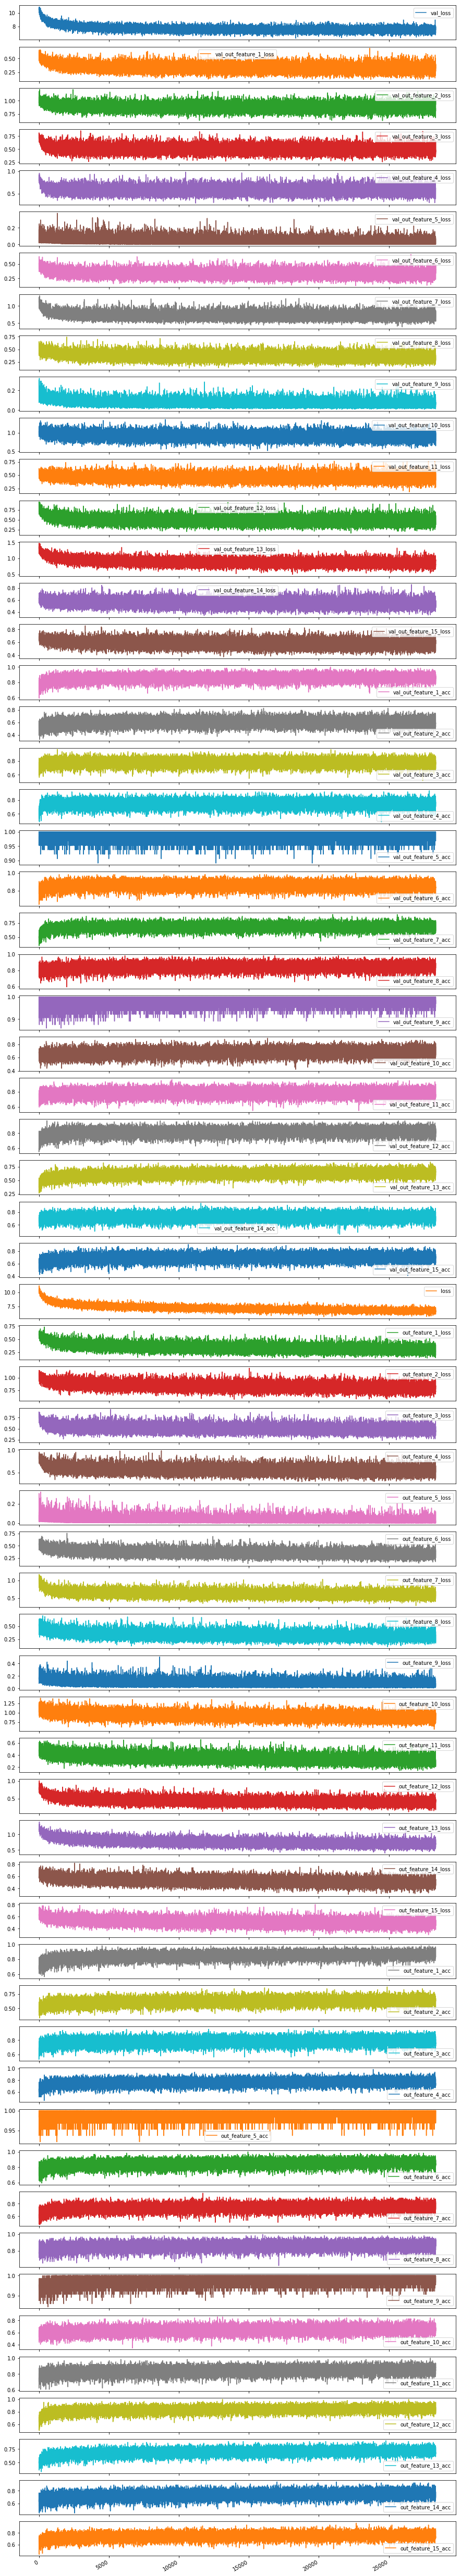

In [32]:
df_hist = pd.DataFrame(hist.history)
df_hist.plot(subplots=True, figsize=(15,100))
print(df_hist['val_loss'].min())
df_hist[df_hist['val_loss']<6.31]

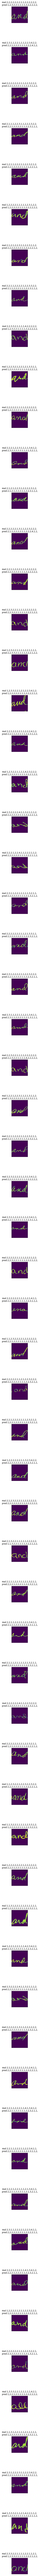

In [29]:
# human_features.load_weights('human_features_weights_v2.h5')
human_features.load_weights('weights/15-Multitask-FrozenEncoder-unseen_v1.h5')
vx,vo=next(vg)
# print(len(vo))
fig = plt.figure(figsize=(80,200))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=1.51, wspace=0.05)
for i in range(64):
#     print(i, '\nPredicted:')
    
    real=''
    for f in range(15):
#         print(vo[i][f])
        real+=str(np.argmax(vo[f][i])+1)+','
    
    f_probs = human_features.predict(np.expand_dims(vx[i],0))
#     print(f_probs)
    pred=''
    for prob in f_probs:
#         print(prob)
        pred+=str(np.argmax(prob[0])+1)+','
    
    ax = fig.add_subplot(64, 1, i + 1, xticks=[], yticks=[])
    ax.imshow(vx[i].reshape((64,64)))
    ax.set_title('real:'+real+'\n pred:'+pred)
#     print('\n----------')
#     print('True:')
#     for op in o:
#         print(np.argmax(op[i]),end=',')
        
#     print('\n++++++',i,'++++++')

In [33]:
# print(df_hist.columns)
total = 0
for i in range(1,16):
    print(df_hist.iloc[18351]['val_out_feature_{0}_acc'.format(i)].max())
    total+=df_hist.iloc[18351]['val_out_feature_{0}_acc'.format(i)]
print('total_acc:',total/15)
# print(np.mean([df_hist['val_out_feature_1_acc'].max(), df_hist['val_out_feature_2_acc'].max(),
#        df_hist['val_out_feature_3_acc'].max(), df_hist['val_out_feature_4_acc'].max(),
#        df_hist['val_out_feature_5_acc'].max(), df_hist['val_out_feature_6_acc'].max(),
#        df_hist['val_out_feature_7_acc'].max(), df_hist['val_out_feature_8_acc'].max()]))
# df_hist[df_hist['val_acc']>10.2]

0.859375
0.765625
0.859375
0.859375
0.984375
0.875
0.671875
0.90625
0.984375
0.71875
0.921875
0.875
0.640625
0.828125
0.765625
total_acc: 0.834375


In [ ]:
fig = plt.figure(figsize=(30,30))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(30):
    ax = fig.add_subplot(1, 30, i + 1, xticks=[], yticks=[])
    ax.imshow(inputs[64-30:64][i].reshape((64,64)))
    ax.set_title(i+34)

In [ ]:
# plt.imshow(inputs[10].reshape((64,64)))
# plt.subplots_adjust(hspace = 0.1)
# for i in range(1,9):
#     visualize_model = Model(human_features.input, human_features.get_layer('dense_layer_'+str(i)).output)
#     vis_out = visualize_model.predict(np.expand_dims(inputs[10],0))[0]
#     vis_out = np.rollaxis(a=vis_out, start=0, axis=2)
#     f,ax = plt.subplots(8,8)
#     f.subplots_adjust(hspace = .00, wspace=.02, top=0.95)
#     f.set_size_inches(15,15)
#     f.suptitle('dense_layer_'+str(i), fontsize=15)
# #     f.subplots_adjust(hspace = 0.1)
# #     plt.title('dense_layer_'+str(i))
#     print(vis_out.shape)
#     for r in range(8):
#         for c in range (8):
#             ax[r,c].imshow(vis_out[c+r*8])
#             ax[r,c].axis('off')
# #     break

In [ ]:
csv_data.var()

# Evaluation

In [ ]:
pred_flat = []
for i in range(1,len(feature_lengths)+1):
    pred_flat.append(human_features.get_layer('flatten_'+str(i)).output)
human_features_eval = Model(inputs=human_features.input, outputs=pred_flat)

In [ ]:
test_g = datagen(len(val_images)*5,image_path=val_path,vshift=(-10,10), list_of_writers=val_images)
test_x,test_y = next(test_g)

In [ ]:
pred_y=human_features_eval.predict(test_x)

In [ ]:
pred_y=np.array(pred_y)

In [ ]:
pred_y[:,0,:].shape

In [ ]:
test_im_normal = test_x[0]#255.0-cv2.imread('../Handwriting/cleaned_AND_data_64x64/0301c_num2.png',0)
test_im_shifted = test_x[1]#255.0-cv2.imread('../Handwriting/cleaned_AND_data_64x64/0301c_num1.png',0)
f,ax = plt.subplots(1,2)
f.subplots_adjust(hspace = .00, wspace=.05)
f.set_size_inches(5,1*3)
ax[0].imshow(test_im_normal.reshape((64,64)))
ax[0].axis('off')

ax[1].imshow(test_im_shifted.reshape((64,64)))
ax[1].axis('off')
ax[0].set_title('Left Input')
ax[1].set_title('Right Input')

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm_notebook

In [ ]:
l = pred_y[:,0,:]
r = pred_y[:,1,:]

In [ ]:
features = csv_data.keys()[1:]
feature_similarity_score=cosine_similarity(l,r).diagonal()
df_feat_sim_score = pd.DataFrame(columns=['features','feature_similarity_score'])
df_feat_sim_score['features']=features
df_feat_sim_score['feature_similarity_score']=feature_similarity_score
df_feat_sim_score.plot.bar(x='features')
df_feat_sim_score['feature_similarity_score'].mean()

In [ ]:
class_preds = human_features.predict(test_x[:2])

In [ ]:
for i in range(len(test_x[:2])):
    for f in range(15):
        print(np.argmax(class_preds[f][i]),end=',')
    print('')

In [ ]:
csv_data.var()